<h1>Progetto Fondamenti Dati<h1>


<p>L'obiettivo di questo studio è rispondere alle seguenti domande:</p>
<ul>
    <li>Esistono condizioni ambientali che favoriscono o inibiscono la crescita di alcune o di tutte le specie di alghe considerate?</li>
    <li>Si possono osservare tendenze a lungo termine nelle fioriture di alghe tossiche nell'ultimo decennio?</li>
    <li>È possibile identificare dei cicli stagionali nella quantità di alghe presenti?</li>
    <li>Alcune specie di alghe tendono a comparire contemporaneamente o sono in competizione tra loro?</li>
</ul>


Pacchetti utilizzati e importati:


In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import entropy
from statsmodels.nonparametric.smoothers_lowess import lowess
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D 
from adjustText import adjust_text

<h2>Data Cleaning<h2>


<h3>Da fare:</h3>
<ul>
    <li>Convertire le date in formato datetime</li>
    <li>Vedere se ci sono valori duplicati</li>
    <li>Trasformare la tabella in una pivot table</li>
    <li>Convertire i datatype errati</li>
    <li>Togliere le colonne con troppi NaN</li>
    <li>Gestione degli outlier</li>
    <li>Rinominare le colonne della pivot table con le unità di misura</li>
</ul>


In [192]:
# apro il csv originale
df_to_clean = pd.read_csv("Acqua_-_Alghe.csv")
df_to_clean.head()

LOCALITA'       STAZIONE     STATO SPECIE         PARAMETRO  \
0  Punta Sottile - Muggia  Terrazza mare    attiva    NaN  temperatura aria   
1  Punta Sottile - Muggia  Terrazza mare    attiva    NaN   copertura cielo   
2  Punta Sottile - Muggia  Terrazza mare    attiva    NaN   intensità vento   
3      Grignano - Trieste     Diga porto  dismessa    NaN  temperatura aria   
4      Grignano - Trieste     Diga porto  dismessa    NaN   copertura cielo   

    TIPO DATO UNITA' DI MISURA        DATA  ANNO  MESE  DATO  LATITUDINE  \
0  ambientali               °C  04/06/2009  2009     6  24,8    45.60555   
1  ambientali           decimi  04/06/2009  2009     6    10    45.60555   
2  ambientali              m/s  04/06/2009  2009     6   5,0    45.60555   
3  ambientali               °C  04/06/2009  2009     6  25,4    45.70510   
4  ambientali           decimi  04/06/2009  2009     6    10    45.70510   

   LONGITUDINE       CHIAVE  
0    13.721950  11613996820  
1    13.721950  11613996821  
2    13.721950  11613996823  
3    13.710883  11643996820  
4    13.710883  11643996821

Convertire date in formato datetime


In [ ]:
df_to_clean["DATA"] = pd.to_datetime(df_to_clean["DATA"], format="%d/%m/%Y")
df_to_clean.info()  # METTERE SOLO DTYPE DATA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   LOCALITA'         9466 non-null   object        
 1   STAZIONE          9466 non-null   object        
 2   STATO             9466 non-null   object        
 3   SPECIE            3418 non-null   object        
 4   PARAMETRO         9466 non-null   object        
 5   TIPO DATO         9466 non-null   object        
 6   UNITA' DI MISURA  8156 non-null   object        
 7   DATA              9466 non-null   datetime64[ns]
 8   ANNO              9466 non-null   int64         
 9   MESE              9466 non-null   int64         
 10  DATO              9392 non-null   object        
 11  LATITUDINE        9466 non-null   float64       
 12  LONGITUDINE       9466 non-null   float64       
 13  CHIAVE            9466 non-null   int64         
dtypes: datetime64[ns](1), fl

Quanti valori unici ci sono per ogni colonna?


In [194]:
df_to_clean.info()  # 9466 righe
df_to_clean.drop_duplicates()  # 9466 valori unici - non ci sono righe duplicate

# valori unici in base a colonne PARAMETRO, TIPO DATO, UNITA' DI MISURA, SPECIE
df_unique = df_to_clean[
    ["PARAMETRO", "TIPO DATO", "UNITA' DI MISURA", "SPECIE"]
].drop_duplicates()
df_unique

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   LOCALITA'         9466 non-null   object        
 1   STAZIONE          9466 non-null   object        
 2   STATO             9466 non-null   object        
 3   SPECIE            3418 non-null   object        
 4   PARAMETRO         9466 non-null   object        
 5   TIPO DATO         9466 non-null   object        
 6   UNITA' DI MISURA  8156 non-null   object        
 7   DATA              9466 non-null   datetime64[ns]
 8   ANNO              9466 non-null   int64         
 9   MESE              9466 non-null   int64         
 10  DATO              9392 non-null   object        
 11  LATITUDINE        9466 non-null   float64       
 12  LONGITUDINE       9466 non-null   float64       
 13  CHIAVE            9466 non-null   int64         
dtypes: datetime64[ns](1), fl

PARAMETRO   TIPO DATO UNITA' DI MISURA                  SPECIE
0       temperatura aria  ambientali               °C                     NaN
1        copertura cielo  ambientali           decimi                     NaN
2        intensità vento  ambientali              m/s                     NaN
111         altezza onda  ambientali                m                     NaN
192             salinità  idrologici              psu                     NaN
266           abbondanza   biologici           cell/l          Coolia monotis
378           abbondanza   biologici          cell/gr          Coolia monotis
609           abbondanza   biologici           cell/l       Prorocentrum lima
873           abbondanza   biologici          cell/gr   Ostreopsis cfr. ovata
1278  ossigeno disciolto  idrologici           % sat.                     NaN
1279         temperatura  idrologici               °C                     NaN
1348                  pH  idrologici              NaN                     NaN
2354             ammonio   nutrienti             µM-N                     NaN
2904             nitriti   nutrienti             µM-N                     NaN
2935             nitrati   nutrienti             µM-N                     NaN
2936             fosfati   nutrienti             µM-P                     NaN
3607          abbondanza   biologici           cell/l   Ostreopsis cfr. ovata
3658     direzione vento  ambientali              NaN                     NaN
3661    provenienza onda  ambientali              NaN                     NaN
6063          abbondanza   biologici          cell/gr       Prorocentrum lima
6151          abbondanza   biologici          cell/gr    Amphidinium carterae
6152          abbondanza   biologici           cell/l    Amphidinium carterae
6187          abbondanza   biologici           cell/l      Dinophysis caudata
6188          abbondanza   biologici          cell/gr  Dinophysis cfr. fortii
6189          abbondanza   biologici           cell/l       Dinophysis fortii

Per le analisi future, è meglio convertire la tabella di valori dal formato long al formato pivot. 
In questo modo, ogni dato biologico o ambientale occuperà una colonna specifica.
Anche ogni specie che ha una diversa unità di misura dovrà essere rappresentata in una colonna a sé stante.


In [195]:
# quali sono le unità di misura per le alghe?
# df con solo le misure delle alghe
species_units = df_to_clean[df_to_clean["SPECIE"].notna()][
    ["SPECIE", "PARAMETRO", "UNITA' DI MISURA"]
].drop_duplicates()
# ordino df per specie e unità di misura
print(species_units.sort_values(["SPECIE", "UNITA' DI MISURA"]))

                      SPECIE   PARAMETRO UNITA' DI MISURA
6151    Amphidinium carterae  abbondanza          cell/gr
6152    Amphidinium carterae  abbondanza           cell/l
378           Coolia monotis  abbondanza          cell/gr
266           Coolia monotis  abbondanza           cell/l
6187      Dinophysis caudata  abbondanza           cell/l
6188  Dinophysis cfr. fortii  abbondanza          cell/gr
6189       Dinophysis fortii  abbondanza           cell/l
873    Ostreopsis cfr. ovata  abbondanza          cell/gr
3607   Ostreopsis cfr. ovata  abbondanza           cell/l
6063       Prorocentrum lima  abbondanza          cell/gr
609        Prorocentrum lima  abbondanza           cell/l


Creo df con dati ambientali e df con dati biologici e poi li unisco per creare la pivot table finale con tutti i dati


In [196]:
# pivot tb per dati ambientali
df_env = df_to_clean[df_to_clean["SPECIE"].isna()].copy()
df_pivot_env = df_env.pivot_table(
    index=[
        "LOCALITA'",
        "STAZIONE",
        "STATO",
        "DATA",
        "ANNO",
        "MESE",
        "LATITUDINE",
        "LONGITUDINE",
    ],
    columns="PARAMETRO",
    values="DATO",
    aggfunc="first",
).reset_index()

# pivot tb per dati delle alghe con unità di misura specifiche
df_pivot_species = df_to_clean[df_to_clean["SPECIE"].notna()].copy()

if len(df_pivot_species) > 0:
    # creare colonne con specie e unità di misura
    df_pivot_species["UNIT_CLEAN"] = (
        df_pivot_species["UNITA' DI MISURA"].str.replace("/", "_").str.replace(" ", "_")
    )
    df_pivot_species["SPECIE_UNIT"] = (
        df_pivot_species["SPECIE"] + "_" + df_pivot_species["UNIT_CLEAN"]
    )

    # pivot tb per dati delle alghe con unità di misura specifiche
    df_pivot_species = df_pivot_species.pivot_table(
        index=[
            "LOCALITA'",
            "STAZIONE",
            "STATO",
            "DATA",
            "ANNO",
            "MESE",
            "LATITUDINE",
            "LONGITUDINE",
        ],
        columns="SPECIE_UNIT",
        values="DATO",
        aggfunc="first",
    ).reset_index()

    # metto assieme i due df
    df_pivot_final = df_pivot_env.merge(
        df_pivot_species,
        on=[
            "LOCALITA'",
            "STAZIONE",
            "STATO",
            "DATA",
            "ANNO",
            "MESE",
            "LATITUDINE",
            "LONGITUDINE",
        ],
        how="outer",  # teniamo righe di entrambi i df
    )
else:
    df_pivot_final = df_pivot_env.copy()

df_pivot_final.columns.name = None

print(df_pivot_final.columns.tolist())  # nomi delle colonne ok
print(df_pivot_final)  # pivot table ok
print(df_pivot_final.info())  # info ok
df_pivot_final.to_csv("df_pivot.csv", index=False)

["LOCALITA'", 'STAZIONE', 'STATO', 'DATA', 'ANNO', 'MESE', 'LATITUDINE', 'LONGITUDINE', 'altezza onda', 'ammonio', 'copertura cielo', 'direzione vento', 'fosfati', 'intensità vento', 'nitrati', 'nitriti', 'ossigeno disciolto', 'pH', 'provenienza onda', 'salinità', 'temperatura', 'temperatura aria', 'Amphidinium carterae_cell_gr', 'Amphidinium carterae_cell_l', 'Coolia monotis_cell_gr', 'Coolia monotis_cell_l', 'Dinophysis caudata_cell_l', 'Dinophysis cfr. fortii_cell_gr', 'Dinophysis fortii_cell_l', 'Ostreopsis cfr. ovata_cell_gr', 'Ostreopsis cfr. ovata_cell_l', 'Prorocentrum lima_cell_gr', 'Prorocentrum lima_cell_l']
             LOCALITA'                          STAZIONE     STATO       DATA  \
0    Barcola - Trieste                          ex CEDAS    attiva 2010-05-25   
1    Barcola - Trieste                          ex CEDAS    attiva 2010-06-28   
2    Barcola - Trieste                          ex CEDAS    attiva 2010-07-20   
3    Barcola - Trieste                          e

Vediamo le info della pivot table appena creata per capire se i datatype sono corretti o vanno cambiati


In [197]:
# re-importo il df pivot
df_pivot = pd.read_csv(
    "df_pivot.csv", parse_dates=["DATA"]
)  # per importare la data in formato datetime

df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   LOCALITA'                       478 non-null    object        
 1   STAZIONE                        478 non-null    object        
 2   STATO                           478 non-null    object        
 3   DATA                            478 non-null    datetime64[ns]
 4   ANNO                            478 non-null    int64         
 5   MESE                            478 non-null    int64         
 6   LATITUDINE                      478 non-null    float64       
 7   LONGITUDINE                     478 non-null    float64       
 8   altezza onda                    440 non-null    object        
 9   ammonio                         417 non-null    object        
 10  copertura cielo                 440 non-null    object        
 11  direzi

<h3>Caratteristiche Generali</h3>
<p>Il dataset df è composto da 478 righe e 33 colonne.</p>
<p>Ci sono tre tipi principali:</p>
<ul>
    <li><code>object</code>: per colonne di testo o con tipi di dato misti.</li>
    <li><code>int</code>: per le colonne "anno" e "mese".</li>
    <li><code>float</code>: per valori numerici decimali.</li>
</ul>

<h3>Cosa notiamo?</h3>
<ol>
    <li> Tutte le colonne relative alle abbondanze sono correttamente in formato numerico (<code>float</code>).</li>
    <li> Alcuni parametri ambientali sono stati letti come testo (<code>object</code>) e necessitano di una conversione.</li>
    <li> Dati mancanti (pH): sono presenti solo 385 valori su 478. Se questo parametro si rivelasse cruciale, si potrebbe dover escludere i campionamenti che ne sono privi.</li>
    <li>Dati mancanti (Ammonio): Anche per l'ammonio si riscontra una situazione simile, con 417 valori disponibili su 478.</li>
    <li>Specie poco campionate: Le specie del genere <em>Dinophysis</em> compaiono in un numero molto basso di record. Per questo motivo rimuoveremo le relative colonne dal dataset per non alterare l'analisi.</li>
</ol>

<h3>Cosa risolvere?</h3>
<p>Dobbiamo risolvere il problema del datatype per queste colonne, in modo che non vengano più interpretate come testo (<code>object</code>): altezza onda, ammonio, fosfati, nitrati, pH, salinità, temperatura, Ostreopsis cfr. ovata_cell_gr interpretate come object </p>


In [198]:
# vedo quali sono i valori unici per ogni colonna
df_pivot.nunique()

LOCALITA'                          14
STAZIONE                           13
STATO                               2
DATA                              128
ANNO                               16
MESE                                6
LATITUDINE                         14
LONGITUDINE                        14
altezza onda                        7
ammonio                           217
copertura cielo                    13
direzione vento                    25
fosfati                            50
intensità vento                   115
nitrati                           341
nitriti                            62
ossigeno disciolto                393
pH                                 72
provenienza onda                   11
salinità                          328
temperatura                       351
temperatura aria                  121
Amphidinium carterae_cell_gr      127
Amphidinium carterae_cell_l        16
Coolia monotis_cell_gr            323
Coolia monotis_cell_l              40
Dinophysis c

Vedo quali sono i valori unici di ogni colonna per capire se cambiare il formato o se interpretarli diversamente.


In [199]:
df_pivot["altezza onda"].unique()
# sono presenti ASSENTE e NaN - vanno interpretati diversamente

array(['ASSENTE', '0,50', '0,30', '0,20', '0,40', '0,10', nan, '0,5'],
      dtype=object)

In [200]:
df_pivot["intensità vento"].unique()
# ASSENTE e NaN - vanno interpretati diversamente

array(['0,5', '2,1', '2,6', '2', '3', '10,5', '4,5', '6,0', '5', '0',
       '2,5', '-', '2,2', '2,7', '1,5', '6,5', '15,0', 'ASSENTE', '1,3',
       '1,0', '5,0', '4,00', '4', '0,0', '5,3', '4,7', '6,11', '6,67',
       '4,20', '6,10', '2,8', '3,50', '4,70', '2,20', '1,70', '3,3',
       '1,9', '2,50', '3,60', '10,00', '9,20', '5,80', '1,90', '3,10',
       '7,80', '2,80', '7,20', '10,80', '8,80', '1,60', '1,40', '0,80',
       '16,70', '0,2', '1,7', nan, '5,2', '3,0', '3,00', '2,30', '1',
       '7,5', '3,6', '6,39', '5,60', '5,00', '1,4', '8,30', '3,30',
       '9,40', '17,22', '4,10', '1,00', '4,40', '1,10', '1,6', '0,6',
       '3,5', '0,00', '4,0', '2,0', '7,4', '6', '5,8', '5,5', '11,0',
       '10,0', '5,6', '10', '2,3', '9,0', '8,5', '2,00', '9,00', '2,4',
       '4,4', '7,50', '6,40', '8,10', '9,70', '5,28', '10,50', '9,17',
       '1,30', '0,3', '4,8', '0,07', '2,40', '4,2', '2,9', '8,60',
       '15,20', '3,90', '3,9', '7', '5,7'], dtype=object)

In [201]:
df_pivot["ammonio"].unique()
# ok convertire to numeric

array(['1,42', '1,59', '3,69', '1,09', '1,61', '1,62', '0,88', '2,01',
       '1,54', '0,53', nan, '1,10', '1,13', '1,01', '1,40', '1,06',
       '4,12', '1,41', '5,25', '5,41', '1,22', '3,44', '2,15', '1,14',
       '1,18', '0,02', '0,35', '0,96', '1,74', '1,3', '1,05', '0,71',
       '0,43', '0,77', '2,02', '1,25', '2,37', '1,34', '0,83', '0,98',
       '1,02', '0,45', '1,35', '2,64', '0,11', '0,48', '1,12', '0,91',
       '0,01', '0,13', '0,10', '0,85', '0,94', '0,82', '0,50', '1,44',
       '<0,01', '0,78', '1,77', '1,15', '2,07', '1,93', '3,07', '3,57',
       '1,71', '1,91', '1,46', '0,80', '1,24', '1,45', '0,64', '0,69',
       '0,87', '0,58', '0,81', '5,40', '3,06', '1,27', '2,72', '1,17',
       '1,11', '1,23', '1,51', '1,2', '1,28', '0,72', '1,03', '2,08',
       '1,38', '1,19', '0,08', '1,07', '1,32', '4,21', '0,32', '1',
       '0,56', '1,79', '0,31', '0,66', '0,37', '1,70', '0,19', '1,47',
       '0,99', '1,68', '1,04', '0,54', '1,37', '0,97', '2,06', '2,26',
       '1,99'

In [202]:
df_pivot["copertura cielo"].unique()
# NaN e ASSENTE - vanno interpretati diversamente

array(['0', '1', '0,5', '2', '9', '5', '3', '4', '10', '8', 'ASSENTE',
       '7', '6', nan], dtype=object)

In [203]:
df_pivot["fosfati"].unique()
# ok convertire to numeric

array(['0,06', '0,07', '0,10', '0,01', '0,05', '0,03', '0,02', nan,
       '0,08', '0,04', '0,1', '0,11', '0,09', '0,48', '0,17', '0,32',
       '1,21', '0,12', '1,78', '0,29', '0,59', '0,18', '0,19', '0,20',
       '0,23', '0,40', '0,64', '0,13', '0,16', '1,22', '0,22', '<0,01',
       '0,15', '0,14', '0,53', '1,50', '0,67', '0,21', '1,59', '0,30',
       '0,36', '1,9', '0,25', '1,66', '1,18', '0,37', '0,24', '0,35',
       '0,55', '0,28', '0,33'], dtype=object)

In [204]:
df_pivot["nitrati"].unique()
# ok convertire to numeric
# quel < potrebbe essere un errore di digitazione ma convertiamo a float
# lasciamo float

array(['13,40', '7,48', '2,11', '2,58', '1,74', '0,24', '1,08', '2,07',
       '0,00', nan, '1,54', '6,12', '2,51', '1,28', '6,38', '1,03',
       '6,65', '1,55', '5,36', '1,52', '13,1', '0,61', '2,74', '3,03',
       '6,67', '1', '0,02', '0,42', '3,3', '0,74', '0,75', '5,55', '3,21',
       '3,88', '3,22', '4,06', '3,85', '5,95', '2,86', '2,96', '2,21',
       '5,72', '4,61', '0,07', '7,3', '4,77', '7,64', '4,5', '3,62',
       '4,94', '2,83', '3,5', '0,53', '0,37', '2,12', '1,04', '1,51',
       '1,50', '0,10', '2,19', '0,01', '1,83', '1,68', '0,49', '1,48',
       '2,57', '2,55', '0,89', '1,88', '0,65', '0,73', '0,44', '1,45',
       '0,48', '0,41', '0,83', '<1,43', '14,72', '14,96', '2,95', '2,33',
       '1,14', '3,10', '1,97', '2,87', '1,91', '8,14', '13,00', '2,53',
       '2,38', '7,06', '12,00', '2,32', '3,97', '1,64', '11,7', '1,99',
       '4,19', '3,17', '15,2', '2,04', '4,9', '2,97', '6,41', '2,56',
       '0,9', '6,19', '3,57', '6,44', '5,80', '5,24', '9,92', '6,79',
    

In [205]:
df_pivot["nitriti"].unique()
# ok ma c'è un <
# convertiamo a float

array(['0,27', '0,16', '0,31', '0,09', '0,11', '0,07', '0,14', '0,10',
       '0,02', nan, '0,08', '0,13', '0,25', '0,37', '0,28', '0,06', '0,1',
       '0,04', '0,05', '0,03', '0,12', '0,18', '0,15', '0,01', '<0,01',
       '0,35', '<0,06', '0,17', '0,23', '10,00', '0,19', '0,48', '0,26',
       '0,24', '0,2', '0,20', '0,21', '0,22', '0,43', '0,38', '0,29',
       '0,34', '0,64', '0,70', '0,83', '0,51', '0,40', '0,47', '3,43',
       '0,80', '0,74', '0,63', '0,57', '1,15', '0,36', '0,59', '0,41',
       '0,3', '0,33', '0,49', '0,30', '0,54', '0,32'], dtype=object)

In [206]:
df_pivot["ossigeno disciolto"].unique()
# ok convertire to numeric

array(['111,00', '108,00', '74,60', '74,80', '81,20', '111,0', '103,5',
       '99,9', '100,3', '112,5', nan, '123,55', '90,45', '97,45',
       '128,58', '80,45', '108,08', '104,15', '111,56', '106,73', '96,99',
       '95,99', '109,43', '102,48', '124,22', '103,56', '97,86', '111,79',
       '111,75', '116,69', '79,44', '106,61', '105,50', '103,31', '98,92',
       '92,84', '90,89', '106,23', '98,66', '110,22', '108,04', '86,66',
       '110,70', '96,84', '99,40', '87,40', '98,88', '103,52', '97,07',
       '92,72', '98,14', '96,55', '87,29', '80,25', '93,98', '93,05',
       '86,70', '75,70', '99,31', '141,37', '98,79', '86,58', '87,13',
       '82,88', '88,52', '86,99', '93,31', '107,38', '110,06', '87,81',
       '105,97', '104,54', '107,89', '89,19', '87,39', '81,05', '97,11',
       '80,66', '86,47', '92,60', '84,93', '80,92', '82,43', '83,18',
       '104,00', '122,50', '154,10', '83,40', '71,70', '107,9', '100,4',
       '126,0', '127,9', '123,8', '120,53', '110,95', '99,77', 

In [207]:
df_pivot["pH"].unique()
# ok convertire to numeric

array(['8,08', '8,28', '7,87', '8,23', '8,06', '8,16', '8,17', '8,24',
       nan, '6,20', '8,02', '8,84', '8,15', '7,90', '8,21', '8,14',
       '8,03', '7,66', '8,26', '8,18', '8,25', '6,79', '8,11', '8,12',
       '8,31', '8,41', '8,36', '8,46', '8,34', '8,19', '8,20', '8,10',
       '8,22', '8,29', '8,33', '8,13', '8,09', '7,84', '8,30', '8,00',
       '7,96', '8,05', '8,01', '8,35', '7,88', '7,99', '7,92', '7,93',
       '8,42', '8,39', '8,49', '8,47', '8,04', '8,38', '8,43', '8,50',
       '8,32', '7,78', '7,98', '8,45', '7,74', '7,86', '8,2', '8,27',
       '7,31', '7,61', '8,07', '7,97', '8,4', '8,37', '7,94', '8,52',
       '8,90'], dtype=object)

In [208]:
df_pivot["salinità"].unique()
# ok convertire to numeric

array(['27,20', '30,60', '37,00', '33,50', '34,40', '36,73', '36,71',
       '35,46', '35,02', '35,74', nan, '36,889', '33,170', '34,875',
       '37,386', '36,896', '36,36', '31,57', '36,02', '36,14', '35,93',
       '30,72', '37,19', '33,89', '34,74', '33,02', '36,35', '37,30',
       '37,74', '35,68', '36,56', '36,06', '33,91', '36,45', '37,10',
       '36,53', '34,42', '33,6', '35,57', '35,98', '37,70', '37,8',
       '37,50', '37,40', '36,95', '32,50', '36,96', '36,62', '37,52',
       '37,23', '37,58', '30,32', '34,64', '35,51', '36,39', '37,91',
       '36,87', '36,21', '34,45', '31,96', '34,44', '34,69', '36,97',
       '36,85', '36,88', '36,41', '37,90', '38,13', '38,10', '38,18',
       '37,78', '37,69', '37,34', '36,59', '37,33', '36,22', '35,88',
       '36,37', '35,22', '35,60', '26,10', '27,50', '33,40', '33,10',
       '36,55', '34,59', '35,35', '35,15', '35,83', '34,202', '30,893',
       '35,427', '36,981', '36,207', '32,52', '30,88', '36,42', '36,58',
       '35,73', 

In [209]:
df_pivot["temperatura"].unique()
# ok convertire to numeric

array(['19,9', '24,07', '17,66', '23,76', '20,60', '15,50', '19,34',
       '25,87', '24,34', '25,37', nan, '18,669', '26,931', '27,924',
       '24,948', '21,757', '18,52', '26,13', '25,22', '23,56', '22,93',
       '19,67', '16,87', '24,61', '25,46', '20,58', '21,05', '14,93',
       '21,15', '27,54', '22,15', '22,95', '16,90', '25,30', '25,79',
       '22,94', '23,28', '18,83', '24,01', '22,23', '24,60', '22,54',
       '17,34', '22,31', '25,60', '21,30', '24,74', '25,58', '23,65',
       '25,70', '25,81', '23,63', '23,64', '20,70', '24,22', '24,48',
       '23,17', '25,44', '20,74', '24,80', '21,50', '26,11', '26,63',
       '24,79', '26,77', '22,58', '22,84', '22,49', '24,70', '26,90',
       '21,10', '24,89', '24,88', '23,53', '22,30', '22,11', '26,48',
       '24,99', '24,91', '24,20', '19,10', '24,49', '26,62', '27,94',
       '28,13', '23,09', '21,06', '24,50', '25,40', '23,89', '21,80',
       '15,41', '22,81', '26,61', '25,50', '25,15', '18,055', '26,767',
       '26,945', '

In [210]:
df_pivot["temperatura aria"].unique()
# ok convertire to numeric
# - viene convertito in NaN

array(['21,4', '25,2', '28,0', '26,5', '22', '25,0', '32,2', '24,9',
       '28,2', '26,4', '-', '24,5', '34,8', '35,5', '31,9', '18,2',
       '34,5', '33,7', '31,4', '27,0', '23,0', '22,6', '29,8', '29', '20',
       '29,5', '34,0', '24', '23', '18,0', '28,5', '30', '31', '27', '32',
       '25', '26', '28', '18', '21', '27,6', '23,1', '31,2', '18,6', nan,
       '26,0', '21,0', '28,8', '30,6', '22,4', '15,0', '27,3', '25,9',
       '22,7', '36,4', '35,9', '20,6', '33,5', '33,3', '29,6', '29,0',
       '17,2', '22,2', '21,8', '25,5', '21,5', '20,0', '30,0', '33', '34',
       '19', '18,9', '26,8', '27,2', '23,2', '16,0', '28,6', '30,7',
       '28,7', '24,8', '33,0', '30,2', '23,8', '30,5', '19,5', '30,8',
       '25,4', '24,4', '18,8', '29,2', '28,4', '27,5', '20,8', '31,6',
       '32,5', '22,9', '26,2', '25,8', '27,8', '24,3', '37,0', '31,0',
       '32,0', '15,6', '19,4', '33,8', '31,8', '17,6', '27,4', '35',
       '28,3', '22,5', '17,0', '20,2', '30,3', '34,7', '29,4', '28,9',


In [211]:
df_pivot["direzione vento"].unique()
# non convertire to numeric perché string
# quel - viene sostituito con NaN dato che non è valore valido

array(['O', 'S', 'SSE', 'SSO', 'ASSENTE', 'OSO', '-', 'SE', 'SO', 'ONO',
       'NO', 'NNO', 'NE', 'ENE', 'E', 'WNW', 'NNE', 'W', 'NW', 'ESE',
       'NNW', nan, 'N', 'WSW', 'SW', 'SSW'], dtype=object)

Converto i datatype delle colonne con un fomato non corretto.


In [212]:
# converto le colonne per avere formato corretto
df_pivot["ammonio"] = pd.to_numeric(
    df_pivot["ammonio"].str.replace(",", "."), errors="coerce"
)  # ok
# altezza onda e intensità vento hanno NaN ma anche ASSENTE quindi vanno interpretati diversamente
df_pivot["altezza onda"] = df_pivot["altezza onda"].str.replace(",", ".")
df_pivot["altezza onda"] = df_pivot["altezza onda"].replace("ASSENTE", "0")
df_pivot["altezza onda"] = pd.to_numeric(df_pivot["altezza onda"], errors="coerce")
df_pivot["intensità vento"] = df_pivot["intensità vento"].str.replace(",", ".")
df_pivot["intensità vento"] = df_pivot["intensità vento"].replace("ASSENTE", 0)
df_pivot["intensità vento"] = pd.to_numeric(
    df_pivot["intensità vento"], errors="coerce"
)
df_pivot["copertura cielo"] = df_pivot["copertura cielo"].str.replace(",", ".")
df_pivot["copertura cielo"] = df_pivot["copertura cielo"].replace("ASSENTE", 0)
df_pivot["copertura cielo"] = pd.to_numeric(
    df_pivot["copertura cielo"], errors="coerce"
)
df_pivot["fosfati"] = pd.to_numeric(
    df_pivot["fosfati"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["nitrati"] = pd.to_numeric(
    df_pivot["nitrati"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["nitriti"] = pd.to_numeric(
    df_pivot["nitriti"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["ossigeno disciolto"] = pd.to_numeric(
    df_pivot["ossigeno disciolto"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["pH"] = pd.to_numeric(
    df_pivot["pH"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["salinità"] = pd.to_numeric(
    df_pivot["salinità"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["temperatura"] = pd.to_numeric(
    df_pivot["temperatura"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["temperatura aria"] = pd.to_numeric(
    df_pivot["temperatura aria"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["Ostreopsis cfr. ovata_cell_gr"] = pd.to_numeric(
    df_pivot["Ostreopsis cfr. ovata_cell_gr"].str.replace(",", "."), errors="coerce"
)  # ok
df_pivot["direzione vento"] = df_pivot["direzione vento"].replace("-", np.nan)
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   LOCALITA'                       478 non-null    object        
 1   STAZIONE                        478 non-null    object        
 2   STATO                           478 non-null    object        
 3   DATA                            478 non-null    datetime64[ns]
 4   ANNO                            478 non-null    int64         
 5   MESE                            478 non-null    int64         
 6   LATITUDINE                      478 non-null    float64       
 7   LONGITUDINE                     478 non-null    float64       
 8   altezza onda                    440 non-null    float64       
 9   ammonio                         415 non-null    float64       
 10  copertura cielo                 440 non-null    float64       
 11  direzi

Controllo quanti NaN ci sono nelle diverse colonne.


In [213]:
# controllo che non ci siano valori nulli
df_pivot.isnull().sum()

LOCALITA'                           0
STAZIONE                            0
STATO                               0
DATA                                0
ANNO                                0
MESE                                0
LATITUDINE                          0
LONGITUDINE                         0
altezza onda                       38
ammonio                            63
copertura cielo                    38
direzione vento                    41
fosfati                            70
intensità vento                    41
nitrati                            72
nitriti                            74
ossigeno disciolto                 60
pH                                 93
provenienza onda                   38
salinità                           52
temperatura                        48
temperatura aria                   41
Amphidinium carterae_cell_gr       66
Amphidinium carterae_cell_l        66
Coolia monotis_cell_gr             42
Coolia monotis_cell_l              66
Dinophysis c

Dinophysis caudata_cell_l, Dinophysis cfr. fortii_cell_gr e Dinophysis fortii_cell_l hanno pochissimi valori campionati. Pertanto effettueremo l'analisi sul dataframe togliendo queste 3 colonne.


In [214]:
# rimuovo Dinophysis columns
dinophysis_columns = [
    "Dinophysis caudata_cell_l",
    "Dinophysis cfr. fortii_cell_gr",
    "Dinophysis fortii_cell_l",
]
df_pivot = df_pivot.drop(columns=dinophysis_columns)

In [215]:
df_pivot.columns.tolist()  # colonne rimosse

["LOCALITA'",
 'STAZIONE',
 'STATO',
 'DATA',
 'ANNO',
 'MESE',
 'LATITUDINE',
 'LONGITUDINE',
 'altezza onda',
 'ammonio',
 'copertura cielo',
 'direzione vento',
 'fosfati',
 'intensità vento',
 'nitrati',
 'nitriti',
 'ossigeno disciolto',
 'pH',
 'provenienza onda',
 'salinità',
 'temperatura',
 'temperatura aria',
 'Amphidinium carterae_cell_gr',
 'Amphidinium carterae_cell_l',
 'Coolia monotis_cell_gr',
 'Coolia monotis_cell_l',
 'Ostreopsis cfr. ovata_cell_gr',
 'Ostreopsis cfr. ovata_cell_l',
 'Prorocentrum lima_cell_gr',
 'Prorocentrum lima_cell_l']

Vediamo quali sono le statistiche di base delle colonne per capire se ci sono outlier.


In [216]:
info = df_pivot.describe()
info_t = info.T  # trasposto per migliore leggibilità
info_t

count                           mean  \
DATA                             478  2016-03-01 10:23:35.899581696   
ANNO                           478.0                    2015.552301   
MESE                           478.0                       7.349372   
LATITUDINE                     478.0                      45.705376   
LONGITUDINE                    478.0                      13.641078   
altezza onda                   440.0                       0.017273   
ammonio                        415.0                       1.304337   
copertura cielo                440.0                       4.127273   
fosfati                        408.0                       0.112181   
intensità vento                437.0                       3.130092   
nitrati                        406.0                       6.744138   
nitriti                        404.0                       0.190347   
ossigeno disciolto             418.0                     101.769952   
pH                             385.0                       8.161143   
salinità                       426.0                      34.022707   
temperatura                    430.0                      23.899593   
temperatura aria               437.0                      26.104805   
Amphidinium carterae_cell_gr   412.0                     387.946602   
Amphidinium carterae_cell_l    412.0                      73.718447   
Coolia monotis_cell_gr         436.0                    5942.270642   
Coolia monotis_cell_l          412.0                     250.242718   
Ostreopsis cfr. ovata_cell_gr  436.0                   34434.598624   
Ostreopsis cfr. ovata_cell_l   425.0                    8201.524706   
Prorocentrum lima_cell_gr      436.0                     997.825688   
Prorocentrum lima_cell_l       412.0                     119.021845   

                                               min                  25%  \
DATA                           2009-06-03 00:00:00  2011-07-13 00:00:00   
ANNO                                        2009.0               2011.0   
MESE                                           5.0                  6.0   
LATITUDINE                                45.59665             45.66175   
LONGITUDINE                               13.10955              13.6308   
altezza onda                                   0.0                  0.0   
ammonio                                       0.01                 0.71   
copertura cielo                                0.0                  1.0   
fosfati                                       0.01                 0.02   
intensità vento                                0.0                  1.0   
nitrati                                        0.0                 1.48   
nitriti                                       0.01                 0.07   
ossigeno disciolto                            70.0              91.2625   
pH                                             6.2                 8.09   
salinità                                      14.1               32.685   
temperatura                                  14.91              22.2075   
temperatura aria                              15.0                 24.0   
Amphidinium carterae_cell_gr                   0.0                  0.0   
Amphidinium carterae_cell_l                    0.0                  0.0   
Coolia monotis_cell_gr                         0.0                 72.0   
Coolia monotis_cell_l                          0.0                  0.0   
Ostreopsis cfr. ovata_cell_gr                  0.0                  0.0   
Ostreopsis cfr. ovata_cell_l                   0.0                  0.0   
Prorocentrum lima_cell_gr                      0.0                  0.0   
Prorocentrum lima_cell_l                       0.0                  0.0   

                                               50%                  75%  \
DATA                           2015-07-06 00:00:00  2020-09-03 12:00:00   
ANNO                                        2015.0               2020.0   
MESE    

<h3>Cosa emerge da questa analisi</h3>
<ul>
<li>I dati analizzati coprono un periodo di 15 anni.</li>
<li>I prelievi sono stati effettuati tra maggio e ottobre, periodo tipico per le fioriture di alghe (algal blooms).</li>
<li>L'area di studio è limitata ad alcune stazioni di campionamento in Friuli-Venezia Giulia.</li>
<li>L'altezza dell'onda risulta bassa, un dato normale per le zone costiere monitorate.</li>
<li>
La concentrazione di nutrienti (Ammonio, Fosfati, Nitriti, Nitrati) varia molto, con picchi occasionali che ne alzano la media. Questo andamento potrebbe essere legato alle fioriture algali.
</li>
<li>
Anche la variazione dell'ossigeno disciolto potrebbe indicare la presenza di fioriture algali.
</li>
<li>
I valori di pH sono generalmente nella norma, ad eccezione di un minimo di 6.2 che appare anomalo e potrebbe essere un errore o un evento isolato.
</li>
<li>
Le temperature di aria e acqua sono plausibili, anche se un valore massimo di 37°C merita una verifica.
</li>
<li>
La salinità ha un intervallo di valori molto ampio (da 14 a 38).
</li>
<li>
Le fioriture algali sono eventi rari (presenza di molti 0 nei dati di abbondanza), ma quando si verificano raggiungono densità molto elevate.
</li>
<li>
<strong>Ostreopsis cf. ovata:</strong> Questa alga provoca fioriture molto intense e massicce, con picchi di concentrazione estremamente alti (fino a 4.1 milioni).
</li>
<li>
<strong>Coolia monotis:</strong> Fiorisce più di frequente e può raggiungere concentrazioni elevate (oltre 300.000).
</li>
<li>
<strong>Prorocentrum lima e Amphidinium carterae:</strong> Sono specie presenti che possono dare origine a fioriture, ma di entità più limitata rispetto alle altre.
</li>
</ul>


Controllo i valori anomali


In [217]:
T_alta = df_pivot[df_pivot["temperatura"] >= 37]
T_alta.T
# da dati storici 37 è valore troppo alto
# probabile errota misurazione e outlier
# da rimuovere

454
LOCALITA'                            Staranzano - Monfalcone
STAZIONE                       Spiaggia - Lido di Staranzano
STATO                                               dismessa
DATA                                     2010-07-22 00:00:00
ANNO                                                    2010
MESE                                                       7
LATITUDINE                                         45.765867
LONGITUDINE                                        13.527767
altezza onda                                             0.0
ammonio                                                  1.2
copertura cielo                                          0.5
direzione vento                                           SO
fosfati                                                 0.01
intensità vento                                          2.2
nitrati                                                 5.91
nitriti                                                  0.8
ossigeno disciolto                                     161.7
pH                                                       8.9
provenienza onda                                     ASSENTE
salinità                                                19.0
temperatura                                             37.0
temperatura aria                                        31.4
Amphidinium carterae_cell_gr                             0.0
Amphidinium carterae_cell_l                              0.0
Coolia monotis_cell_gr                                   0.0
Coolia monotis_cell_l                                    0.0
Ostreopsis cfr. ovata_cell_gr                            0.0
Ostreopsis cfr. ovata_cell_l                             0.0
Prorocentrum lima_cell_gr                              768.0
Prorocentrum lima_cell_l                                 0.0

In [218]:
T_alta_aria = df_pivot[df_pivot["temperatura aria"] >= 37]
T_alta_aria.T
# da dati storici 37 è valore troppo alto
# non ha senso che T acqua sia più alta di T aria
# da rimuovere

287
LOCALITA'                      Punta Sottile - Muggia
STAZIONE                                Terrazza mare
STATO                                          attiva
DATA                              2012-06-21 00:00:00
ANNO                                             2012
MESE                                                6
LATITUDINE                                   45.60555
LONGITUDINE                                  13.72195
altezza onda                                      0.0
ammonio                                          1.19
copertura cielo                                   0.0
direzione vento                               ASSENTE
fosfati                                          0.02
intensità vento                                   0.0
nitrati                                          3.49
nitriti                                          0.11
ossigeno disciolto                             101.74
pH                                               8.09
provenienza onda                              ASSENTE
salinità                                       33.779
temperatura                                     27.94
temperatura aria                                 37.0
Amphidinium carterae_cell_gr                      0.0
Amphidinium carterae_cell_l                       0.0
Coolia monotis_cell_gr                          459.0
Coolia monotis_cell_l                             0.0
Ostreopsis cfr. ovata_cell_gr                    46.0
Ostreopsis cfr. ovata_cell_l                      0.0
Prorocentrum lima_cell_gr                       184.0
Prorocentrum lima_cell_l                          0.0

In [219]:
pH_basso = df_pivot[df_pivot["pH"] <= 7.5]
pH_basso.T
# pH molto basso associato a ossigeno disciolto molto basso
# di fatto ossigeno è alto quindi probabile errore di misurazione e outlier
# pochi punti outlier da rimuovere

12                   31   \
LOCALITA'                        Barcola - Trieste    Barcola - Trieste   
STAZIONE                                  ex CEDAS             ex CEDAS   
STATO                                       attiva               attiva   
DATA                           2012-05-24 00:00:00  2015-08-17 00:00:00   
ANNO                                          2012                 2015   
MESE                                             5                    8   
LATITUDINE                                45.68695             45.68695   
LONGITUDINE                              13.745717            13.745717   
altezza onda                                   0.5                  0.0   
ammonio                                        1.1                 1.74   
copertura cielo                                9.0                 10.0   
direzione vento                                 SE              ASSENTE   
fosfati                                       0.01                 0.03   
intensità vento                                2.2                  0.0   
nitrati                                       1.54                 0.74   
nitriti                                       0.08                 0.04   
ossigeno disciolto                          123.55                79.44   
pH                                             6.2                 6.79   
provenienza onda                                SE              ASSENTE   
salinità                                    36.889                30.72   
temperatura                                 18.669                22.15   
temperatura aria                              24.5                 24.0   
Amphidinium carterae_cell_gr                   0.0                  0.0   
Amphidinium carterae_cell_l                    0.0                  0.0   
Coolia monotis_cell_gr                       221.0                268.0   
Coolia monotis_cell_l                        200.0                  0.0   
Ostreopsis cfr. ovata_cell_gr                  0.0                 62.0   
Ostreopsis cfr. ovata_cell_l                   0.0                  0.0   
Prorocentrum lima_cell_gr                      0.0                 21.0   
Prorocentrum lima_cell_l                       0.0                  0.0   

                                                  304  
LOCALITA'                      Punta Sottile - Muggia  
STAZIONE                                Terrazza mare  
STATO                                          attiva  
DATA                              2015-08-17 00:00:00  
ANNO                                             2015  
MESE                                                8  
LATITUDINE                                   45.60555  
LONGITUDINE                                  13.72195  
altezza onda                                      0.0  
ammonio                                          0.51  
copertura cielo                                  10.0  
direzione vento                               ASSENTE  
fosfati                                          0.03  
intensità vento                                   0.0  
nitrati                                          0.27  
nitriti                                          0.03  
ossigeno disciolto                               86.7  
pH                                               7.31  
provenienza onda                              ASSENTE  
salinità                                        33.22  
temperatura                                     23.63  
temperatura aria                                 24.0  
Amphidinium carterae_cell_gr                      0.0  
Amphidinium carterae_cell_l                       0.0  
Coolia monotis_cell_gr                            0.0  
Coolia monotis_cell_l                             0.0  
Ostreopsis cfr. ovata_cell_gr                     0.0  
Ostreopsis cfr. ovata_cell_l                      0.0  
Prorocentrum lima_cell_gr                         0.0  
Prorocentrum lima_cell_l                 

In [220]:
nitrati_alti = df_pivot[df_pivot["nitrati"] >= 60]
nitrati_alti.T
# nitrati alti associati a ossigeno disciolto molto basso
# di fatto ossigeno è alto quindi probabile errore di misurazione e outlier
# pochi punti outlier da rimuovere

258  \
LOCALITA'                                   Marina Nova - Monfalcone   
STAZIONE                       Spiaggia Camping - Isola Panzano Lido   
STATO                                                       dismessa   
DATA                                             2010-09-15 00:00:00   
ANNO                                                            2010   
MESE                                                               9   
LATITUDINE                                                 45.784033   
LONGITUDINE                                                13.545167   
altezza onda                                                     0.0   
ammonio                                                         0.81   
copertura cielo                                                  3.0   
direzione vento                                                   SE   
fosfati                                                         0.01   
intensità vento                                                  2.2   
nitrati                                                        63.54   
nitriti                                                         0.34   
ossigeno disciolto                                             108.7   
pH                                                              8.35   
provenienza onda                                             ASSENTE   
salinità                                                        21.5   
temperatura                                                    22.16   
temperatura aria                                                25.0   
Amphidinium carterae_cell_gr                                     0.0   
Amphidinium carterae_cell_l                                      0.0   
Coolia monotis_cell_gr                                           0.0   
Coolia monotis_cell_l                                            0.0   
Ostreopsis cfr. ovata_cell_gr                                    0.0   
Ostreopsis cfr. ovata_cell_l                                     0.0   
Prorocentrum lima_cell_gr                                        0.0   
Prorocentrum lima_cell_l                                        80.0   

                                                     451  \
LOCALITA'                      Sistiana - Duino-Aurisina   
STAZIONE                        Spiaggia ex Castelreggio   
STATO                                             attiva   
DATA                                 2024-09-16 00:00:00   
ANNO                                                2024   
MESE                                                   9   
LATITUDINE                                     45.767433   
LONGITUDINE                                      13.6308   
altezza onda                                         0.0   
ammonio                                             2.21   
copertura cielo                                      9.0   
direzione vento                                      WSW   
fosfati                                             0.28   
intensità vento                                      1.0   
nitrati                                            69.07   
nitriti                                             0.18   
ossigeno disciolto                                 85.06   
pH                                                   8.1   
provenienza onda                                 ASSENTE   
salinità                                           19.77   
temperatura                                        20.72   
temperatura aria                                    19.3   
Amphidinium carterae_cell_gr                         0.0   
Amphidinium carterae_cell_l                          0.0   
Coolia monotis_cell_gr                               0.0   
Coolia monotis_cell_l                                0.0   
Ostreopsis cfr. ovata_cell_gr                      134.0   
Ostreopsis cfr. ovata_cell_l                       120.0   
Prorocentrum lima_cell_gr                            0.0   
Prorocentrum lima_cell_l        

In [221]:
nitriti_alti = df_pivot[df_pivot["nitriti"] >= 2]
nitriti_alti.T
# nitriti alti associati a ossigeno disciolto molto basso
# di fatto ossigeno è alto quindi probabile errore di misurazione e outlier
# pochi punti outlier da rimuovere

95   \
LOCALITA'                      Canovella de' Zoppoli - Duino-Aurisina   
STAZIONE                                               Pozza di marea   
STATO                                                          attiva   
DATA                                              2010-08-18 00:00:00   
ANNO                                                             2010   
MESE                                                                8   
LATITUDINE                                                  45.749117   
LONGITUDINE                                                 13.655783   
altezza onda                                                      0.0   
ammonio                                                           0.8   
copertura cielo                                                   7.0   
direzione vento                                               ASSENTE   
fosfati                                                          0.01   
intensità vento                                                   0.0   
nitrati                                                          2.11   
nitriti                                                          10.0   
ossigeno disciolto                                               83.4   
pH                                                                8.2   
provenienza onda                                              ASSENTE   
salinità                                                         33.4   
temperatura                                                     23.89   
temperatura aria                                                 28.2   
Amphidinium carterae_cell_gr                                      0.0   
Amphidinium carterae_cell_l                                       0.0   
Coolia monotis_cell_gr                                          112.0   
Coolia monotis_cell_l                                             0.0   
Ostreopsis cfr. ovata_cell_gr                                     0.0   
Ostreopsis cfr. ovata_cell_l                                      0.0   
Prorocentrum lima_cell_gr                                       392.0   
Prorocentrum lima_cell_l                                          0.0   

                                               241  
LOCALITA'                       Lignano Sabbiadoro  
STAZIONE                                  Spiaggia  
STATO                                     dismessa  
DATA                           2010-07-22 00:00:00  
ANNO                                          2010  
MESE                                             7  
LATITUDINE                                45.66175  
LONGITUDINE                               13.10955  
altezza onda                                   0.0  
ammonio                                       1.82  
copertura cielo                                0.0  
direzione vento                                 SE  
fosfati                                       0.01  
intensità vento                                1.0  
nitrati                                      20.81  
nitriti                                       3.43  
ossigeno disciolto                           116.9  
pH                                            8.26  
provenienza onda                           ASSENTE  
salinità                                      26.5  
temperatura                                   27.4  
temperatura aria                              28.4  
Amphidinium carterae_cell_gr                   0.0  
Amphidinium carterae_cell_l                    0.0  
Coolia monotis_cell_gr                         0.0  
Coolia monotis_cell_l                          0.0  
Ostreopsis cfr. ovata_cell_gr                  0.0  
Ostreopsis cfr. ovata_cell_l                   0.0  
Prorocentrum lima_cell_gr                    145.0  
Prorocentrum lima_cell_l                       0.0

Rimuovo righe con valori anomali.


In [222]:
cond_pH_basso = df_pivot["pH"] <= 7.5
cond_T_alta = df_pivot["temperatura"] >= 37
cond_T_alta_aria = df_pivot["temperatura aria"] >= 37
cond_nitriti_alti = df_pivot["nitriti"] >= 2
cond_nitrati_alti = df_pivot["nitrati"] >= 60

righe_da_rimuovere = (
    cond_pH_basso
    | cond_T_alta
    | cond_T_alta_aria
    | cond_nitriti_alti
    | cond_nitrati_alti
)
indici_da_rimuovere = df_pivot[righe_da_rimuovere].index

df_pivot.drop(indici_da_rimuovere, inplace=True)

print(f"Righe rimosse: {len(indici_da_rimuovere)}")
print(f"Righe rimanenti: {len(df_pivot)}")

df_pivot.info()

Righe rimosse: 10
Righe rimanenti: 468
<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 0 to 477
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   LOCALITA'                      468 non-null    object        
 1   STAZIONE                       468 non-null    object        
 2   STATO                          468 non-null    object        
 3   DATA                           468 non-null    datetime64[ns]
 4   ANNO                           468 non-null    int64         
 5   MESE                           468 non-null    int64         
 6   LATITUDINE                     468 non-null    float64       
 7   LONGITUDINE                    468 non-null    float64       
 8   altezza onda                   430 non-null    float64       
 9   ammonio                        405 non-null    float64       
 10  copertura cielo                430 non-null    float

Molti outlier trovati risalgono a misurazioni fatte nel 2010. Considerando che molte misurazioni non hanno alcun senso (vedi Temperatura e Temperatura aria) è probabile le misurazioni non siano state fatte accuratamente nel corso di quell'anno.


Le nuove colonne della pivot table non hanno le unità di misura. Le inserisco nei nomi delle colonne per capire immediatamente di cosa stiamo parlando.


In [223]:
# rinomino colonne per migliore leggibilità
rename_columns = {
    "temperatura": "Temperatura (°C)",
    "salinità": "Salinità (PSU)",
    "nitrati": "Nitrati (µM-N)",
    "nitriti": "Nitriti (µM-N)",
    "ossigeno disciolto": "Ossigeno disciolto (% sat.)",
    "ammonio": "Ammonio (µM-N)",
    "fosfati": "Fosfati (µM-P)",
    "temperatura aria": "Temperatura aria (°C)",
    "copertura cielo": "Copertura cielo (decimi)",
    "intensità vento": "Intensità vento (m/s)",
}

df_pivot.rename(columns=rename_columns, inplace=True)
df_pivot.columns  # ok

Index(['LOCALITA'', 'STAZIONE', 'STATO', 'DATA', 'ANNO', 'MESE', 'LATITUDINE',
       'LONGITUDINE', 'altezza onda', 'Ammonio (µM-N)',
       'Copertura cielo (decimi)', 'direzione vento', 'Fosfati (µM-P)',
       'Intensità vento (m/s)', 'Nitrati (µM-N)', 'Nitriti (µM-N)',
       'Ossigeno disciolto (% sat.)', 'pH', 'provenienza onda',
       'Salinità (PSU)', 'Temperatura (°C)', 'Temperatura aria (°C)',
       'Amphidinium carterae_cell_gr', 'Amphidinium carterae_cell_l',
       'Coolia monotis_cell_gr', 'Coolia monotis_cell_l',
       'Ostreopsis cfr. ovata_cell_gr', 'Ostreopsis cfr. ovata_cell_l',
       'Prorocentrum lima_cell_gr', 'Prorocentrum lima_cell_l'],
      dtype='object')

Esporto il csv con il file pulito.


In [224]:
df_pivot.to_csv("df_final.csv", index=False)

<h2>Data Analysis</h2>


Importo il csv pulito in formato pivot table per le analisi.


In [225]:
df = pd.read_csv("df_final.csv", parse_dates=["DATA"])

<strong>Matrice di Correlazione:</strong> Per una prima analisi esplorativa, è stato creato un grafico per visualizzare le relazioni tra tutte le variabili (ambientali e biologiche). È stato utilizzato il metodo di Spearman, più adatto del metodo di Pearson perché molte variabili non hanno una distribuzione dei dati regolare (asimmetrica o skewed).


In [226]:
columns = df.select_dtypes(include=[np.number]).columns.tolist()

# escludo colonne identificatori
columns_to_exclude = ["ANNO", "MESE", "LATITUDINE", "LONGITUDINE"]
analysis_columns = [col for col in columns if col not in columns_to_exclude]

df_corr = df[analysis_columns].copy()

# cambio nomi colonne
cleaned_column_names = {}
for col in df_corr.columns:
    if "_cell_l" in col:
        clean_name = col.replace("_cell_l", " (cell/L)")
    elif "_cell_gr" in col:
        clean_name = col.replace("_cell_gr", " (cell/g)")
    else:
        clean_name = col

    cleaned_column_names[col] = clean_name

df_corr.columns = [cleaned_column_names[col] for col in df_corr.columns]

corr_matrix = df_corr.corr(method="spearman")  # correlazione spearman

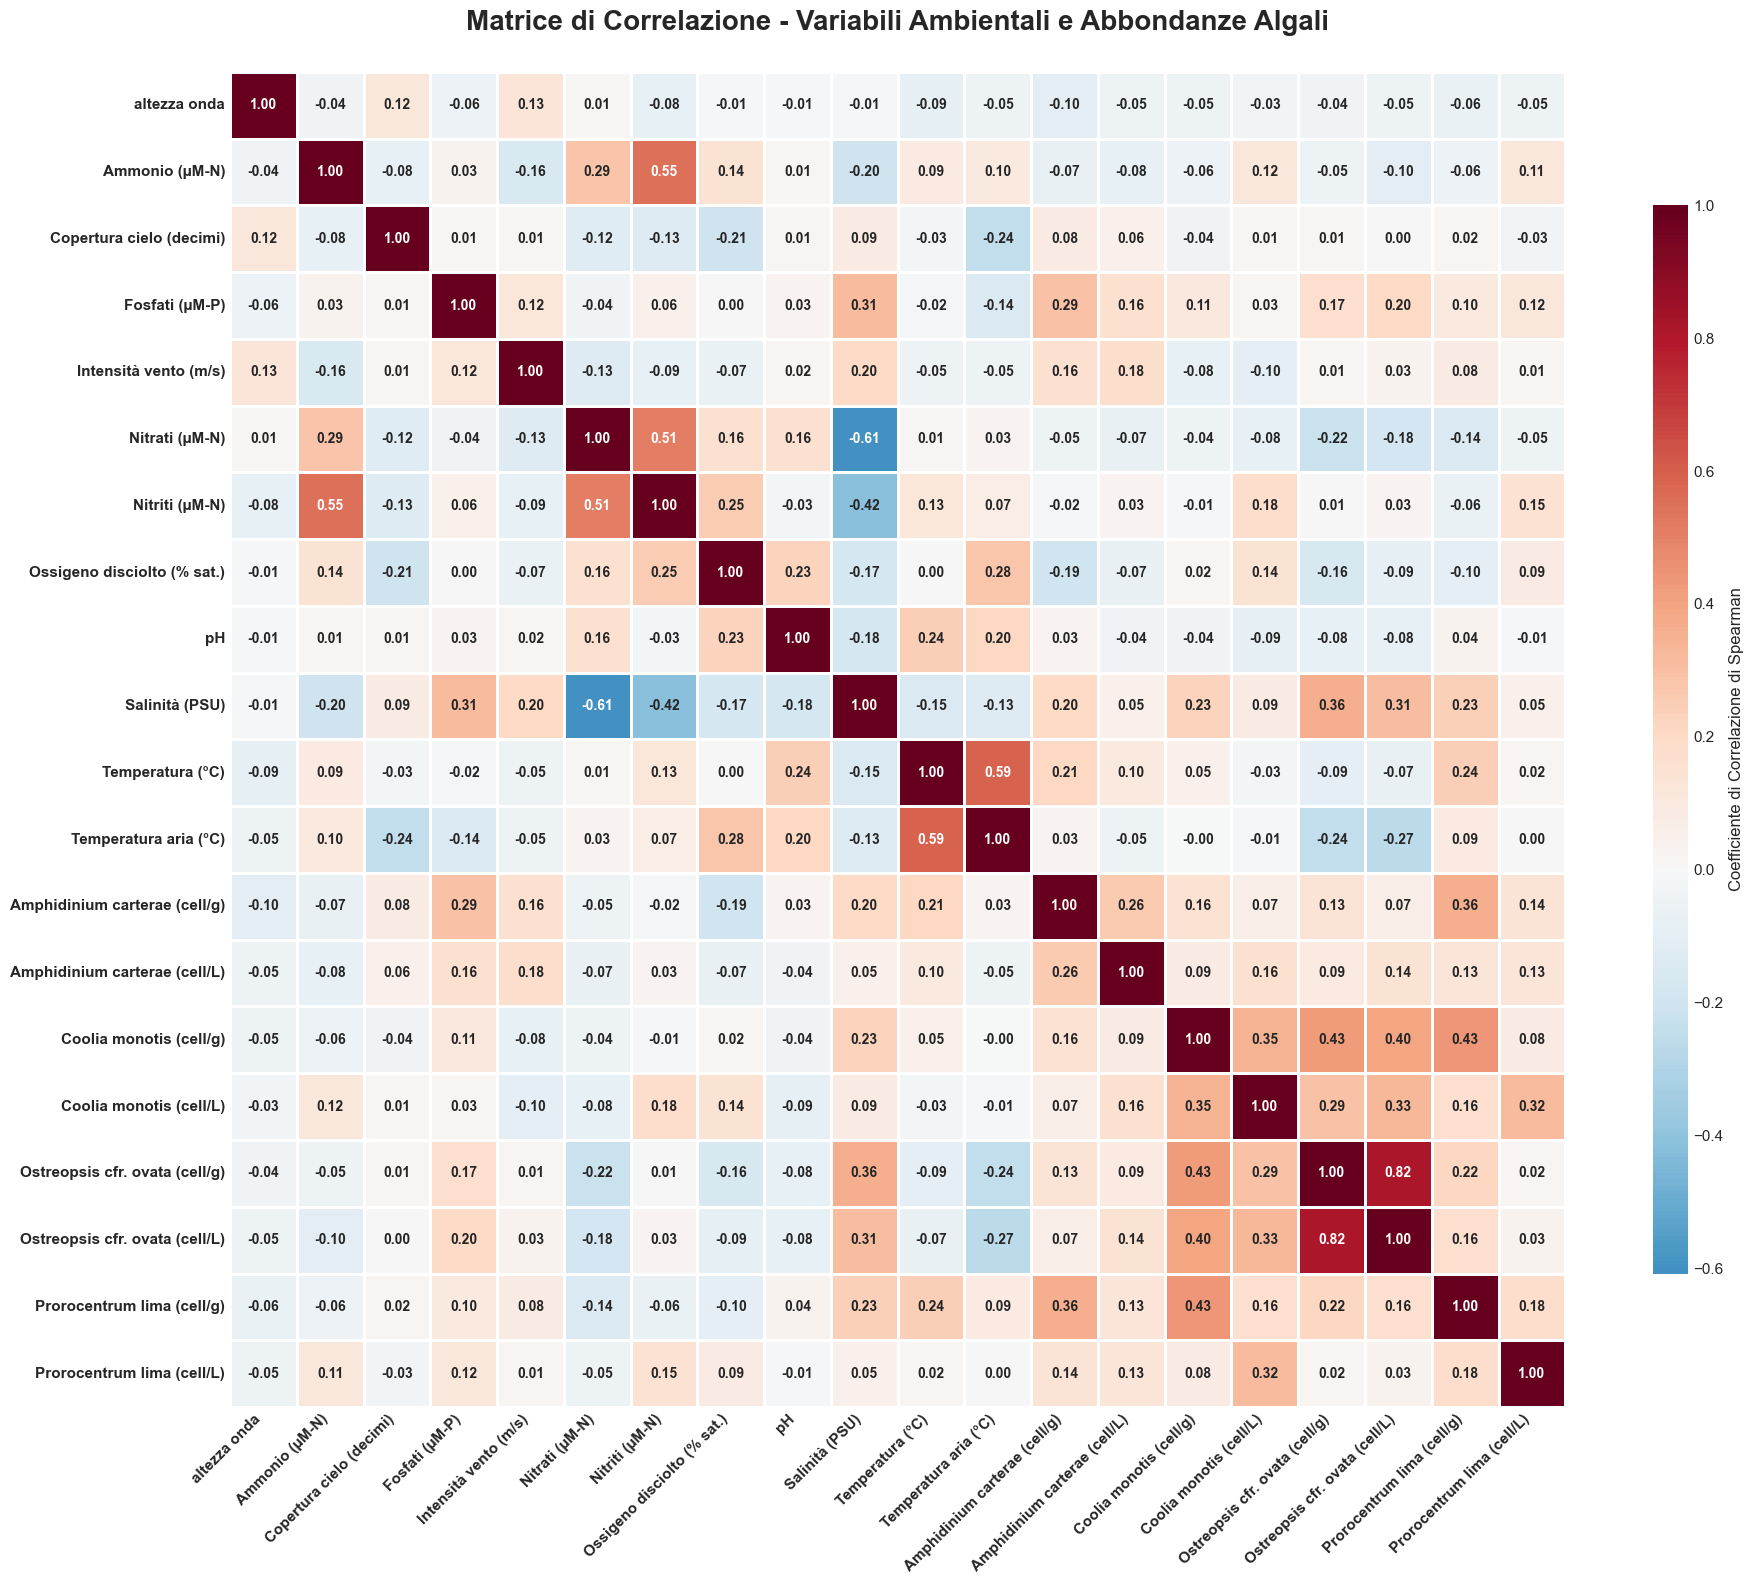

In [227]:
# plot matrice correlazione
plt.figure(figsize=(20, 16))


ax = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="RdBu_r",
    fmt=".2f",
    center=0,
    square=True,
    linewidths=0.8,
    annot_kws={"size": 10, "weight": "bold"},
    cbar_kws={
        "label": "Coefficiente di Correlazione di Spearman",
        "shrink": 0.8,
        "aspect": 30,
    },
)

plt.title(
    "Matrice di Correlazione - Variabili Ambientali e Abbondanze Algali",
    fontsize=20,
    fontweight="bold",
    pad=30,
)

plt.xticks(rotation=45, ha="right", fontsize=11, fontweight="bold")
plt.yticks(rotation=0, fontsize=11, fontweight="bold")

plt.tight_layout()

ax.grid(False)  # rimuovo griglia di default
ax.set_facecolor("white")  # sfondo bianco

plt.show()

<h3>Principali Correlazioni emerse:</h3>
<h4>Correlazioni Positive: </h4>
<ul>
<li>
<strong>Misure della stessa alga:</strong> Le due diverse misurazioni di <em>Ostreopsis cf. ovata</em> sono strettamente collegate tra loro (correlazione di 0.82).
</li>
<li>
<strong>Temperature:</strong> La temperatura dell'aria è legata a quella dell'acqua (0.59), un risultato logico.
</li>
<li>
<strong>Nutrienti e Alghe:</strong> I nitriti tendono ad aumentare insieme all'Ammonio (0.55) e alla concentrazione di <em>Ostreopsis cf. ovata</em> (0.51).
</li>
</ul>
<h4>Correlazione Negativa:</h4>
<ul>
<li>
<strong>Salinità e Nitriti:</strong> La relazione inversa più forte si osserva tra salinità e nitriti (-0.61). Ciò indica che nelle acque più salate si trovano meno nitriti.
</li>
</ul>
<h4>Altre Relazioni Interessanti:</h4>
<ul>
<li>
La salinità è correlata negativamente anche con l'ossigeno disciolto (-0.42).
</li>
<li>
Specie di alghe diverse, come <em>Coolia monotis</em> e <em>Ostreopsis cf. ovata</em>, mostrano una correlazione positiva (0.43), suggerendo che tendono a svilupparsi in condizioni ambientali simili.
</li>
</ul>


Calcoliamo la matrice di p-value per vedere se queste correlazioni risultano anche significative.


In [228]:
# filtro solo colonne numeriche
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

columns_to_exclude = ["ANNO", "MESE", "LATITUDINE", "LONGITUDINE"]
correlation_columns = [col for col in numeric_columns if col not in columns_to_exclude]

df_for_correlation = df[correlation_columns].copy()

# calcolo matrice correlazione e p-value con scipy
corr_spearman, p_value = spearmanr(df_for_correlation, nan_policy="omit")  # ignora nan

# sono array da convertire in df
corr_spearman_df = pd.DataFrame(
    corr_spearman, index=df_for_correlation.columns, columns=df_for_correlation.columns
)
p_value_df = pd.DataFrame(
    p_value, index=df_for_correlation.columns, columns=df_for_correlation.columns
)


# se p-value < 0.05, la correlazione è considerata statist. significativa.
print("\nCorrelazioni statisticamente significative (p < 0.05):")
significant_correlations = corr_spearman_df[p_value_df < 0.05]
print(significant_correlations)


Correlazioni statisticamente significative (p < 0.05):
                               altezza onda  Ammonio (µM-N)  \
altezza onda                       1.000000             NaN   
Ammonio (µM-N)                          NaN        1.000000   
Copertura cielo (decimi)           0.118216             NaN   
Fosfati (µM-P)                          NaN             NaN   
Intensità vento (m/s)              0.129757       -0.159922   
Nitrati (µM-N)                          NaN        0.286247   
Nitriti (µM-N)                          NaN        0.553449   
Ossigeno disciolto (% sat.)             NaN        0.143066   
pH                                      NaN             NaN   
Salinità (PSU)                          NaN       -0.202332   
Temperatura (°C)                        NaN             NaN   
Temperatura aria (°C)                   NaN        0.099520   
Amphidinium carterae_cell_gr      -0.103696             NaN   
Amphidinium carterae_cell_l             NaN             NaN   

Creazione heatmap per visualizzare al meglio le correlazioni statisticamente significative.


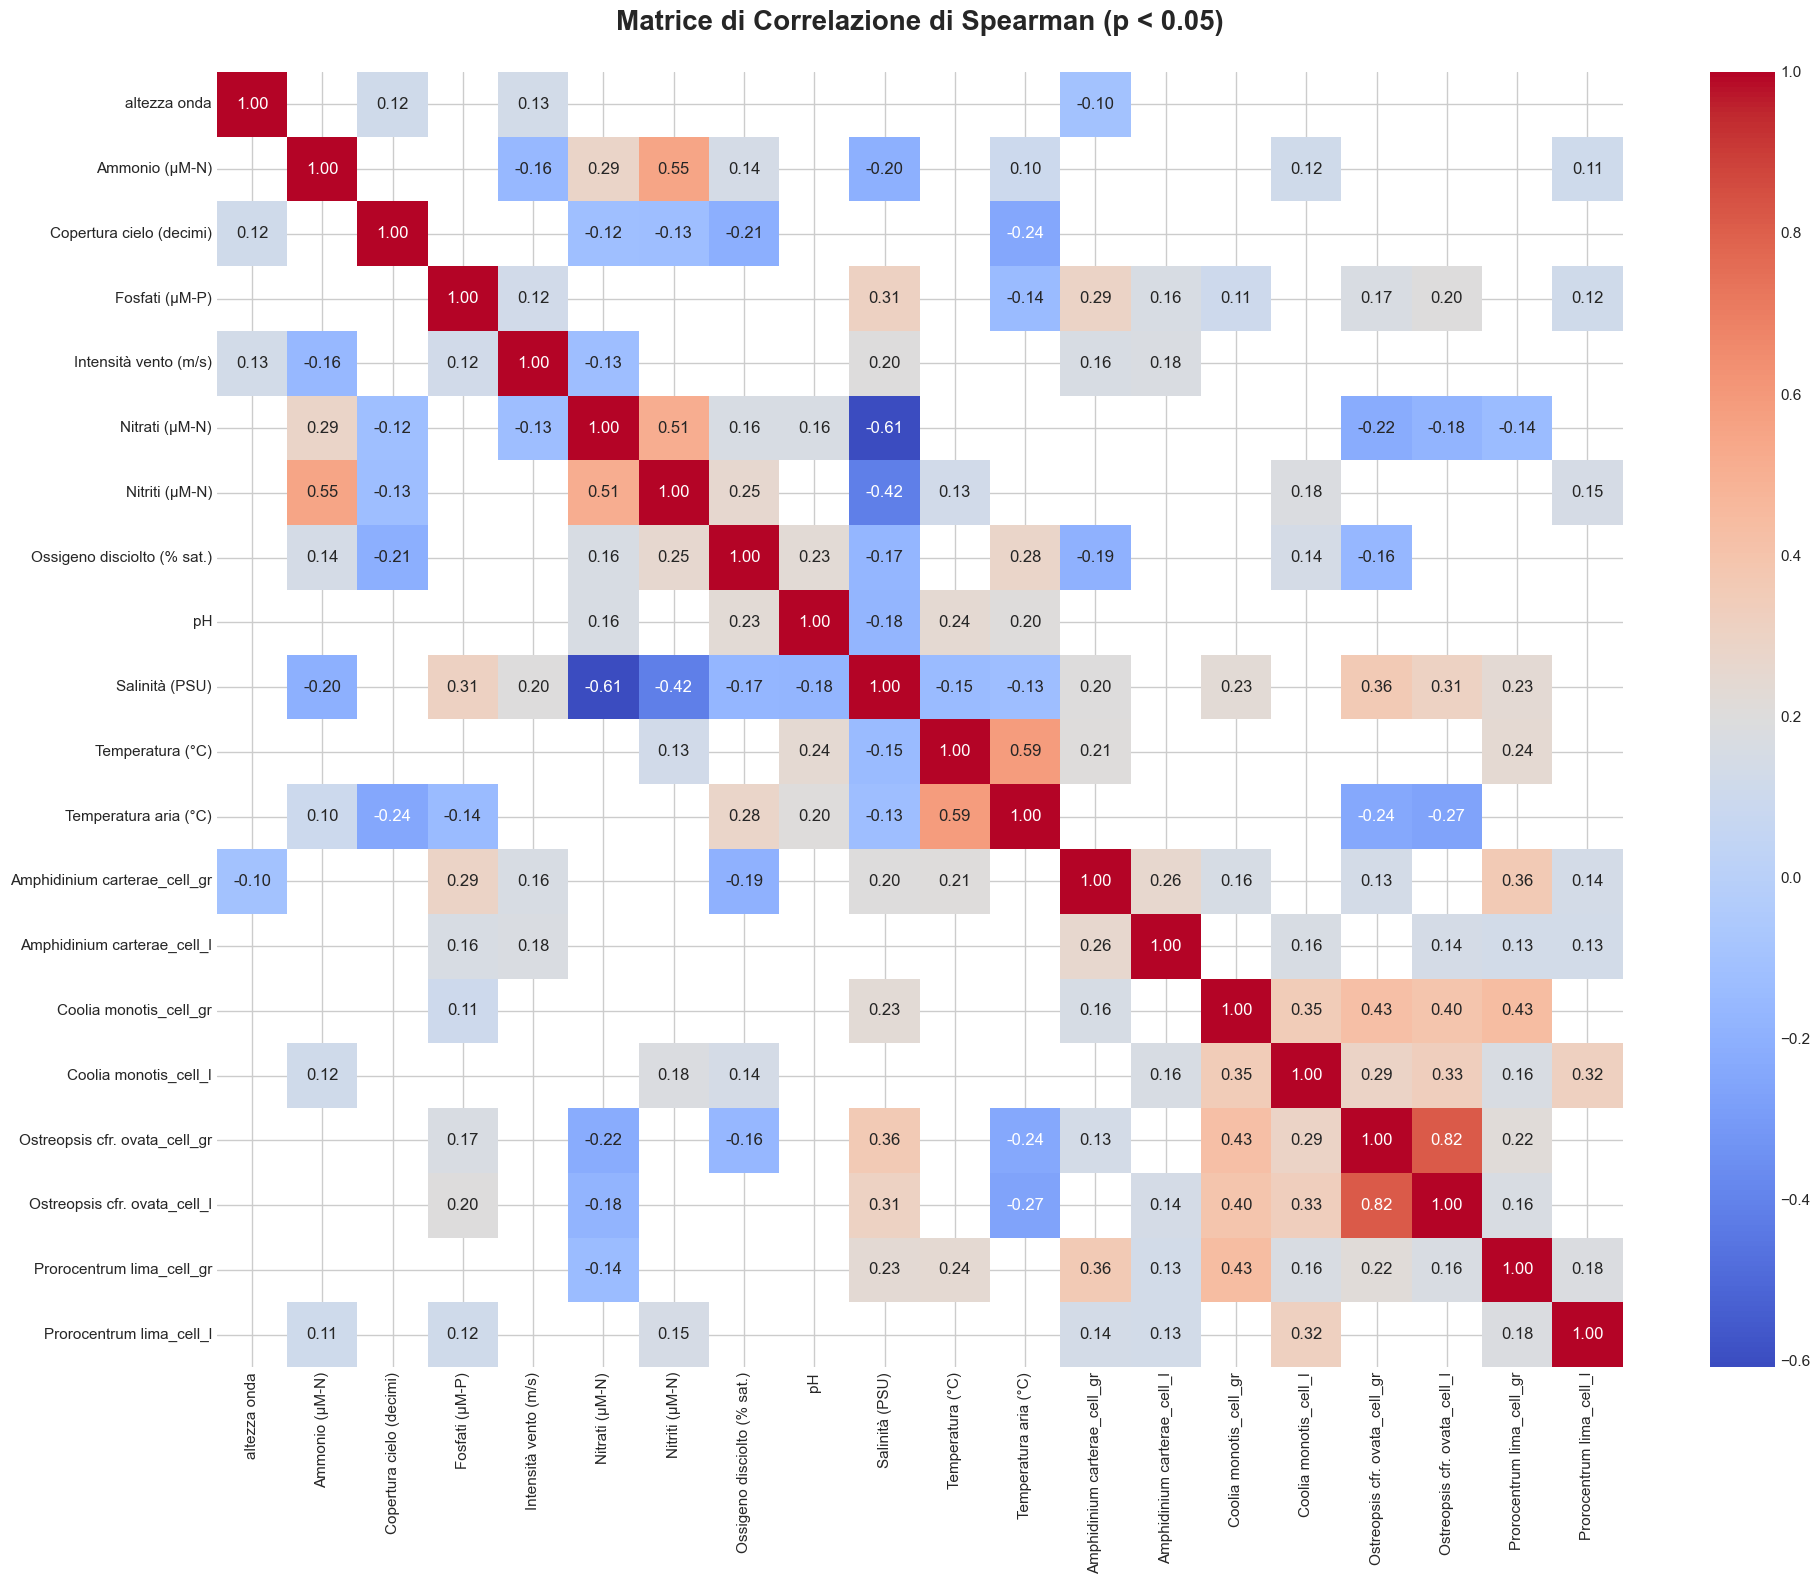

In [229]:
# plot matrice correlazione con p-value

plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_spearman_df,
    annot=True,  # Annotate cells with correlation values
    fmt=".2f",  # Format annotations to two decimal places
    cmap="coolwarm",  # Use a diverging colormap
    mask=(p_value_df >= 0.05),
)  # Mask cells where p-value is >= 0.05
plt.title(
    "Matrice di Correlazione di Spearman (p < 0.05)",
    fontsize=20,
    fontweight="bold",
    pad=30,
)


plt.tight_layout()

ax.grid(False)  # rimuovo griglia di default
ax.set_facecolor("white")  # sfondo bianco

plt.show()

Tutte le correlazioni forti della matrice di correlazione di Spearman risultano statisticamente significative.


<h3>Analisi Univariata</h3>


Vogliamo vedere come si distribuiscono i parametri ambientali e come si distribuiscono le specie algali considerate.


Variabili ambientali:


In [230]:
# definisco le variabili ambientali, chimico-fisiche
env_variables = [
    "Temperatura (°C)",
    "Salinità (PSU)",
    "Nitrati (µM-N)",
    "Nitriti (µM-N)",
    "Ossigeno disciolto (% sat.)",
    "Ammonio (µM-N)",
    "Fosfati (µM-P)",
    "Temperatura aria (°C)",
    "Copertura cielo (decimi)",
    "Intensità vento (m/s)",
    "pH",
    "altezza onda",
    "direzione vento",
]

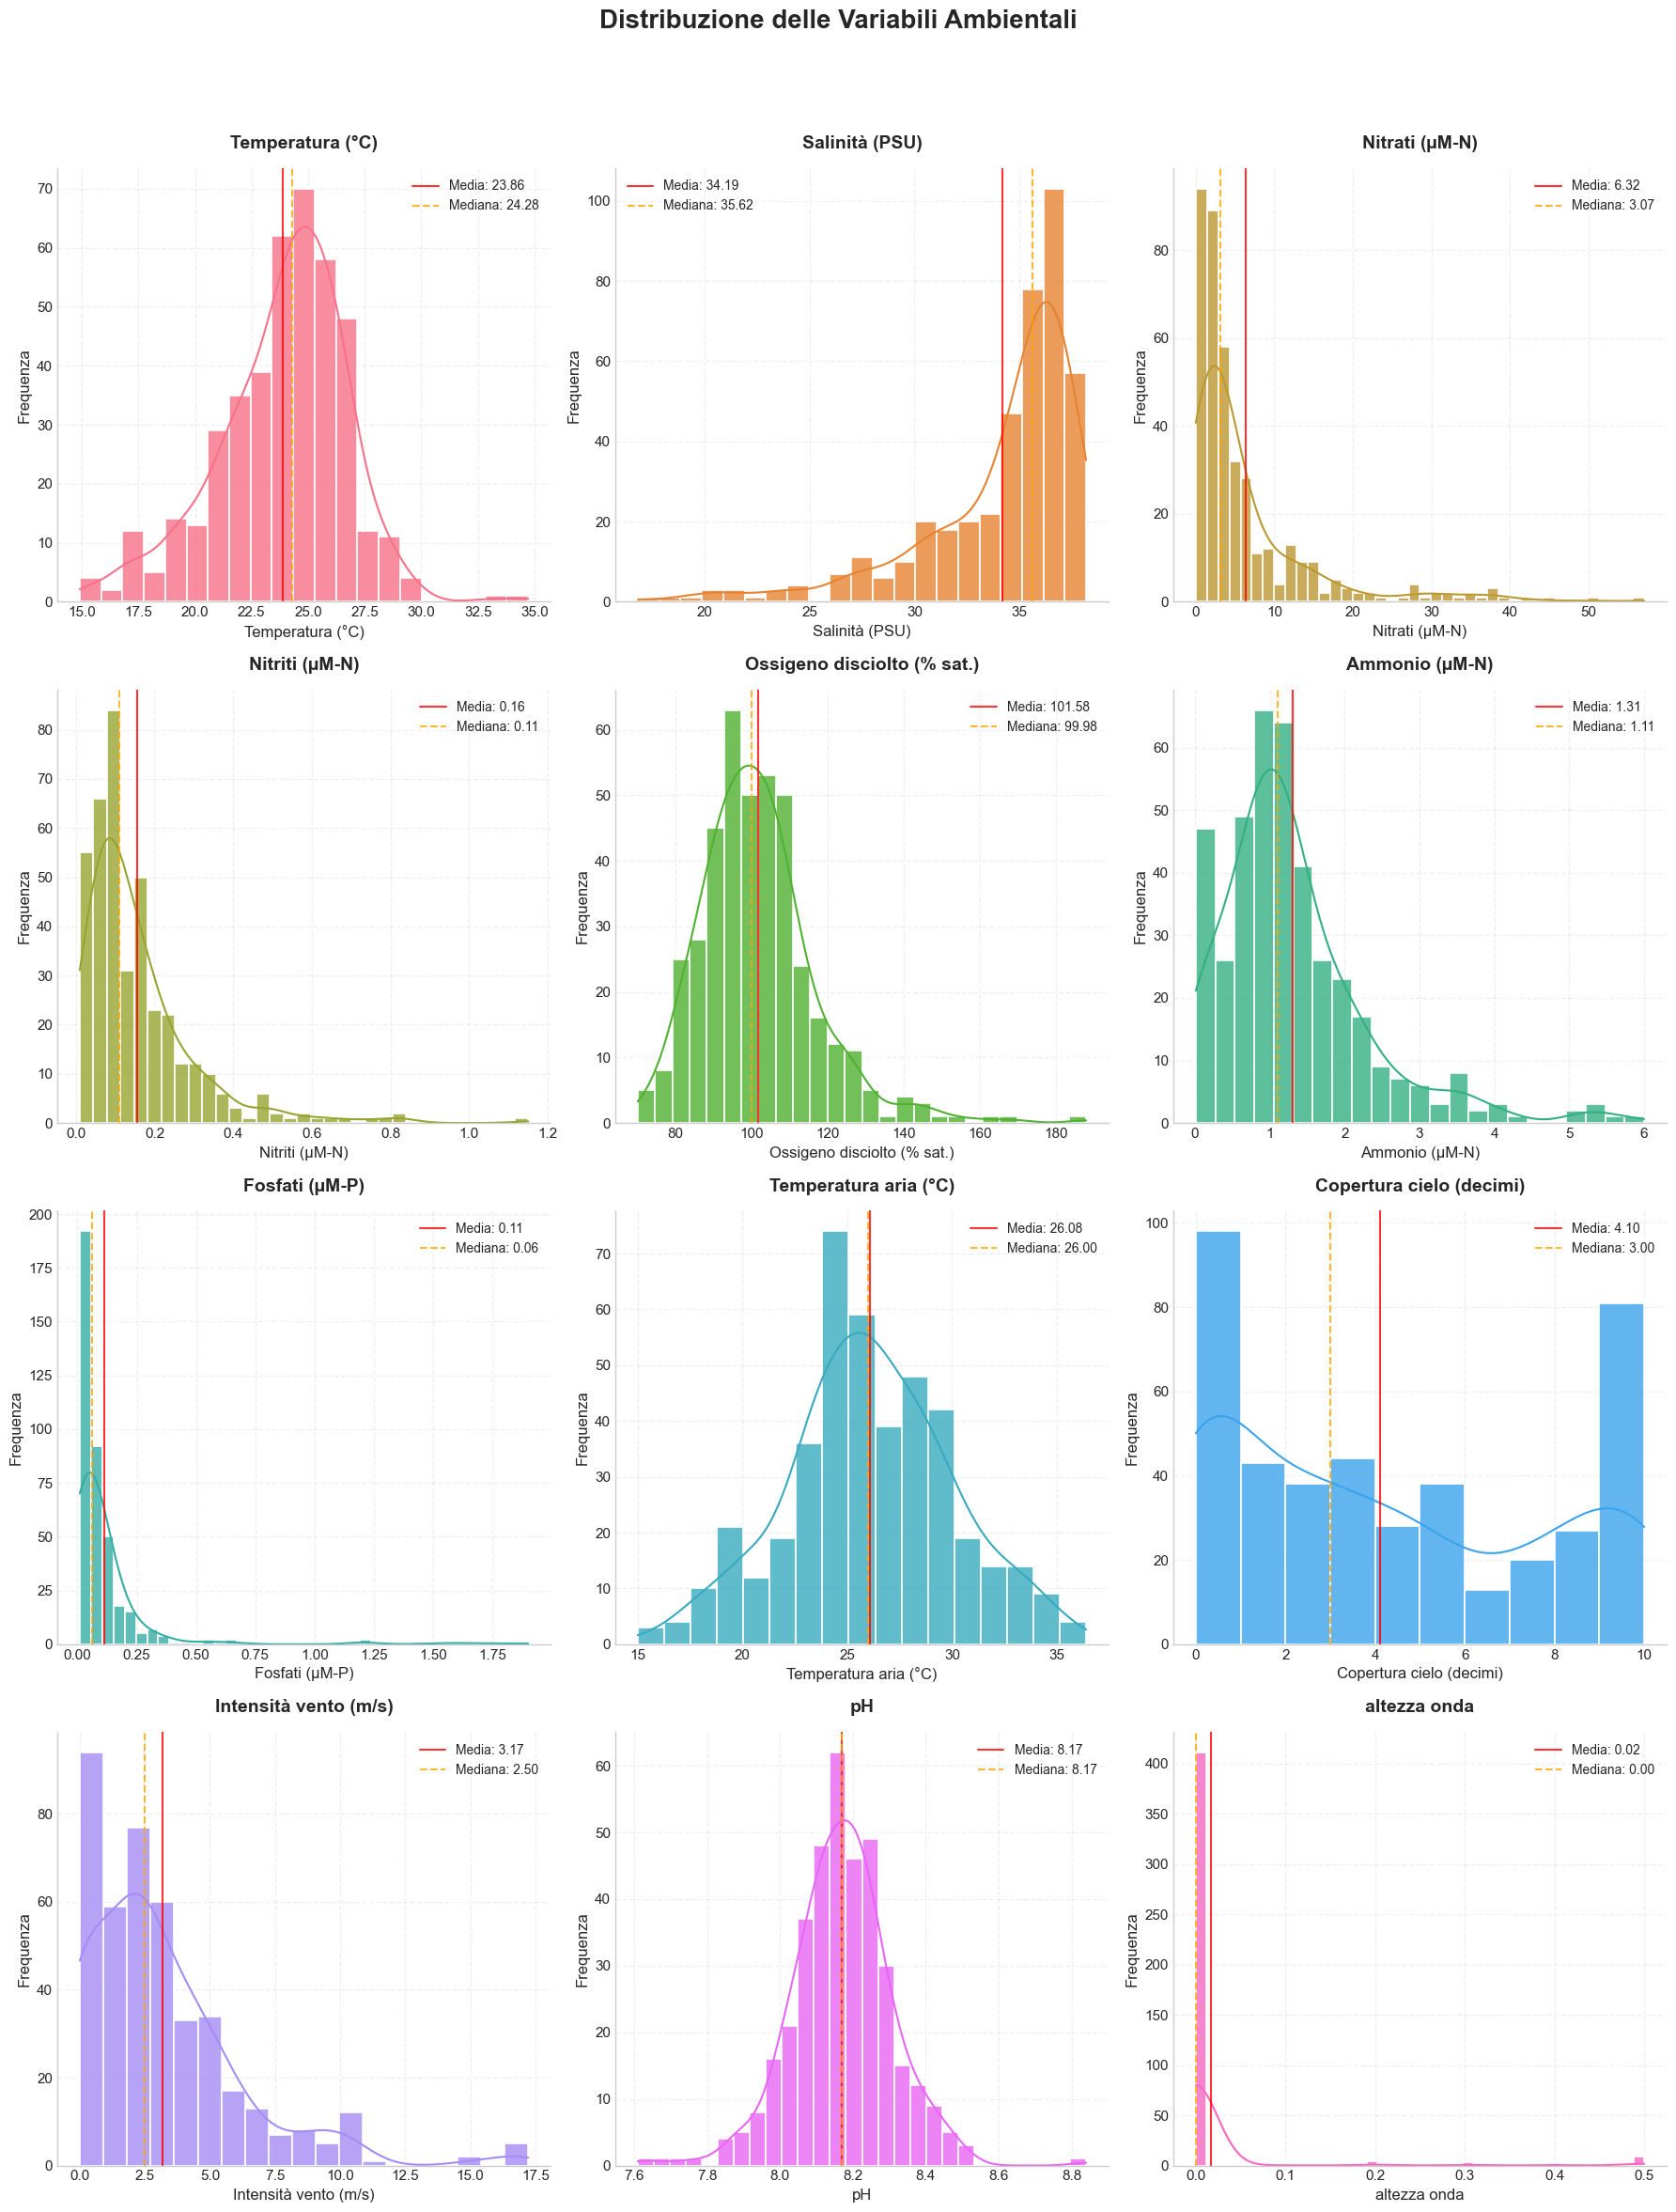

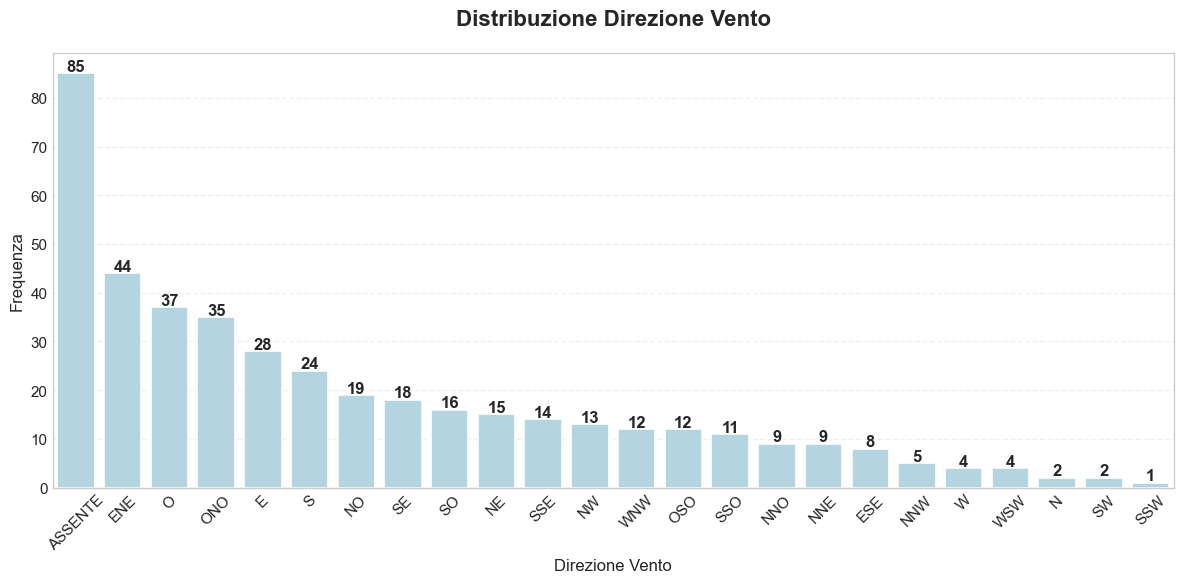

In [231]:
# filtro solo variabili numeriche (quindi tutte tranne direzione vento)
numeric_vars = [var for var in env_variables if var not in ["direzione vento"]]

# creo dimensioni griglia
n_vars = len(numeric_vars)
n_cols = 3  # 3 colonne per riga
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
fig.suptitle(
    "Distribuzione delle Variabili Ambientali", fontsize=20, fontweight="bold", y=0.98
)

# se abbiamo più di una riga
if n_rows > 1:
    axes = axes.flatten()
elif n_cols == 1:
    axes = [axes]

# palette di colori
colors = sns.color_palette("husl", n_vars)

for i, var in enumerate(numeric_vars):
    ax = axes[i]

    # creazione istogramma con KDE
    sns.histplot(
        data=df,
        x=var,
        kde=True,
        ax=ax,
        color=colors[i],
        alpha=0.8,
        edgecolor="white",
        linewidth=1.2,
    )

    ax.set_title(f"{var}", fontsize=14, fontweight="bold", pad=15)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel("Frequenza", fontsize=12)
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Aggiungi statistiche di base
    mean_val = df[var].mean()
    median_val = df[var].median()
    ax.axvline(mean_val, color="red", alpha=0.8, label=f"Media: {mean_val:.2f}")
    ax.axvline(
        median_val,
        color="orange",
        linestyle="--",
        alpha=0.8,
        label=f"Mediana: {median_val:.2f}",
    )
    ax.legend(fontsize=10)

# rimuovi subplot vuoti nel caso
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # così non si sovrappongono i titoli
plt.show()


# plot separato per variabile categorica (direzione vento)
if "direzione vento" in env_variables:
    plt.figure(figsize=(12, 6))
    direzione_counts = df["direzione vento"].value_counts()

    sns.barplot(
        x=direzione_counts.index,
        y=direzione_counts.values,
        edgecolor="white",
        linewidth=1.2,
        color="lightblue",
    )

    plt.title("Distribuzione Direzione Vento", fontsize=16, fontweight="bold", pad=20)
    plt.xlabel("Direzione Vento", fontsize=12)
    plt.ylabel("Frequenza", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis="y", linestyle="--")

    # Aggiungi valori sulle barre
    for i, v in enumerate(direzione_counts.values):
        plt.text(i, v + 0.5, str(v), ha="center", fontweight="bold")

    plt.tight_layout()
    plt.show()

Per analizzare la direzione del vento, una variabile categorica, abbiamo utilizzato un grafico specifico chiamato "rosa dei venti". Prima di crearlo, aabbiamo rimosso tutte le misurazioni in cui mancava questa informazione (ASSENTE). Il risultato è una visualizzazione chiara che mostra non solo quali sono le direzioni del vento più frequenti se presente, ma anche a quale velocità soffia il vento in quelle direzioni.


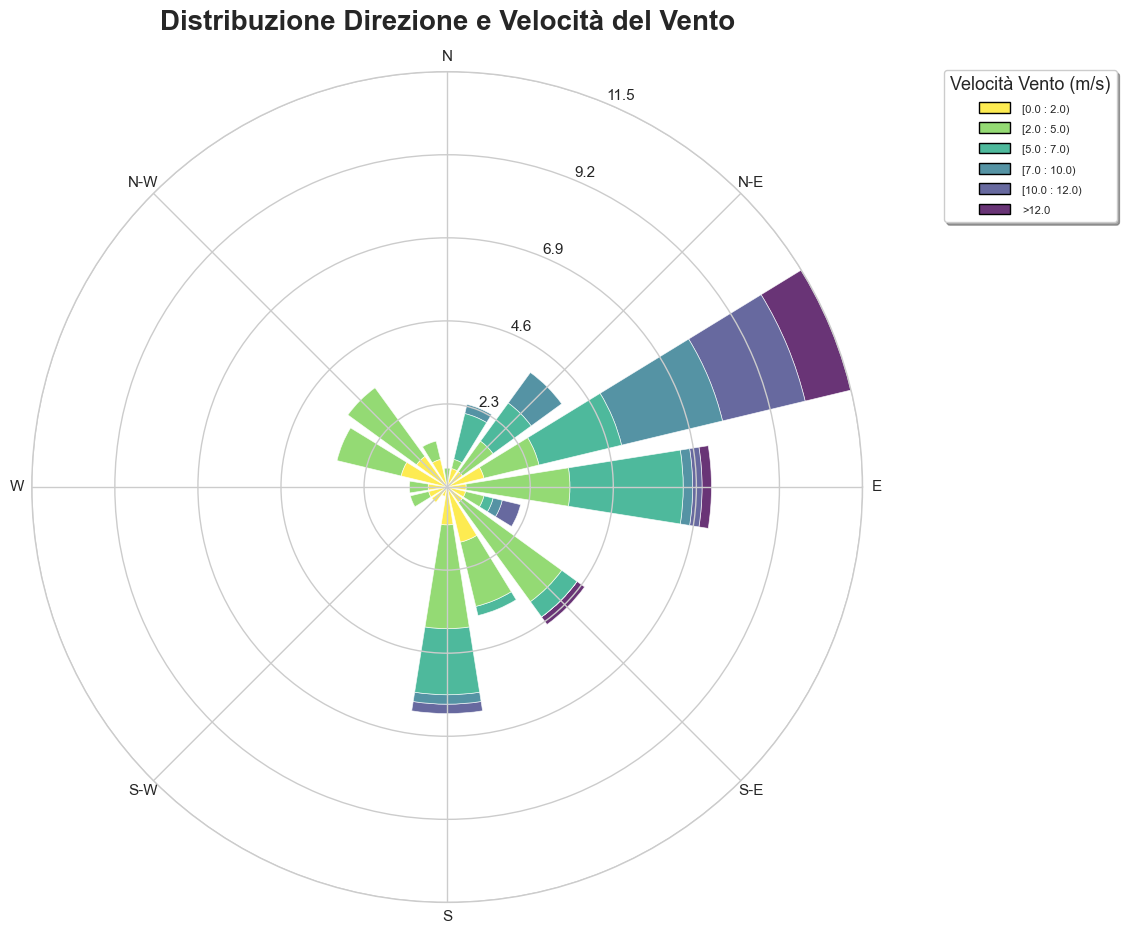

In [232]:
df_wind = df.copy()
df_wind = df_wind[df_wind["direzione vento"] != "ASSENTE"].copy()

# mappatura direzione vento in gradi
dir_map = {
    "N": 0,
    "NNE": 22.5,
    "NE": 45,
    "ENE": 67.5,
    "E": 90,
    "ESE": 112.5,
    "SE": 135,
    "SSE": 157.5,
    "S": 180,
    "SSW": 202.5,
    "SW": 225,
    "WSW": 247.5,
    "W": 270,
    "WNW": 292.5,
    "NW": 315,
    "NNW": 337.5,
}
df_wind["direzione_gradi"] = df_wind["direzione vento"].map(dir_map)

# grafico rosa dei venti
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="windrose")

wind_speed_bins = [0, 2, 5, 7, 10, 12]

# colormap
colormap = plt.colormaps.get_cmap("viridis_r")

ax.bar(
    df_wind["direzione_gradi"],
    df_wind["Intensità vento (m/s)"],
    normed=True,
    opening=0.8,
    edgecolor="white",
    linewidth=0.5,
    bins=wind_speed_bins,
    cmap=colormap,
    alpha=0.8,
)

# legenda
legend = ax.set_legend(
    title="Velocità Vento (m/s)",
    loc="upper left",
    bbox_to_anchor=(1.1, 1),
    fontsize=11,
    title_fontsize=13,
    frameon=True,
    fancybox=True,
    shadow=True,
)


ax.set_title(
    "Distribuzione Direzione e Velocità del Vento",
    fontsize=20,
    fontweight="bold",
    pad=30,
)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # così non si sovrappongono i titoli
plt.show()

Variabili Biologiche


Come si distribuiscono le varie specie algali? <br> Qual è la specie più abbondante campionata in assoluto per counts e per cell/gr, cell/L?


<h4>Perché si usano due diverse unità di misura per le alghe (Cell/L e Cell/g)</h4>
<p>È fondamentale distinguere tra queste due misurazioni perché ci dicono dove si trovano le alghe e a cosa serve quel dato:</p>
<ul>
<li>
<strong>Cell/L (Cellule per Litro) misura le alghe libere NELL'ACQUA.</strong>
<p>Questa unità indica la concentrazione di alghe sospese nella colonna d'acqua (plancton). È il dato usato principalmente per:</p>
<ul>
<li>Monitorare la qualità generale dell'acqua.</li>
<li>Valutare il rischio immediato di una fioritura algale per la salute (es. per la balneazione).</li>
</ul>
</li>
<br>
<li>
<strong>Cell/g (Cellule per Grammo) misura le alghe presenti SU SUPERFICI o NEI TESSUTI.</strong>
<p>Questa unità indica la concentrazione di alghe che vivono attaccate a superfici solide (rocce, fondale) o che si accumulano in altri organismi. È utile per:</p>
<ul>
<li>Prevedere future fioriture analizzando la presenza di alghe nei sedimenti.</li>
<li>Valutare la sicurezza alimentare, controllando la contaminazione in pesci e molluschi.</li>
<li>Condurre studi scientifici specifici sulla biologia delle alghe.</li>
</ul>
</li>
</ul>


In [233]:
# colonne con abbondanze algali cell/g e cell/l
algae_bentonic = [
    "Amphidinium carterae_cell_gr",
    "Coolia monotis_cell_gr",
    "Ostreopsis cfr. ovata_cell_gr",
    "Prorocentrum lima_cell_gr",
]

algae_planctonic = [
    "Amphidinium carterae_cell_l",
    "Coolia monotis_cell_l",
    "Ostreopsis cfr. ovata_cell_l",
    "Prorocentrum lima_cell_l",
]

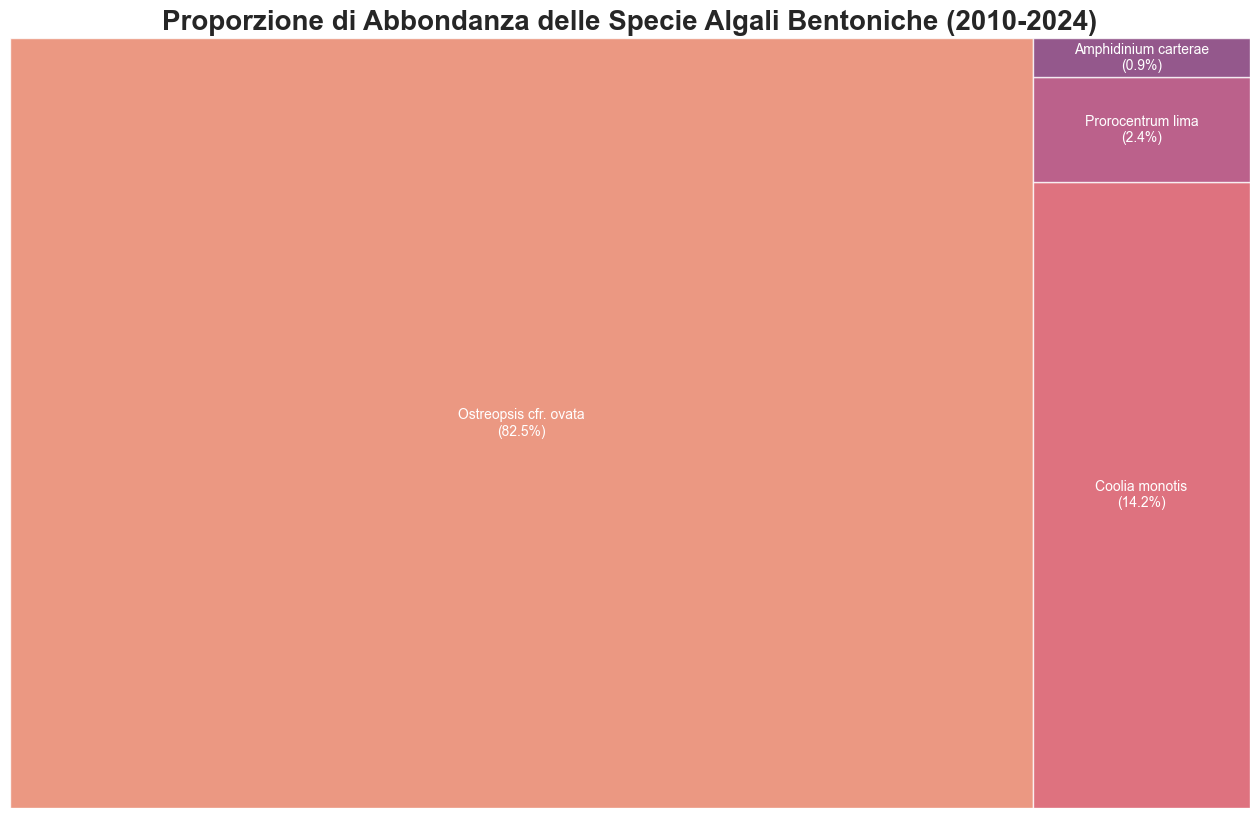

In [234]:
# treemap abbondanze bentoniche

tot_abundance_benthos = df[algae_bentonic].sum().sort_values(ascending=False)
cleaned_labels_benthos = tot_abundance_benthos.index.str.replace(
    "_cell_gr", "", regex=False
)
tot_abundance_benthos.index = cleaned_labels_benthos

# preparazione dati per treemap
sizes = tot_abundance_benthos.values
# etichette con nome specie e abbondanza (in %)
total_sum = tot_abundance_benthos.sum()
labels = [
    f"{label}\n({(value/total_sum):.1%})"
    for label, value in tot_abundance_benthos.items()
]


plt.figure(figsize=(16, 10))
sns.set_theme(style="white")
colors = sns.color_palette("flare", len(sizes))

squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.8,
    text_kwargs={"fontsize": 10, "color": "white"},
)

plt.title(
    "Proporzione di Abbondanza delle Specie Algali Bentoniche (2010-2024)",
    fontsize=20,
    weight="bold",
)
plt.axis("off")  # rimuove assi
plt.show()

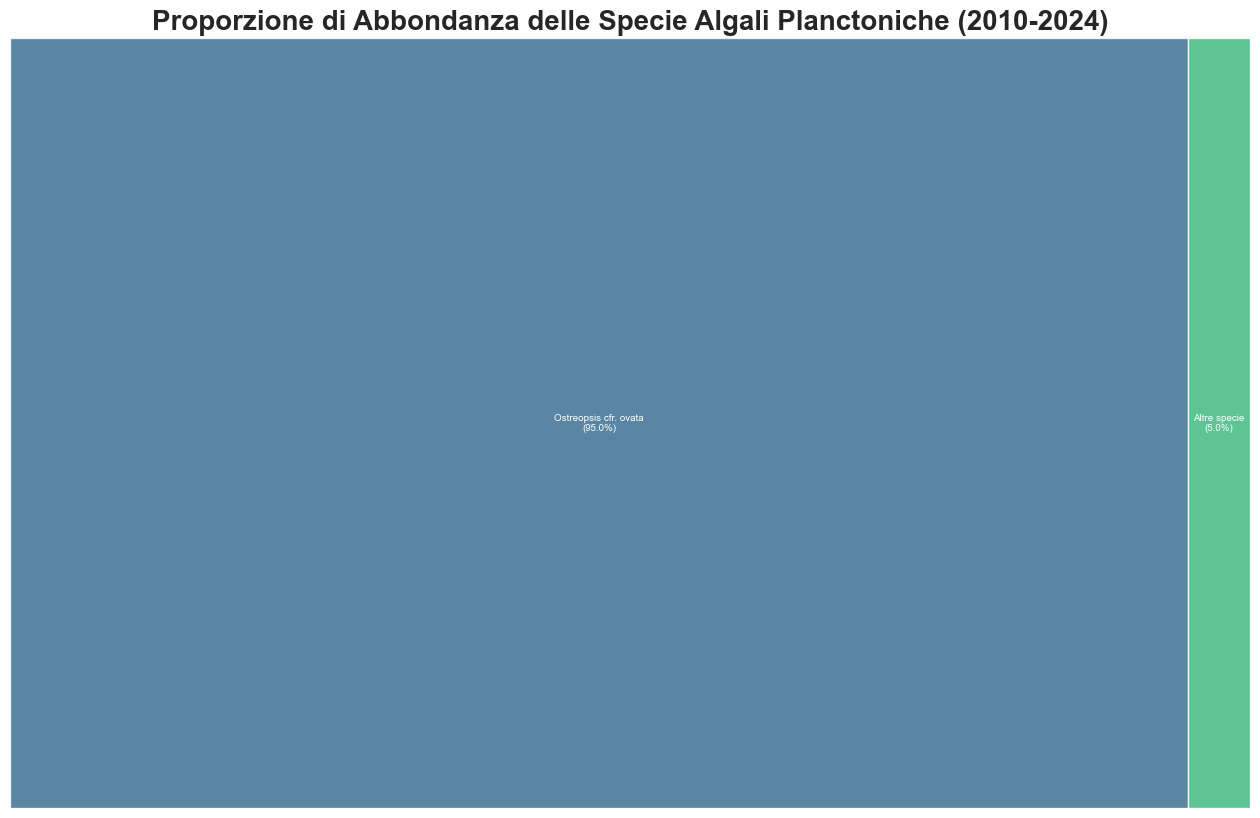

In [235]:
# grafico per abbondanze planctoniche
tot_abundance_planctonic = df[algae_planctonic].sum().sort_values(ascending=False)

cleaned_labels_planctonic = tot_abundance_planctonic.index.str.replace(
    "_cell_l", "", regex=False
)
tot_abundance_planctonic.index = cleaned_labels_planctonic

# imposto una soglia per migliore visualizzazione
total_sum = tot_abundance_planctonic.sum()
percentages = (tot_abundance_planctonic / total_sum) * 100
threshold = 3.0  # %
above_threshold = tot_abundance_planctonic[percentages >= threshold]
below_threshold = tot_abundance_planctonic[percentages < threshold]

if not below_threshold.empty:
    other_sum = pd.Series({"Altre specie": below_threshold.sum()})
    plot_data = pd.concat([above_threshold, other_sum])
    # mette insieme le specie sopra soglia con altre
else:
    plot_data = above_threshold

sizes = plot_data.values
total_for_labels = plot_data.sum()
labels = [
    f"{label}\n({(value/total_for_labels)*100:.1f}%)"
    for label, value in plot_data.items()
]


plt.figure(figsize=(16, 10))
sns.set_theme(style="white")

colors = sns.color_palette("viridis", len(sizes))

squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.8,
    text_kwargs={"fontsize": 7, "color": "white"},
)

plt.title(
    "Proporzione di Abbondanza delle Specie Algali Planctoniche (2010-2024)",
    fontsize=20,
    weight="bold",
)
plt.axis("off")
plt.show()

O. ovata si rivela essere la specie più presente, almeno per quanto riguarda l'abbondanza totale, quindi per il numero di cell/gr e cell/L. <br> Vedremo che per quanto riguarda la sola presenza della specie le cose cambiano.


<h3>Analisi bivariata</h3>


C'è correlazione tra l'abbondanza di specie e qualche fattore ambientale?


Proviamo a vedere come cambia l'abbondanza di O. ovata (benthos) in base alle diverse variabili ambientali.


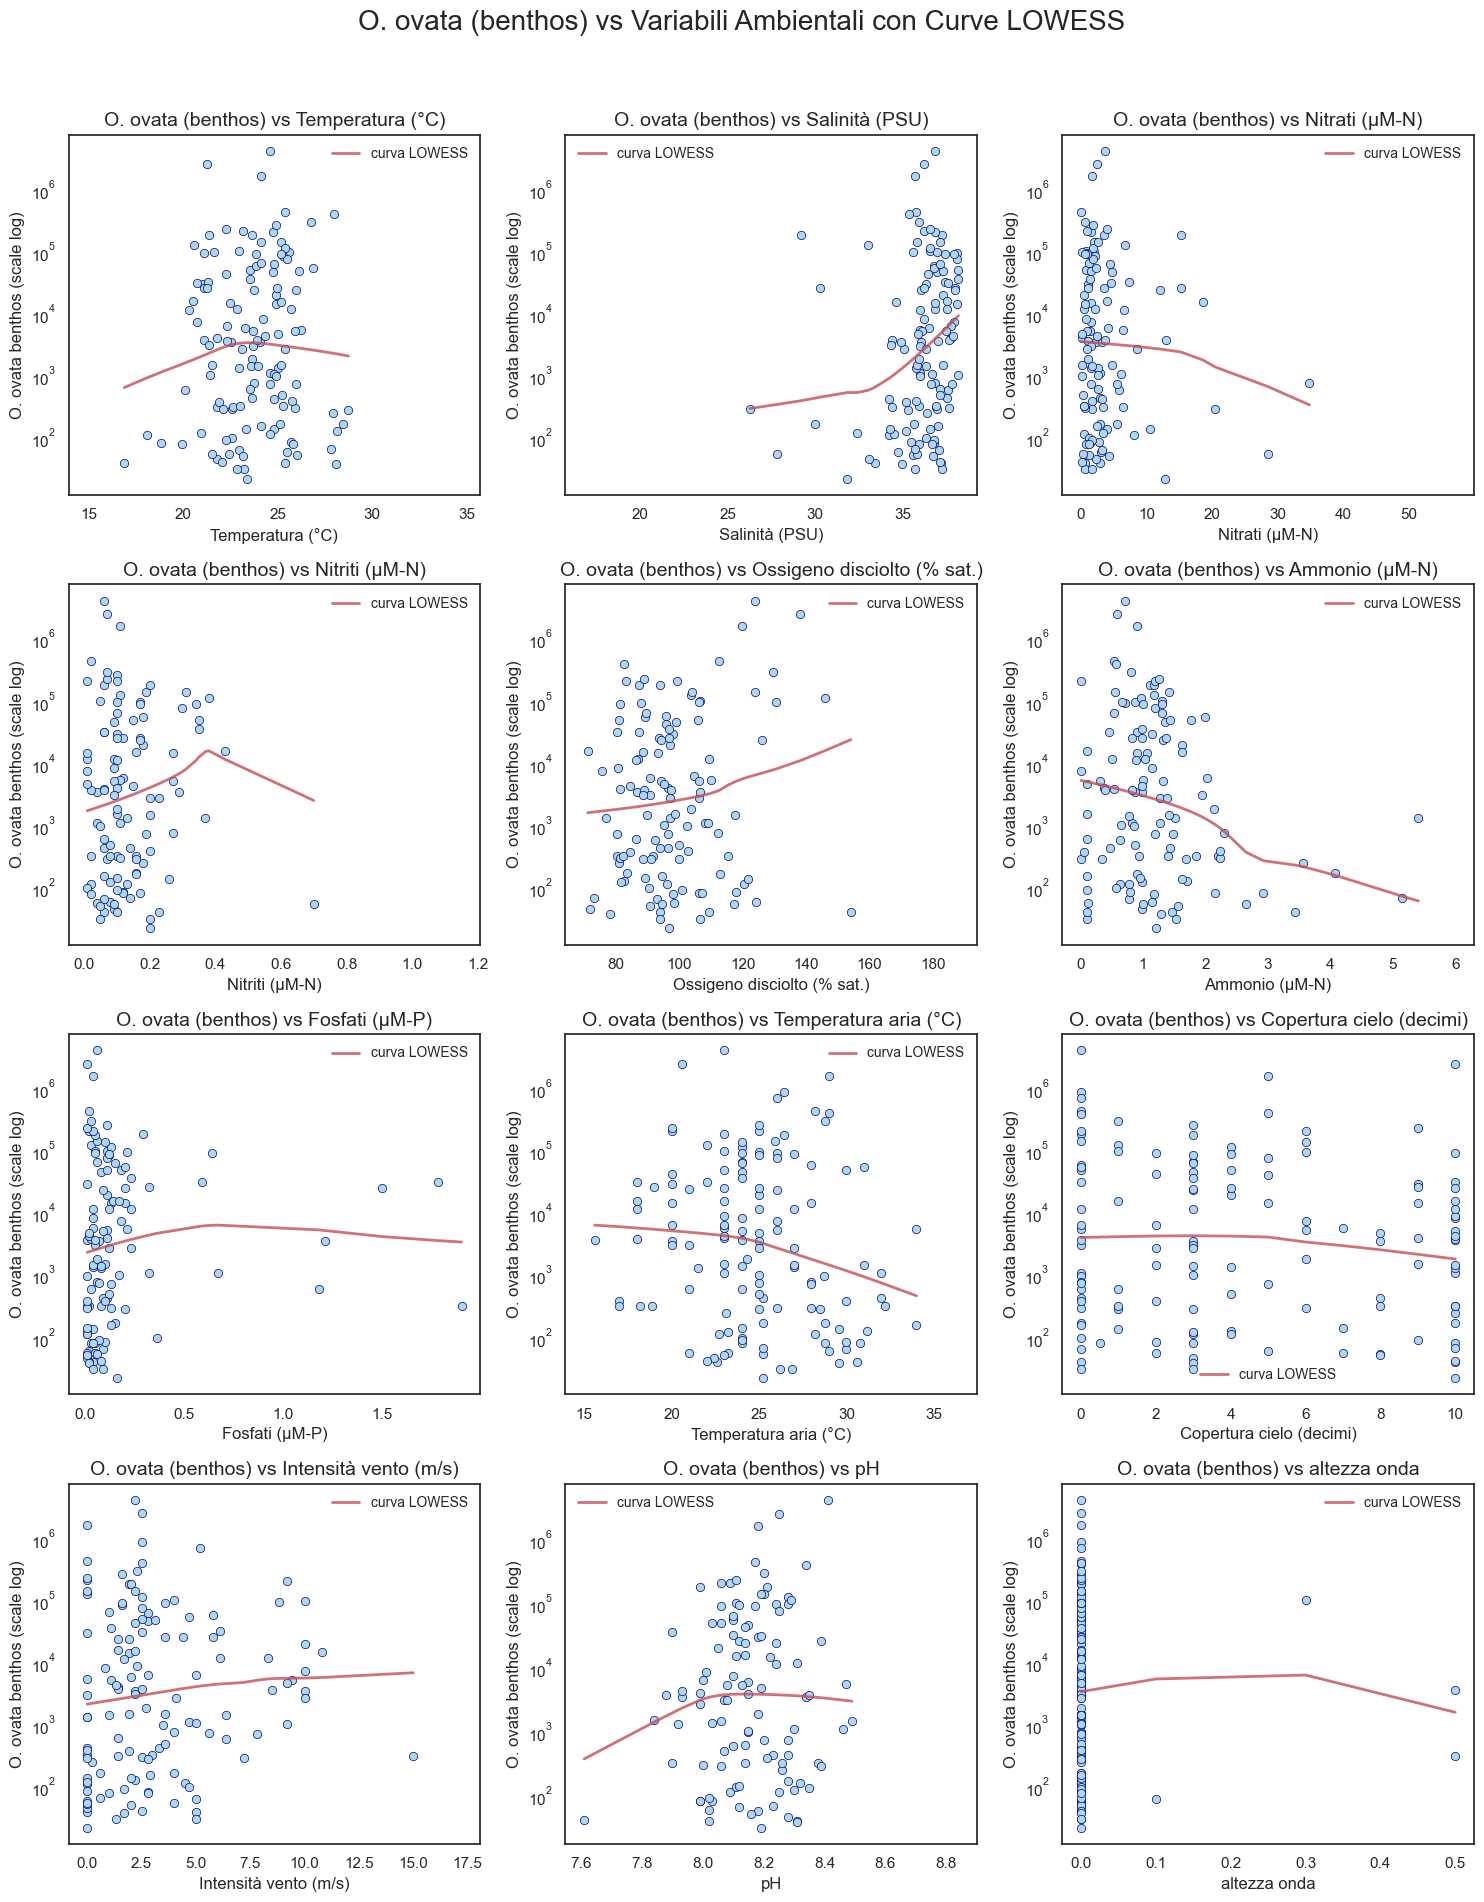

In [236]:
# O. ovata cell gr vs variabili ambientali
O_ovata_benthos = df["Ostreopsis cfr. ovata_cell_gr"]


# per maggiore chiarezza meglio mettere tutte le variabili in un unico grafico
# subplot

n_vars = len(numeric_vars)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.suptitle(
    "O. ovata (benthos) vs Variabili Ambientali con Curve LOWESS", fontsize=20, y=0.95
)

axes = axes.flatten() if n_vars > 1 else [axes]

for i, var in enumerate(numeric_vars):
    # rimuovo nan e valori <= 0 per lowess
    mask = ~(pd.isna(df[var]) | pd.isna(O_ovata_benthos) | (O_ovata_benthos <= 0))
    x_clean = df[var][mask]
    y_clean = O_ovata_benthos[mask]

    sns.scatterplot(
        x=df[var],
        y=O_ovata_benthos,
        ax=axes[i],
        color="lightblue",
        edgecolor="darkblue",
        linewidth=0.5,
    )

    if len(x_clean) > 5:
        y_log = np.log10(y_clean)

        sort_idx = np.argsort(x_clean)
        x_sorted = x_clean.iloc[sort_idx]
        y_log_sorted = y_log.iloc[sort_idx]

        # in base a frac la linea LOWESS è più o meno liscia
        lowess_result = lowess(y_log_sorted, x_sorted, frac=1, return_sorted=True)
        x_smooth = lowess_result[:, 0]
        y_smooth_log = lowess_result[:, 1]
        y_smooth = 10**y_smooth_log  # trasforma indietro dalla scala log

        # plotta la linea LOWESS
        axes[i].plot(
            x_smooth, y_smooth, "r-", linewidth=2, alpha=0.8, label="curva LOWESS"
        )
        axes[i].legend(fontsize=10)

    axes[i].set_title(f"O. ovata (benthos) vs {var}", fontsize=14)
    axes[i].set_yscale("log")  # per distribuzioni log-normali
    axes[i].set_ylabel("O. ovata benthos (scale log)")
    axes[i].set_xlabel(var)

for i in range(n_vars, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # per evitare sovrapposizione del titolo
plt.show()

Plottiamo in un unico grafico tutte le specie bentoniche assegnando ad ogni specie un colore ed una forma diversi.


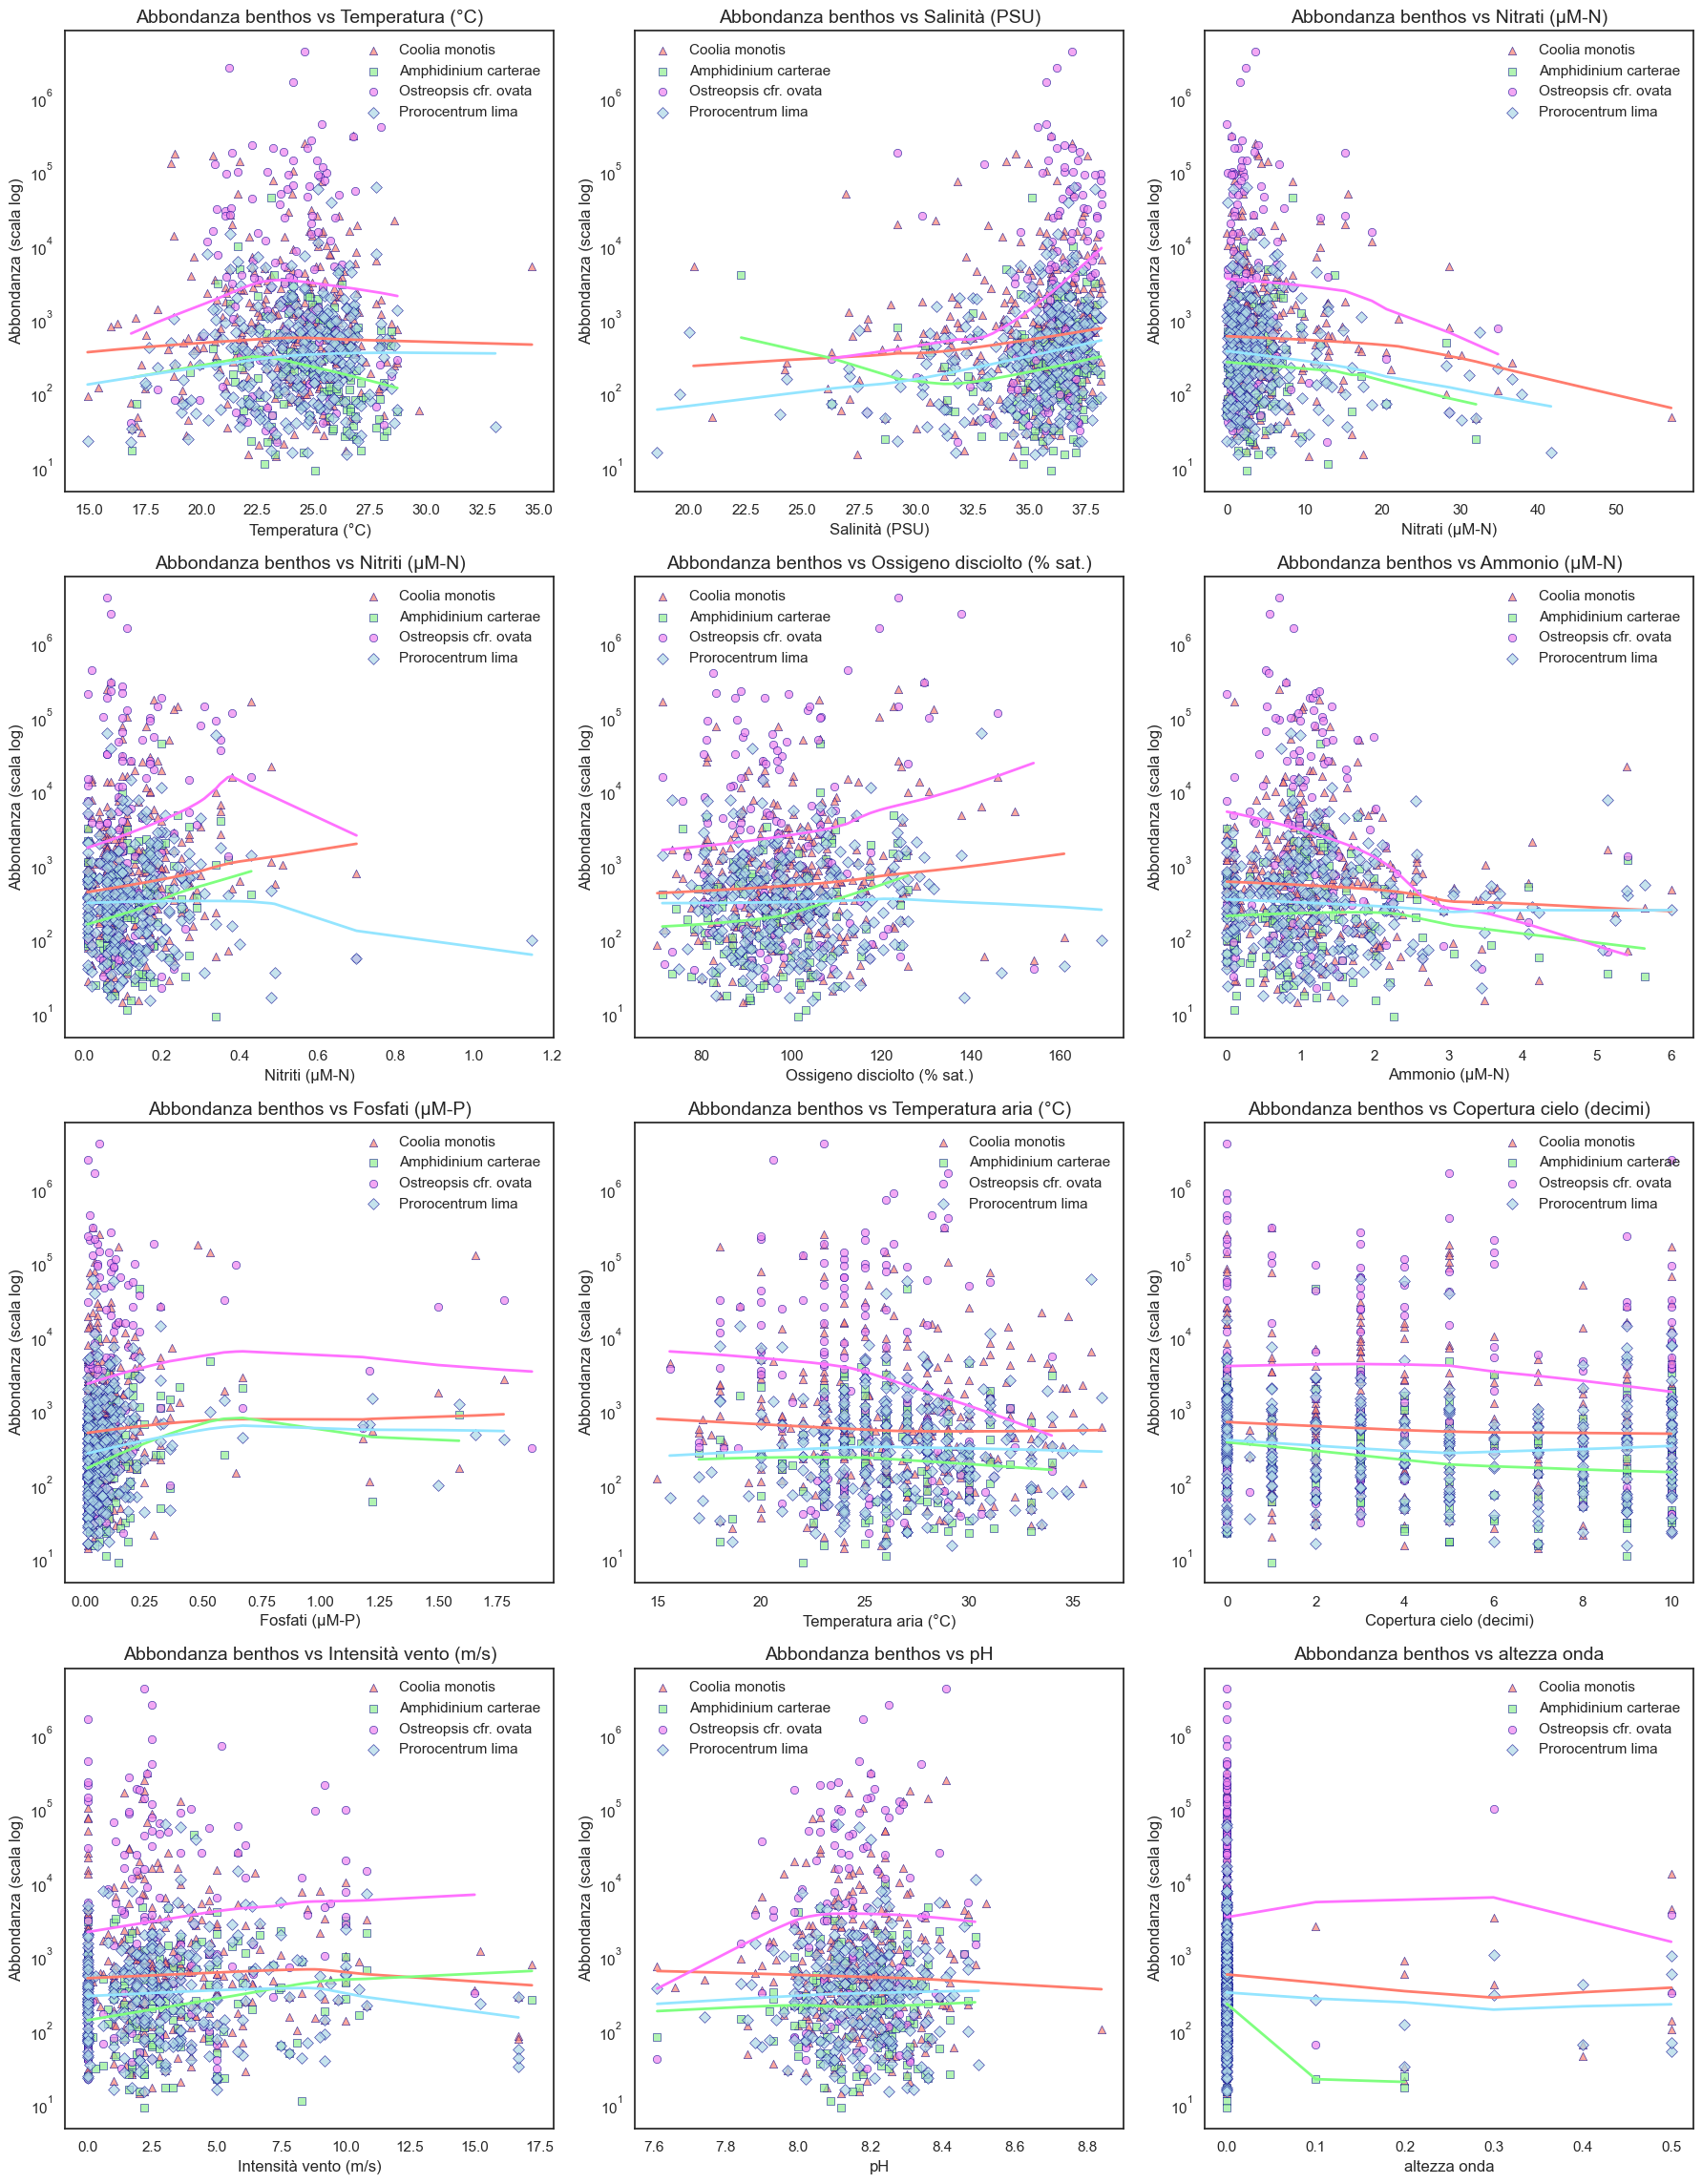

In [237]:
# colonne delle specie da plottare
species_to_plot = [
    "Coolia monotis_cell_gr",
    "Amphidinium carterae_cell_gr",
    "Ostreopsis cfr. ovata_cell_gr",
    "Prorocentrum lima_cell_gr",
]

# dizionario di colori e simboli per ogni specie
species_styles = {
    "Coolia monotis_cell_gr": {"color": "salmon", "marker": "^", "alpha": 0.7},
    "Amphidinium carterae_cell_gr": {
        "color": "lightgreen",
        "marker": "s",
        "alpha": 0.7,
    },
    "Ostreopsis cfr. ovata_cell_gr": {"color": "violet", "marker": "o", "alpha": 0.7},
    "Prorocentrum lima_cell_gr": {"color": "lightblue", "marker": "D", "alpha": 0.7},
}


n_vars = len(numeric_vars)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))

axes = axes.flatten() if n_vars > 1 else [axes]

for i, var in enumerate(numeric_vars):
    ax = axes[i]

    for species_name in species_to_plot:
        species_abundance = df[species_name]
        style = species_styles.get(
            species_name, {"color": "gray", "marker": "x", "alpha": 0.7}
        )

        mask = ~(
            pd.isna(df[var]) | pd.isna(species_abundance) | (species_abundance <= 0)
        )
        x_clean = df[var][mask]
        y_clean = species_abundance[mask]

        # scatter plot con stili diversi
        sns.scatterplot(
            x=x_clean,
            y=y_clean,
            ax=ax,
            color=style["color"],
            marker=style["marker"],
            alpha=style["alpha"],
            edgecolor="darkblue",
            linewidth=0.5,
            label=species_name.split("_")[0],
        )  # etichetta per la legenda

        # calc e plot LOWESS
        if len(x_clean) > 5:
            y_log = np.log10(y_clean)

            sort_idx = np.argsort(x_clean)
            x_sorted = x_clean.iloc[sort_idx]
            y_log_sorted = y_log.iloc[sort_idx]

            lowess_result = lowess(y_log_sorted, x_sorted, frac=1, return_sorted=True)
            x_smooth = lowess_result[:, 0]
            y_smooth_log = lowess_result[:, 1]
            y_smooth = 10**y_smooth_log

            ax.plot(
                x_smooth,
                y_smooth,
                "-",
                linewidth=2,
                alpha=1,
                color=sns.saturate(style["color"]),
            )

    ax.set_title(f"Abbondanza benthos vs {var}", fontsize=14)
    ax.set_yscale("log")
    ax.set_ylabel("Abbondanza (scala log)")
    ax.set_xlabel(var)
    ax.legend()  # Aggiunge la legenda a ogni subplot

for i in range(n_vars, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Proviamo a vedere se la visualizzazione risulta più chiara inserendo un'unica curva LOWESS comune a tutte le specie.


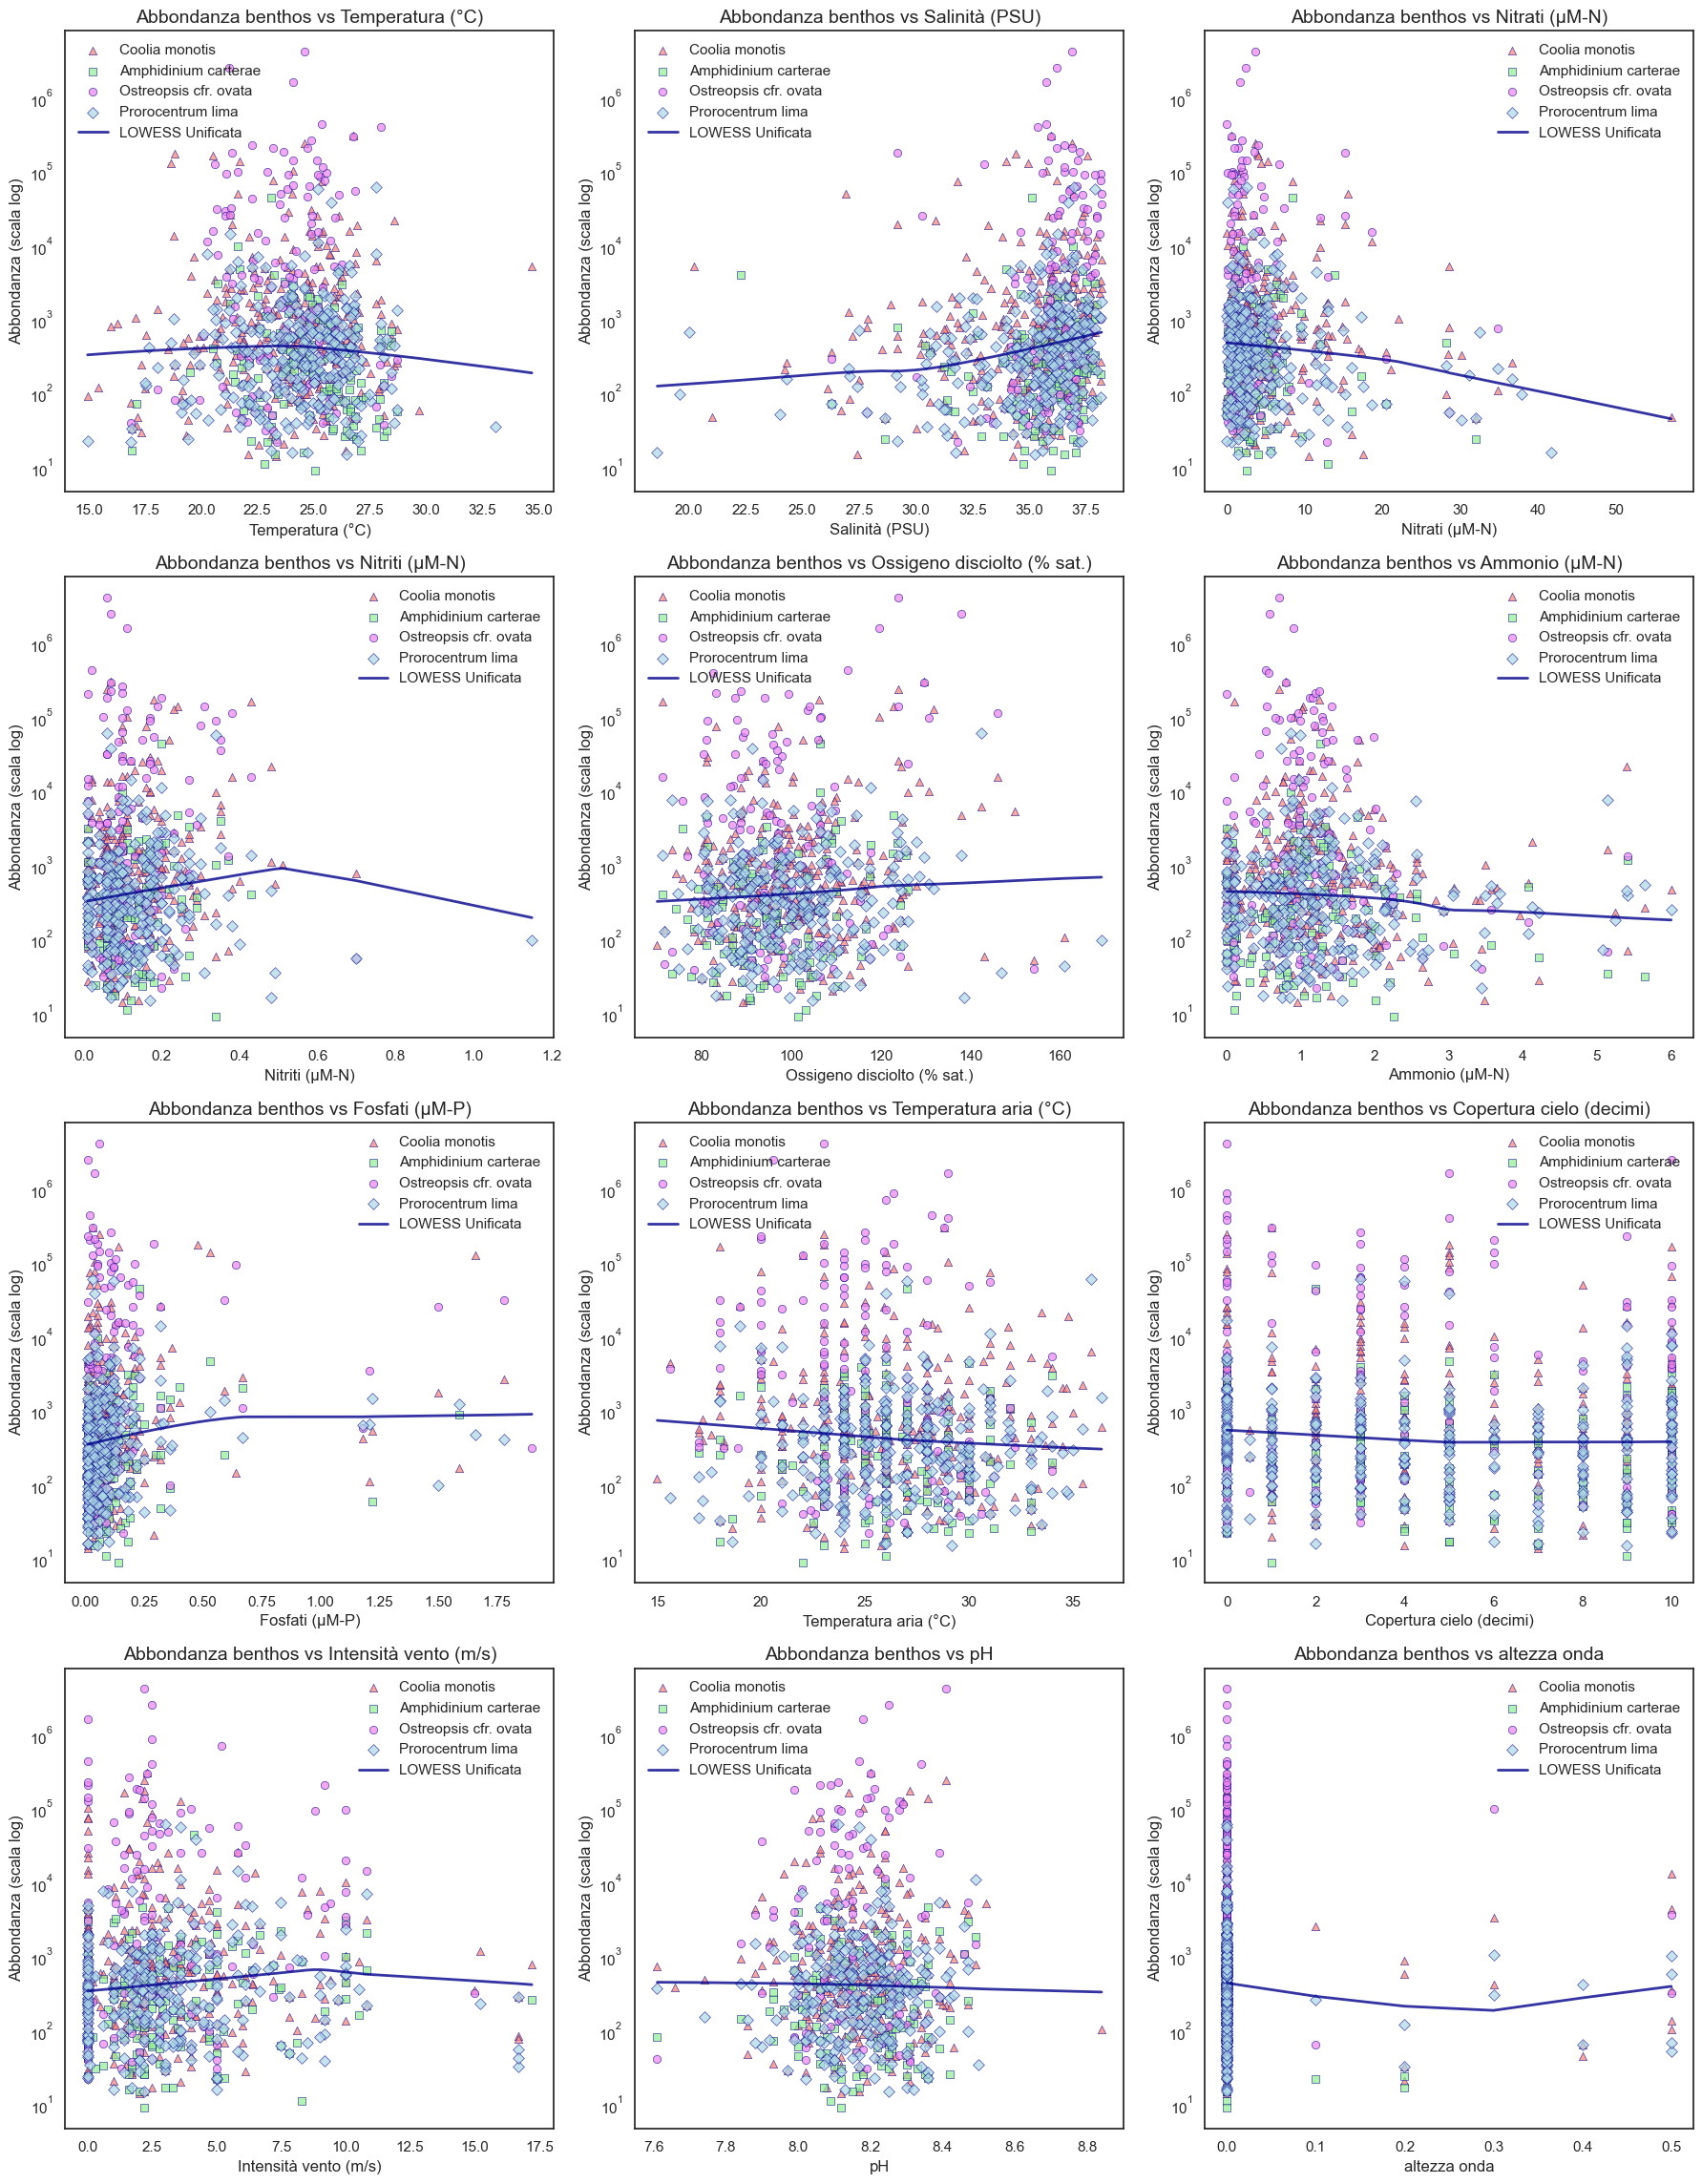

In [238]:
# colonne delle specie da plottare
species_to_plot = [
    "Coolia monotis_cell_gr",
    "Amphidinium carterae_cell_gr",
    "Ostreopsis cfr. ovata_cell_gr",
    "Prorocentrum lima_cell_gr",
]

# dizionario di colori e simboli per ogni specie
species_styles = {
    "Coolia monotis_cell_gr": {"color": "salmon", "marker": "^", "alpha": 0.7},
    "Amphidinium carterae_cell_gr": {
        "color": "lightgreen",
        "marker": "s",
        "alpha": 0.7,
    },
    "Ostreopsis cfr. ovata_cell_gr": {"color": "violet", "marker": "o", "alpha": 0.7},
    "Prorocentrum lima_cell_gr": {"color": "lightblue", "marker": "D", "alpha": 0.7},
}


n_vars = len(numeric_vars)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))

axes = axes.flatten() if n_vars > 1 else [axes]

for i, var in enumerate(numeric_vars):
    ax = axes[i]

    # Inizializza liste per contenere tutti i dati
    all_x_clean = []
    all_y_clean = []

    for species_name in species_to_plot:
        species_abundance = df[species_name]
        style = species_styles.get(
            species_name, {"color": "gray", "marker": "x", "alpha": 0.7}
        )

        mask = ~(
            pd.isna(df[var]) | pd.isna(species_abundance) | (species_abundance <= 0)
        )
        x_clean = df[var][mask]
        y_clean = species_abundance[mask]

        # Aggiungi i dati puliti alle liste aggregate
        all_x_clean.extend(x_clean)
        all_y_clean.extend(y_clean)

        # scatter plot con stili diversi
        sns.scatterplot(
            x=x_clean,
            y=y_clean,
            ax=ax,
            color=style["color"],
            marker=style["marker"],
            alpha=style["alpha"],
            edgecolor="darkblue",
            linewidth=0.5,
            label=species_name.split("_")[0],
        )  # etichetta per la legenda

    # Calcola e plotta una singola LOWESS per tutti i dati aggregati
    if len(all_x_clean) > 5:
        # Converti le liste in array numpy per il calcolo
        all_x_clean = np.array(all_x_clean)
        all_y_clean = np.array(all_y_clean)

        y_log = np.log10(all_y_clean)

        sort_idx = np.argsort(all_x_clean)
        x_sorted = all_x_clean[sort_idx]
        y_log_sorted = y_log[sort_idx]

        lowess_result = lowess(y_log_sorted, x_sorted, frac=1, return_sorted=True)
        x_smooth = lowess_result[:, 0]
        y_smooth_log = lowess_result[:, 1]
        y_smooth = 10**y_smooth_log

        ax.plot(
            x_smooth,
            y_smooth,
            "-",
            linewidth=2,
            alpha=0.8,
            color="darkblue",
            label="LOWESS Unificata",
        )

    ax.set_title(f"Abbondanza benthos vs {var}", fontsize=14)
    ax.set_yscale("log")
    ax.set_ylabel("Abbondanza (scala log)")
    ax.set_xlabel(var)
    ax.legend()

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Facciamo la stessa cosa per le abbondanzae planctoniche per vedere se cambia qualcosa o il grafico rimane pressoché inviariato.


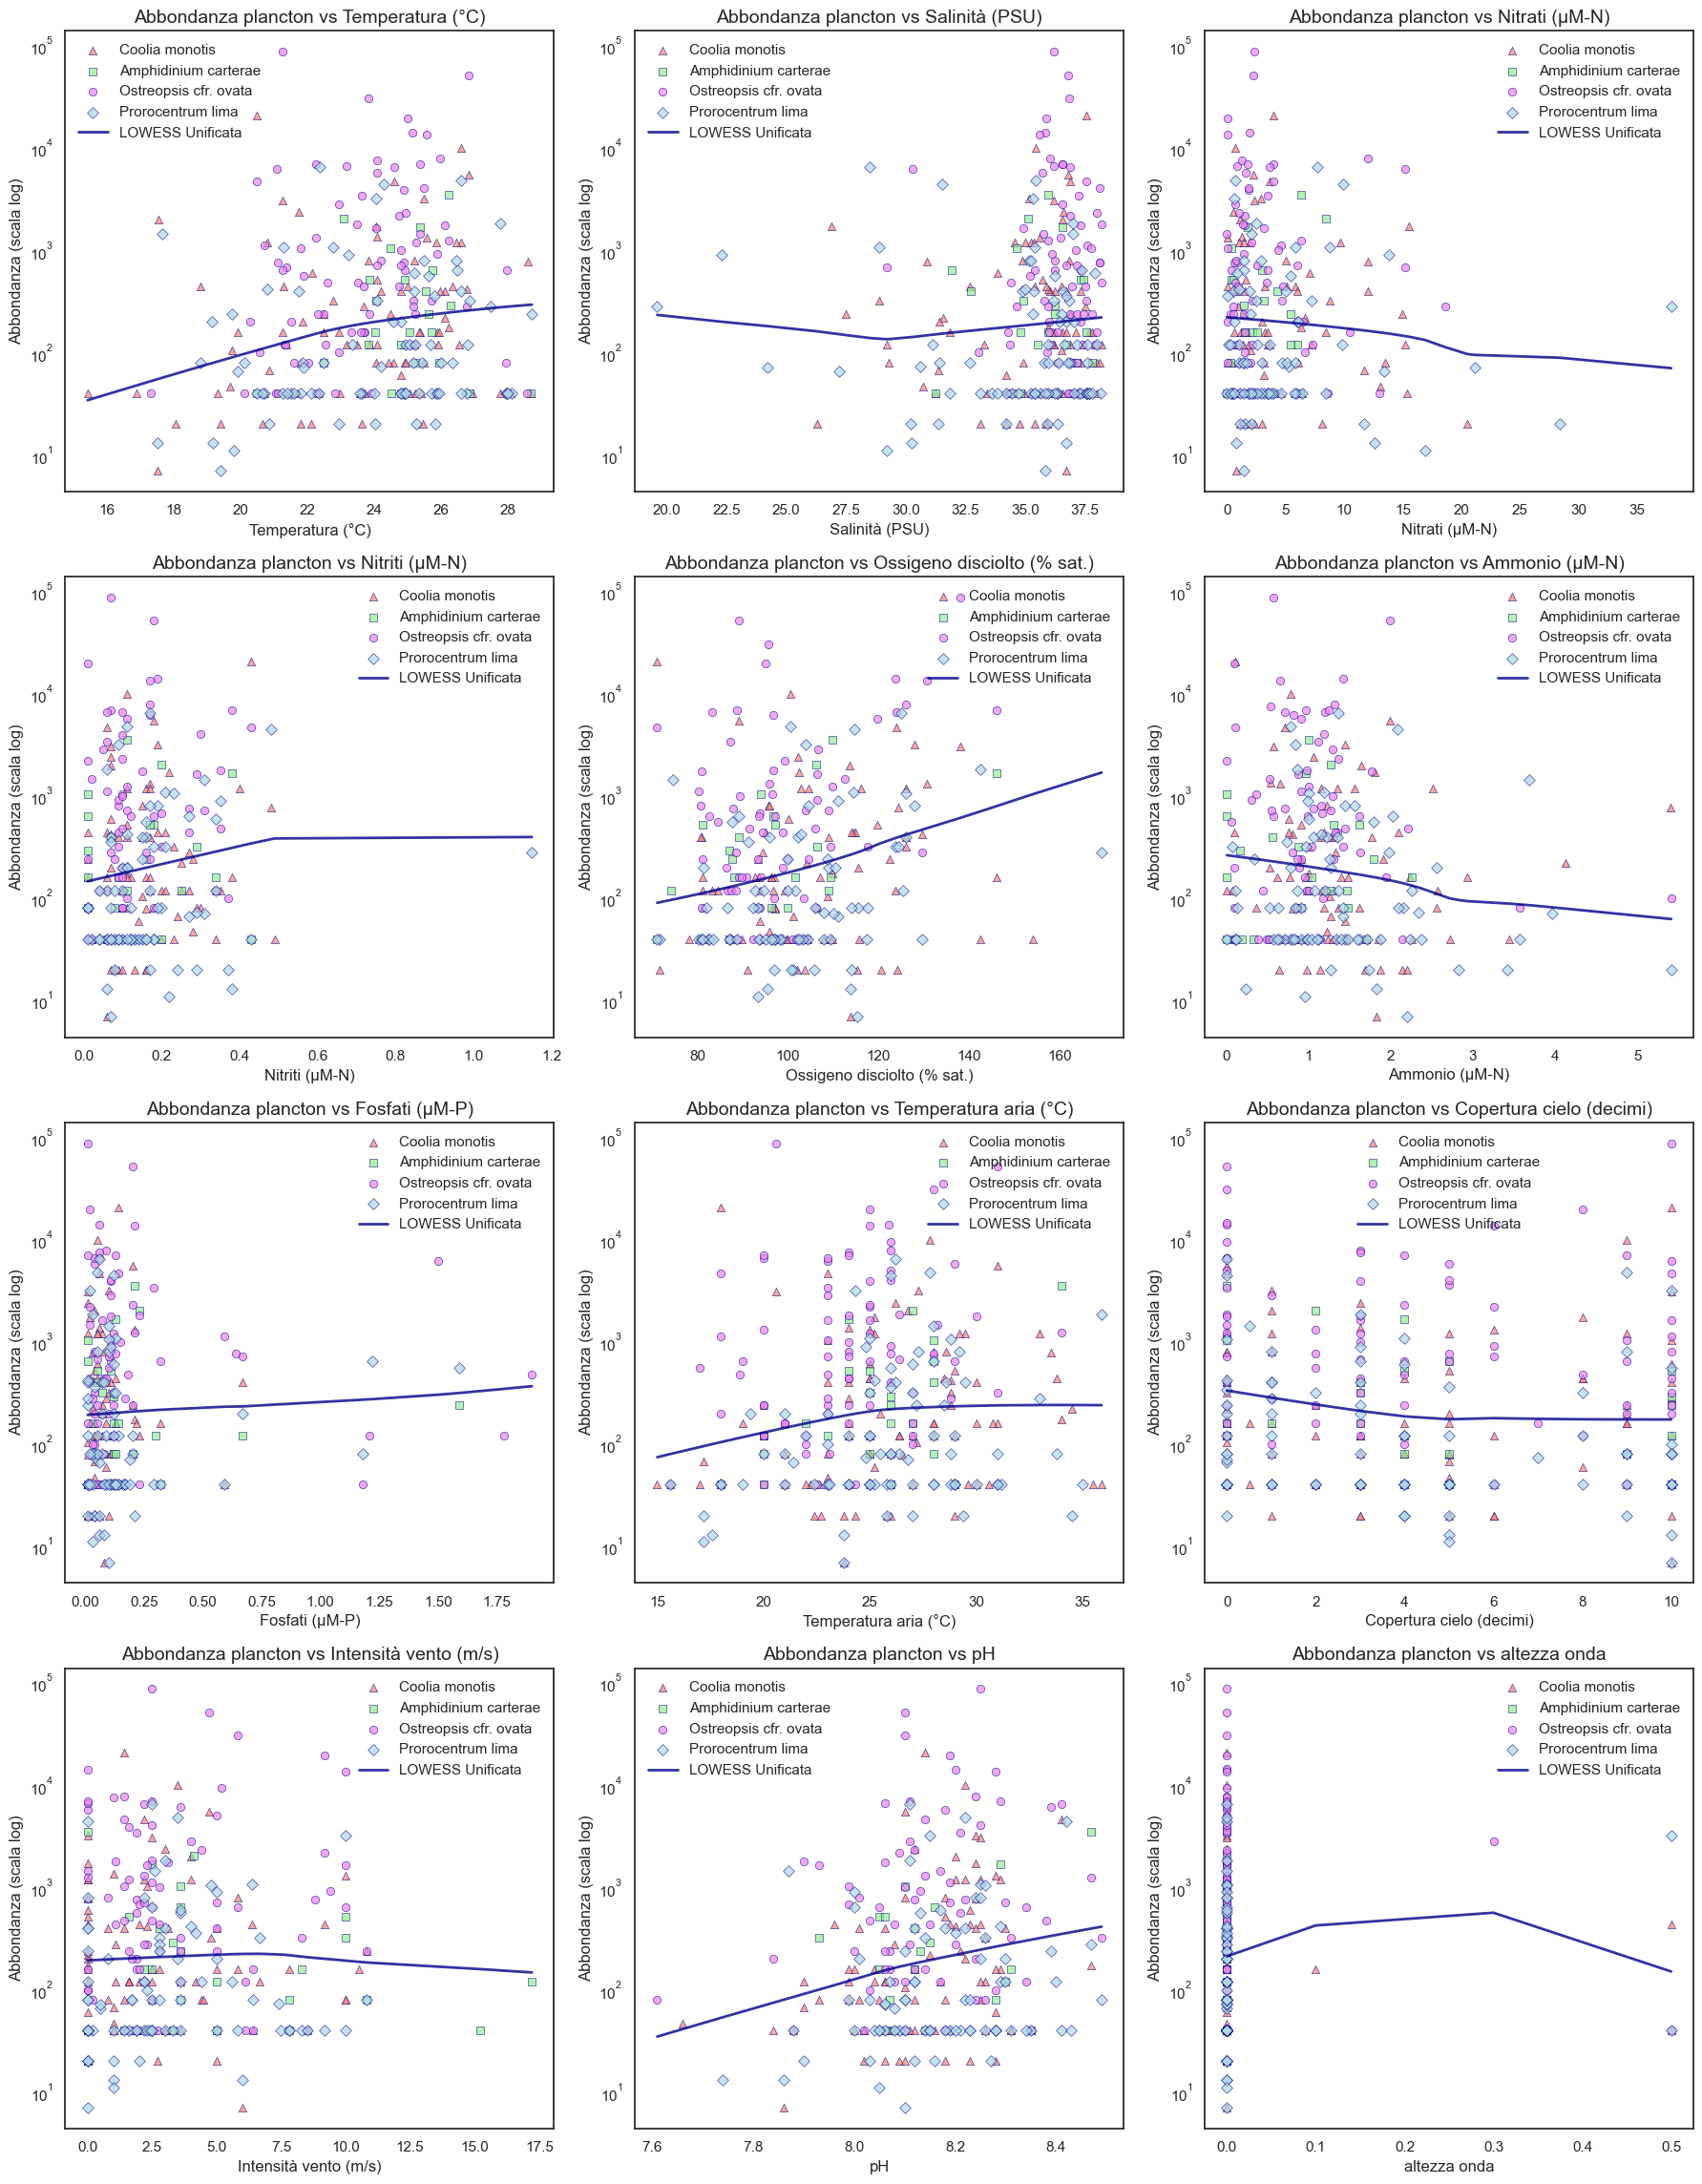

In [239]:
# colonne delle specie da plottare
species_to_plot = [
    "Coolia monotis_cell_l",
    "Amphidinium carterae_cell_l",
    "Ostreopsis cfr. ovata_cell_l",
    "Prorocentrum lima_cell_l",
]

# dizionario di colori e simboli per ogni specie
species_styles = {
    "Coolia monotis_cell_l": {"color": "salmon", "marker": "^", "alpha": 0.7},
    "Amphidinium carterae_cell_l": {"color": "lightgreen", "marker": "s", "alpha": 0.7},
    "Ostreopsis cfr. ovata_cell_l": {"color": "violet", "marker": "o", "alpha": 0.7},
    "Prorocentrum lima_cell_l": {"color": "lightblue", "marker": "D", "alpha": 0.7},
}


n_vars = len(numeric_vars)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))

axes = axes.flatten() if n_vars > 1 else [axes]

for i, var in enumerate(numeric_vars):
    ax = axes[i]

    # Inizializza liste per contenere tutti i dati
    all_x_clean = []
    all_y_clean = []

    for species_name in species_to_plot:
        species_abundance = df[species_name]
        style = species_styles.get(
            species_name, {"color": "gray", "marker": "x", "alpha": 0.7}
        )

        mask = ~(
            pd.isna(df[var]) | pd.isna(species_abundance) | (species_abundance <= 0)
        )
        x_clean = df[var][mask]
        y_clean = species_abundance[mask]

        # Aggiungi i dati puliti alle liste aggregate
        all_x_clean.extend(x_clean)
        all_y_clean.extend(y_clean)

        # scatter plot con stili diversi
        sns.scatterplot(
            x=x_clean,
            y=y_clean,
            ax=ax,
            color=style["color"],
            marker=style["marker"],
            alpha=style["alpha"],
            edgecolor="darkblue",
            linewidth=0.5,
            label=species_name.split("_")[0],
        )  # etichetta per la legenda

    # Calcola e plotta una singola LOWESS per tutti i dati aggregati
    if len(all_x_clean) > 5:
        # Converti le liste in array numpy per il calcolo
        all_x_clean = np.array(all_x_clean)
        all_y_clean = np.array(all_y_clean)

        y_log = np.log10(all_y_clean)

        sort_idx = np.argsort(all_x_clean)
        x_sorted = all_x_clean[sort_idx]
        y_log_sorted = y_log[sort_idx]

        lowess_result = lowess(y_log_sorted, x_sorted, frac=1, return_sorted=True)
        x_smooth = lowess_result[:, 0]
        y_smooth_log = lowess_result[:, 1]
        y_smooth = 10**y_smooth_log

        ax.plot(
            x_smooth,
            y_smooth,
            "-",
            linewidth=2,
            alpha=0.8,
            color="darkblue",
            label="LOWESS Unificata",
        )

    ax.set_title(f"Abbondanza plancton vs {var}", fontsize=14)
    ax.set_yscale("log")
    ax.set_ylabel("Abbondanza (scala log)")
    ax.set_xlabel(var)
    ax.legend()

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<h4>Considerazioni importanti su ciascuna specie:<h4>


<h3>Analisi su <em>Ostreopsis ovata</em></h3>
<h4>Relazione tra Misura nell'Acqua (cell/L) e sul Fondale (cell/g)</h4>
<ul>
<li>
Per l'alga <i>O. ovata</i>, l'andamento delle due misurazioni (<code>cell/L</code> e <code>cell/g</code>) risulta molto simile.
</li>
<li>
Tuttavia, è importante capire la differenza:
<ul>
<li><strong>cell/g</strong>: Misura la concentrazione di alghe ancorate al fondale e alle superfici (abbondanza <strong>bentonica</strong>).</li>
<li><strong>cell/L</strong>: Misura la concentrazione di alghe libere nell'acqua (abbondanza <strong>planctonica</strong>), che si sono staccate dal fondale. È questa a causare problemi per la balneazione.</li>
</ul>
</li>
<li>
Teoricamente, la fioritura sul fondale (picco in <code>cell/g</code>) dovrebbe avvenire prima di quella nell'acqua (picco in <code>cell/L</code>). Questa sequenza temporale andrebbe verificata con i dati.
</li>
</ul>
<h4>Condizioni Ambientali che Favoriscono le Fioriture</h4>
<ul>
<li>
<strong>Temperatura:</strong> È il fattore stagionale più importante. Le fioriture avvengono con temperature dell'acqua elevate, comprese tra 21°C e 27°C.
</li>
<li>
<strong>Salinità:</strong> Le proliferazioni si verificano in acque con salinità alta (tra 33 e 34 PSU).
</li>
<li>
<strong>Stato del mare:</strong> Condizioni di mare calmo, con vento e onde di bassa intensità, favoriscono le fioriture. I campionamenti sono avvenuti vicino alla costa, ambiente ideale per questi fenomeni.
</li>
<li>
<strong>Nutrienti:</strong> Durante le fioriture si riscontrano <strong>bassi livelli di nutrienti</strong> (nitriti, ammonio, fosfati), probabilmente perché le alghe li consumano per crescere.
</li>
<li>
<strong>Ossigeno disciolto:</strong> Esiste una correlazione positiva. Le fioriture più intense coincidono con una sovrasaturazione di ossigeno nell'acqua.
</li>
<li>
<strong>pH:</strong> Anche qui la correlazione è positiva. Le fioriture avvengono con un pH più alto, poiché le alghe consumano la CO2 disciolta, rendendo l'acqua più basica.
</li>
<li>
Fattori come la copertura nuvolosa e la direzione del vento non sembrano avere un'influenza rilevante.
</li>
</ul>


<h3>Analisi su <em>Prorocentrum lima</em></h3>
<h4>Condizioni Ambientali che Favoriscono le Fioriture</h4>
<p>
Le fioriture di <i>P. lima</i>, sebbene <strong>meno intense</strong> rispetto a quelle di <i>O. ovata</i>, sono influenzate da condizioni ambientali simili, con alcune differenze importanti:
</p>
<ul>
<li>
<strong>Temperatura:</strong> Anche in questo caso è il fattore stagionale principale. Le fioriture avvengono con temperature calde, ma in un intervallo più ampio rispetto a <i>O. ovata</i> (tra 20°C e oltre 30°C).
</li>
<li>
<strong>Salinità:</strong> Questa specie è in grado di prosperare in acque con salinità più bassa rispetto a <i>O. ovata</i> (le fioriture si verificano con valori fino a 25 PSU).
</li>
<li>
<strong>Stato del mare:</strong> Predilige condizioni di mare calmo, con vento e altezza delle onde bassi. I campionamenti sono infatti concentrati nelle zone costiere, più favorevoli a queste proliferazioni.
</li>
<li>
<strong>Nutrienti:</strong> Analogamente ad altre alghe, le fioriture coincidono con una <strong>bassa concentrazione di nutrienti</strong> (nitriti, ammonio, fosfati), che vengono consumati durante la crescita algale.
</li>
<li>
<strong>Ossigeno disciolto e pH:</strong> Le relazioni sono positive. Le fioriture più intense si osservano con un'alta saturazione di ossigeno e con un pH più elevato, dovuto al consumo di CO2 da parte delle alghe.
</li>
<li>
Fattori come la copertura nuvolosa e la direzione del vento non sembrano avere un'influenza significativa.
</li>
</ul>


<h3>Analisi su <em>Coolia monotis</em></h3>
<h4>Condizioni Ambientali che Favoriscono le Fioriture</h4>
<p>
<i>Coolia monotis</i> dimostra una notevole adattabilità. Le condizioni che ne favoriscono la crescita sono:
</p>
<ul>
<li>
<strong>Temperatura:</strong> Prospera in un intervallo di temperature calde ancora più ampio rispetto alle altre specie analizzate, <strong>tra 18°C e 30°C</strong>.
</li>
<li>
<strong>Salinità:</strong> Mostra una <strong>maggiore tolleranza</strong> rispetto a <i>O. ovata</i> e <i>P. lima</i>, sviluppandosi bene in un vasto range di salinità, da valori medi a molto elevati.
</li>
<li>
<strong>Stato del mare:</strong> Anche questa specie predilige condizioni di mare calmo, con bassa intensità di vento e onde, tipiche delle aree costiere dove sono stati effettuati i prelievi.
</li>
<li>
<strong>Nutrienti:</strong> Le fioriture coincidono con una <strong>bassa concentrazione di nutrienti</strong> (nitriti, ammonio, fosfati), che vengono assorbiti e utilizzati dalle alghe durante la loro proliferazione.
</li>
<li>
<strong>Ossigeno disciolto e pH:</strong> Le relazioni sono positive. Le fioriture più intense si verificano in condizioni di acqua sovrasatura di ossigeno e con un pH più alto, come conseguenza diretta dell'attività metabolica delle alghe.
</li>
<li>
Fattori come la copertura nuvolosa e la direzione del vento non mostrano un'influenza chiara sulle sue fioriture.
</li>
</ul>


<h3>Analisi su <em>Amphidinium carterae</em></h3>
<h4>Condizioni Ambientali che Favoriscono le Fioriture</h4>
<p>
Le fioriture di <i>Amphidinium carterae</i> sono generalmente <strong>meno estreme</strong> rispetto a quelle di <i>O. ovata</i> e delle altre specie esaminate. Mostra una notevole tolleranza a diverse condizioni ambientali:
</p>
<ul>
<li>
<strong>Temperatura:</strong> Come altre specie, è favorita da temperature calde, ma prospera in un intervallo molto ampio, <strong>tra 18°C e 30°C</strong>.
</li>
<li>
<strong>Salinità:</strong> Si adatta a un ampio spettro di salinità, sviluppandosi in condizioni che vanno da medie a molto elevate.
</li>
<li>
<strong>Stato del mare:</strong> Predilige condizioni di mare calmo, con vento e onde di bassa intensità, tipiche delle zone costiere dove sono stati effettuati i campionamenti.
</li>
<li>
<strong>Nutrienti:</strong> Durante le fioriture si osserva una <strong>ridotta concentrazione di nutrienti</strong> (nitriti, ammonio, fosfati), poiché vengono consumati dalle alghe per la loro crescita.
</li>
<li>
<strong>Ossigeno disciolto e pH:</strong> Le relazioni sono positive. Le proliferazioni più significative avvengono in acque con alta saturazione di ossigeno e pH elevato, a causa del consumo di CO<sub>2</sub> da parte delle alghe.
</li>
<li>
La copertura nuvolosa e la direzione del vento non sembrano essere fattori determinanti per le sue fioriture.
</li>
</ul>


Grafici per vedere la densità cellulare delle diverse specie in un unico grafico.


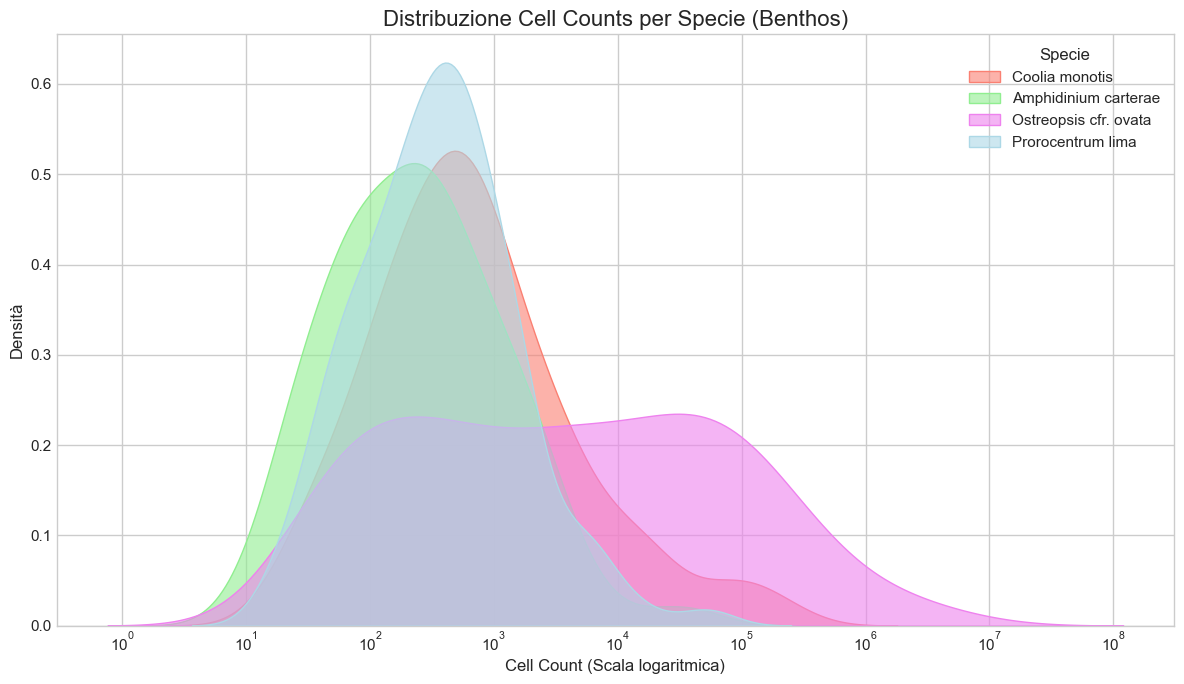

In [240]:
species_to_plot = [
    "Coolia monotis_cell_gr",
    "Amphidinium carterae_cell_gr",
    "Ostreopsis cfr. ovata_cell_gr",
    "Prorocentrum lima_cell_gr",
]

# Color and style dictionary for each species (from your previous code)
species_styles = {
    "Coolia monotis_cell_gr": {
        "color": "salmon",
        "marker": "^",
        "alpha": 0.6,
    },  # Alpha slightly adjusted for fill
    "Amphidinium carterae_cell_gr": {
        "color": "lightgreen",
        "marker": "s",
        "alpha": 0.6,
    },
    "Ostreopsis cfr. ovata_cell_gr": {"color": "violet", "marker": "o", "alpha": 0.6},
    "Prorocentrum lima_cell_gr": {"color": "lightblue", "marker": "D", "alpha": 0.6},
}


plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

for species_name in species_to_plot:
    style = species_styles.get(species_name, {"color": "gray", "alpha": 0.5})

    cell_counts = df[species_name].dropna()
    cell_counts = cell_counts[cell_counts > 0]

    if not cell_counts.empty:
        # KDE plot
        sns.kdeplot(
            data=cell_counts,
            ax=ax,
            color=style["color"],
            fill=True,
            alpha=style["alpha"],
            log_scale=True,
            label=species_name.split("_")[0],
        )


ax.set_title("Distribuzione Cell Counts per Specie (Benthos)", fontsize=16)
ax.set_xlabel("Cell Count (Scala logaritmica)", fontsize=12)
ax.set_ylabel("Densità", fontsize=12)

ax.legend(title="Specie")

plt.tight_layout()
plt.show()

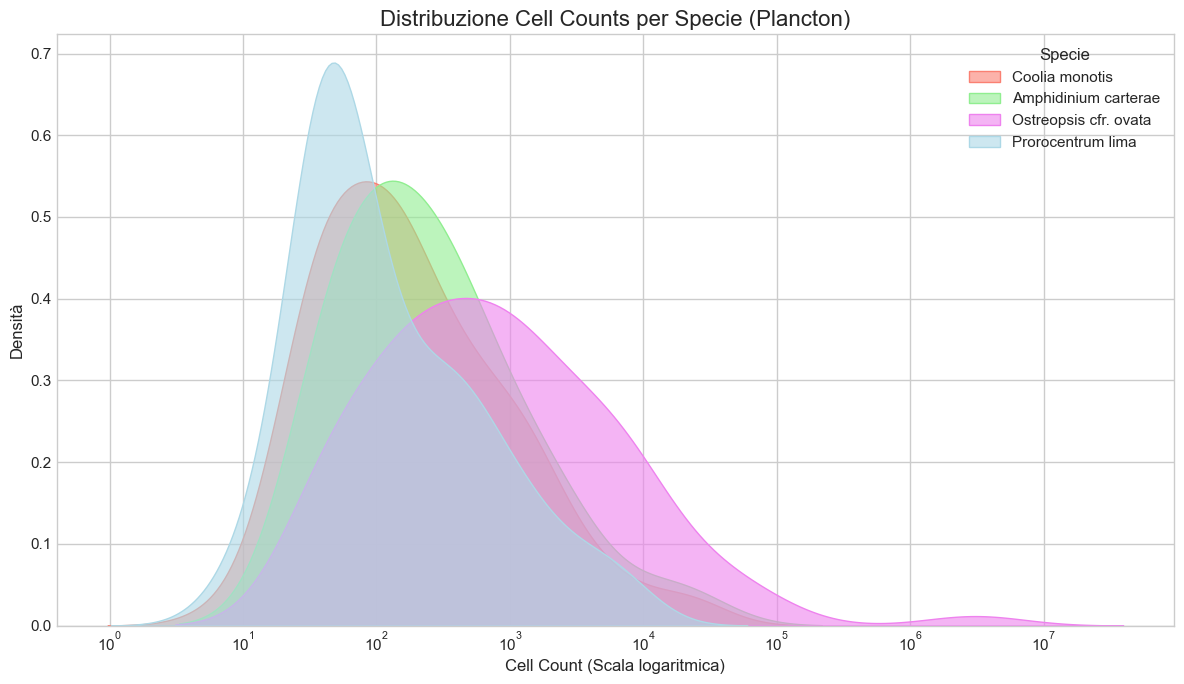

In [241]:
species_to_plot = [
    "Coolia monotis_cell_l",
    "Amphidinium carterae_cell_l",
    "Ostreopsis cfr. ovata_cell_l",
    "Prorocentrum lima_cell_l",
]

# Color and style dictionary for each species (from your previous code)
species_styles = {
    "Coolia monotis_cell_l": {
        "color": "salmon",
        "marker": "^",
        "alpha": 0.6,
    },  # Alpha slightly adjusted for fill
    "Amphidinium carterae_cell_l": {"color": "lightgreen", "marker": "s", "alpha": 0.6},
    "Ostreopsis cfr. ovata_cell_l": {"color": "violet", "marker": "o", "alpha": 0.6},
    "Prorocentrum lima_cell_l": {"color": "lightblue", "marker": "D", "alpha": 0.6},
}


plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

for species_name in species_to_plot:
    style = species_styles.get(species_name, {"color": "gray", "alpha": 0.5})

    cell_counts = df[species_name].dropna()
    cell_counts = cell_counts[cell_counts > 0]

    if not cell_counts.empty:
        # KDE plot
        sns.kdeplot(
            data=cell_counts,
            ax=ax,
            color=style["color"],
            fill=True,
            alpha=style["alpha"],
            log_scale=True,
            label=species_name.split("_")[0],
        )


ax.set_title("Distribuzione Cell Counts per Specie (Plancton)", fontsize=16)
ax.set_xlabel("Cell Count (Scala logaritmica)", fontsize=12)
ax.set_ylabel("Densità", fontsize=12)

ax.legend(title="Specie")

plt.tight_layout()
plt.show()

<h3>Analisi Temporali e Stagionali<h3>


Come sono cambiate le concentrazioni delle specie negli anni? <br>
Come cambiano le concentrazioni delle specie stagionalmente?


<h4>Trend Stagionale<h4>


Mappiamo i numeri nei mesi corrispondenti per comprendere meglio i futuri grafici.


In [242]:
month_map = {
    1: "gen",
    2: "feb",
    3: "mar",
    4: "apr",
    5: "mag",
    6: "giu",
    7: "lug",
    8: "ago",
    9: "set",
    10: "ott",
    11: "nov",
    12: "dic",
}

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\1343269539.py:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)


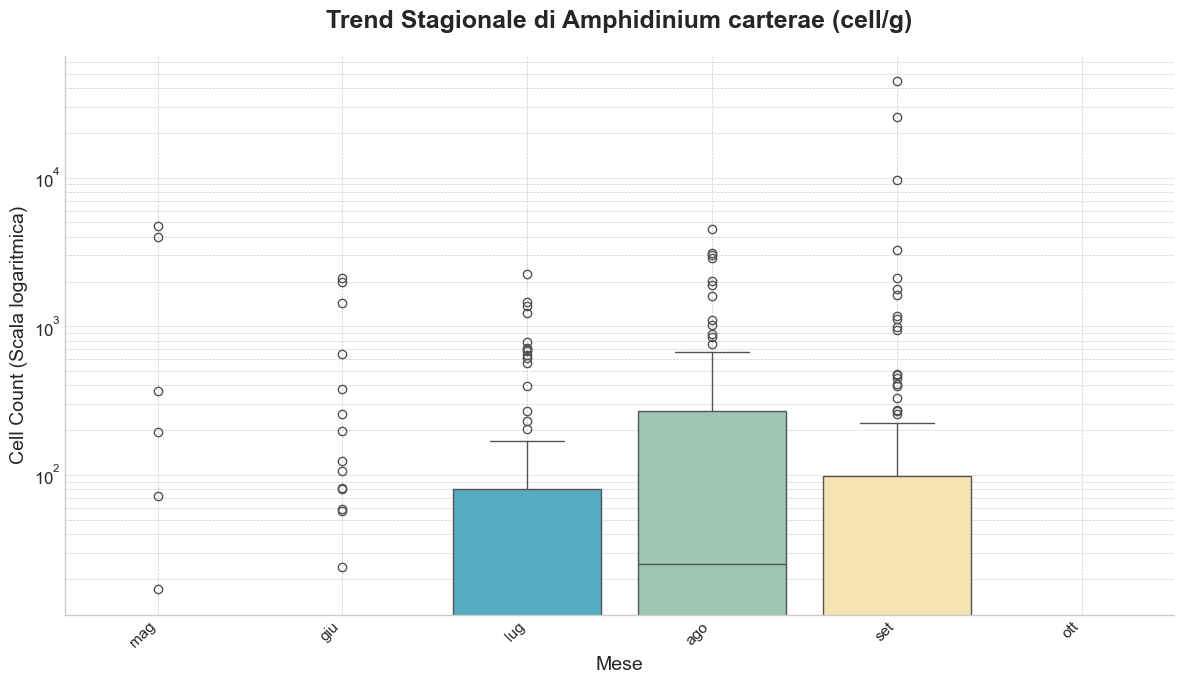

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\1343269539.py:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)


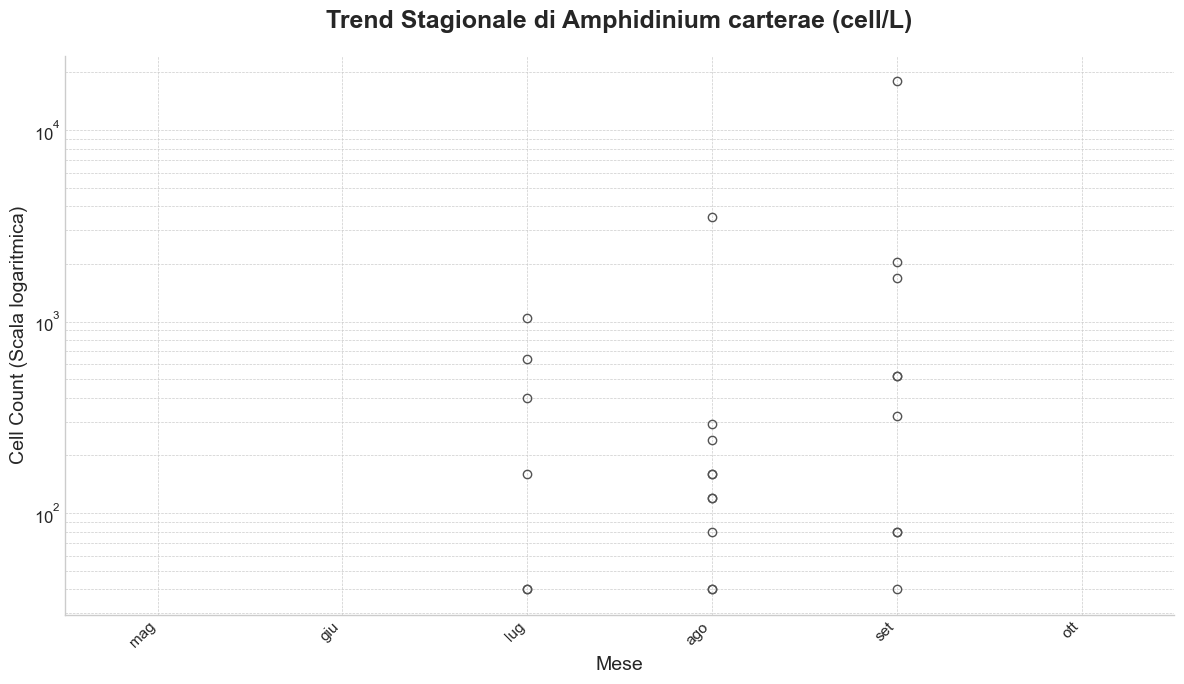

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\1343269539.py:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)


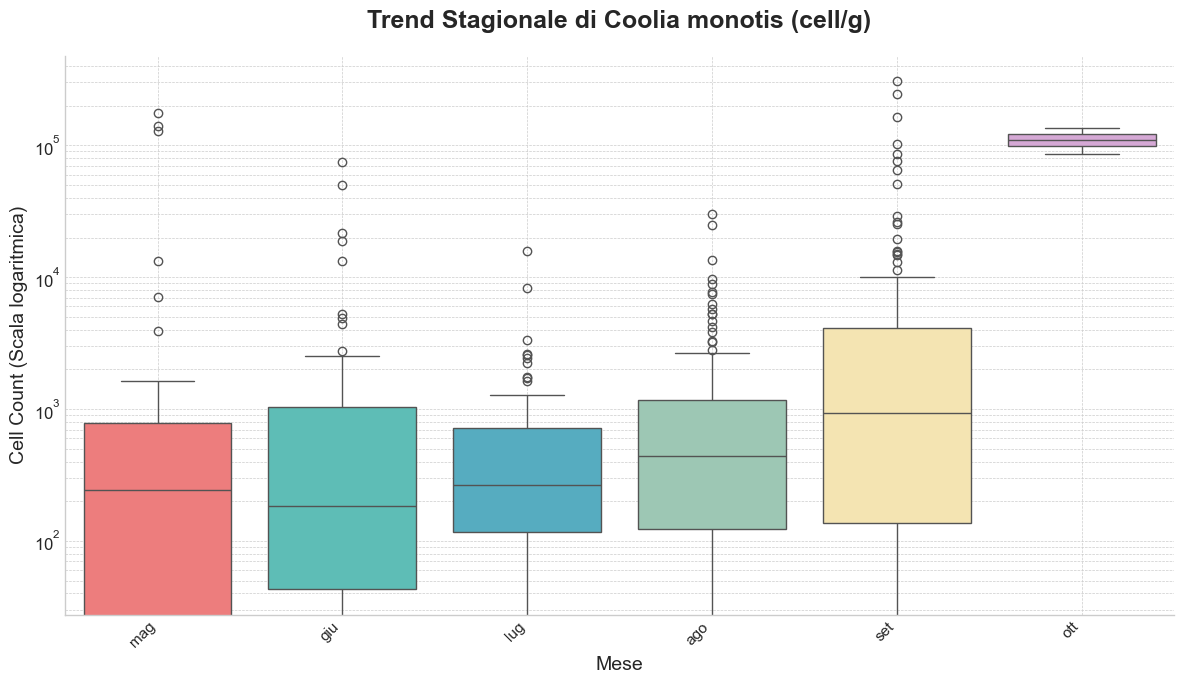

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\1343269539.py:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)


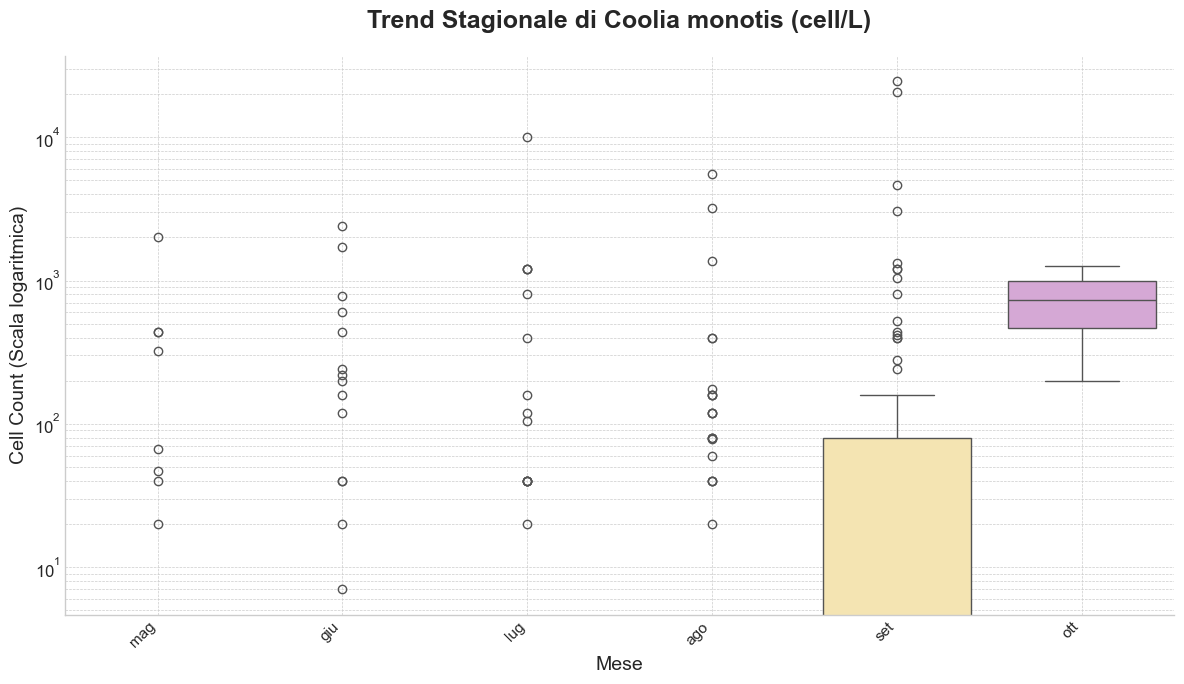

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\1343269539.py:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)


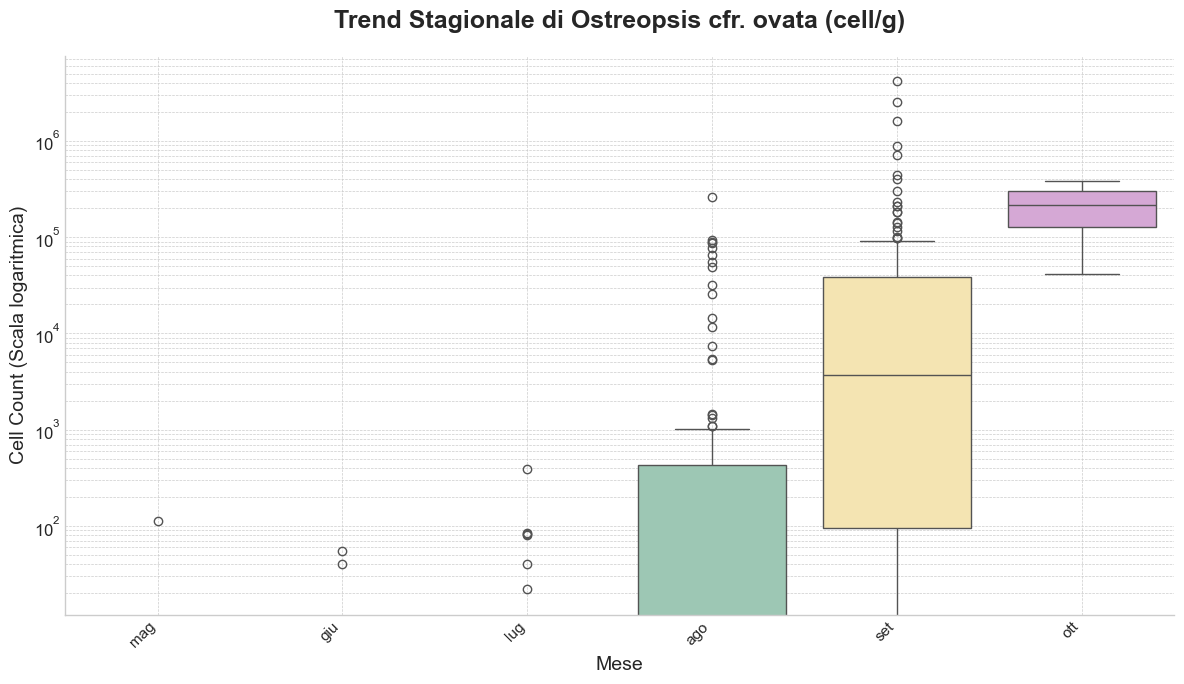

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\1343269539.py:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)


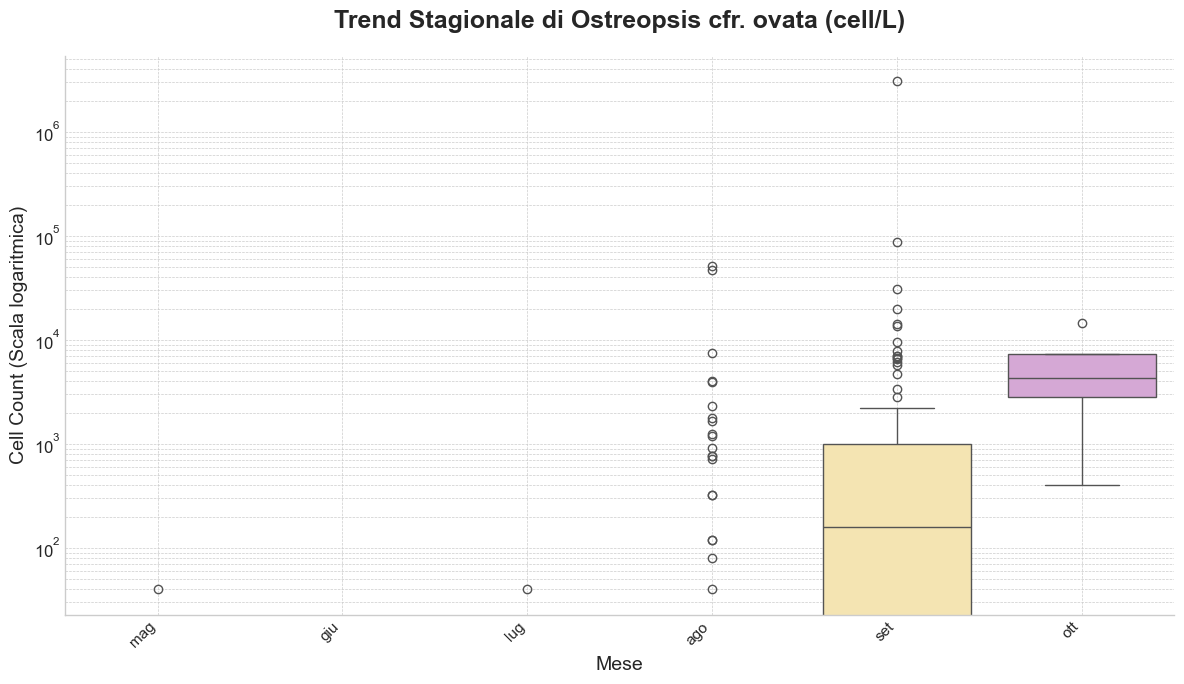

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\1343269539.py:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)


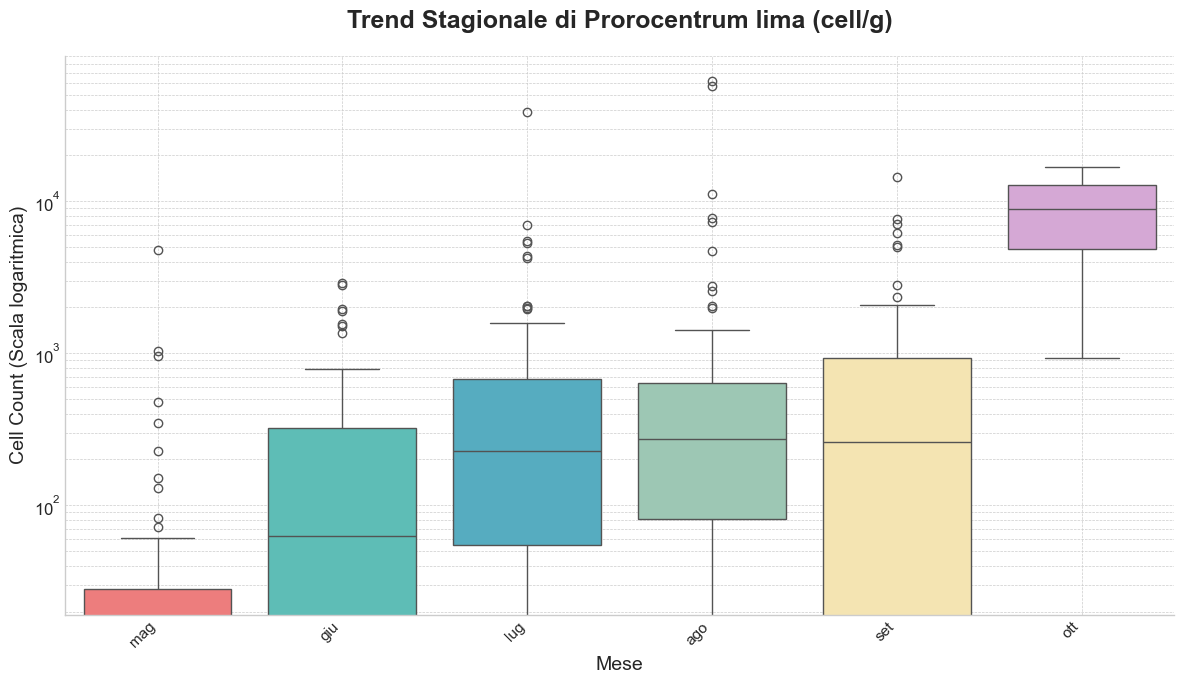

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\1343269539.py:37: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)


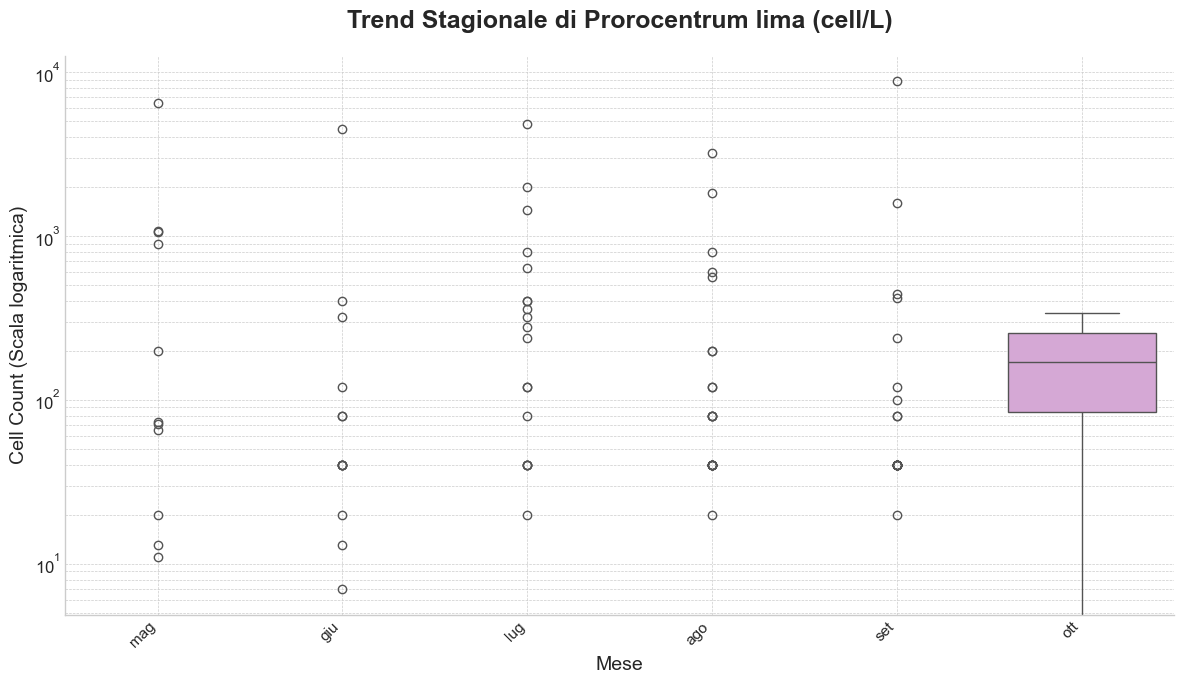

In [243]:
# identifichiamo le colonne con cell_gr
columns = [col for col in df.columns if "_cell_" in col]
df_stag = df.copy()

df_stag["MESE"] = df_stag["MESE"].map(month_map)

# cambio nomi colonne
cleaned_column_names = {}
for col in df_stag.columns:
    if "_cell_l" in col:
        clean_name = col.replace("_cell_l", " (cell/L)")
    elif "_cell_gr" in col:
        clean_name = col.replace("_cell_gr", " (cell/g)")
    else:
        clean_name = col

    cleaned_column_names[col] = clean_name

df_stag.rename(columns=cleaned_column_names, inplace=True)

new_columns = [cleaned_column_names[col] for col in columns]

custom_colors = [
    "#FF6B6B",  # bright coral
    "#4ECDC4",  # bright teal
    "#45B7D1",  # bright blue
    "#96CEB4",  # pastel green
    "#FFEAA7",  # pastel yellow
    "#DDA0DD",  # pastel purple
    "#FFB347",  # pastel orange
    "#87CEEB",  # pastel sky blue
]

# itero per ogni specie per avere un grafico per ogni specie
for specie in new_columns:
    plt.figure(figsize=(12, 7))
    sns.boxplot(x="MESE", y=specie, hue="MESE", data=df_stag, palette=custom_colors)
    plt.yscale("log")  # per distribuzioni log-normali
    plt.title(f"Trend Stagionale di {specie}", fontsize=18, fontweight="bold", pad=20)
    plt.xlabel("Mese", fontsize=14)
    plt.ylabel("Cell Count (Scala logaritmica)", fontsize=14)
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels if they overlap
    plt.yticks(fontsize=12)
    sns.despine()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

Proviamo ad inserire tutte queste informazioni in un unico grafico.


d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_args, **plot_kwargs)
d:\FondamentiDati\progetto\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  func(*plot_a

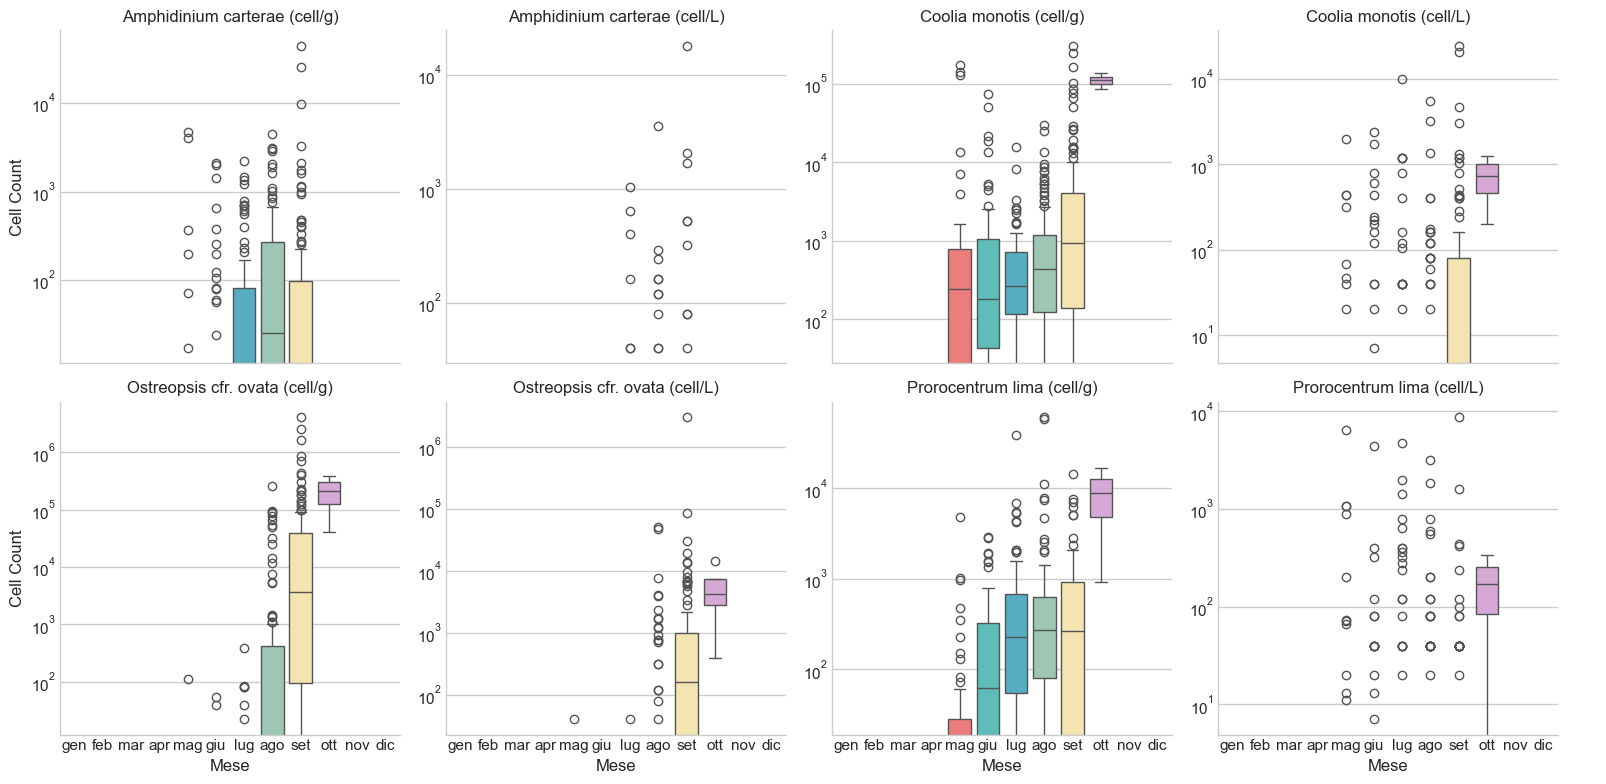

In [244]:
# riporto i dati nel long format
# seaborn lavora meglio con i dati in long format in questo caso
df_long = df_stag.melt(
    id_vars=["MESE"],
    value_vars=new_columns,
    var_name="Species",
    value_name="Cell Count",
)

g = sns.FacetGrid(df_long, col="Species", col_wrap=4, height=4, sharey=False)
g.map_dataframe(
    sns.boxplot,
    x="MESE",
    y="Cell Count",
    hue="MESE",
    order=list(month_map.values()),
    palette=custom_colors,
)
g.add_legend()
g.set_axis_labels("Mese", "Cell Count")
g.set_titles(col_template="{col_name}")
g.set(yscale="log")
g.tight_layout(w_pad=1)

<h3>Andamento Stagionale Generale per Tutte le Specie</h3>
<ul>
<li>
<strong>Preferenza per i mesi caldi:</strong> Tutte le specie di alghe analizzate mostrano un chiaro andamento stagionale, con una netta preferenza per il periodo estivo. È importante ricordare che i campionamenti sono stati effettuati solo da maggio a ottobre.
</li>
<li>
<strong>Picco a fine estate:</strong> Le popolazioni algali iniziano a crescere con l'arrivo dell'estate e raggiungono la massima abbondanza verso la fine della stagione, in particolare tra settembre e ottobre.
</li>
<li>
<strong>Crescita esponenziale (scala logaritmica):</strong> Un aspetto cruciale da considerare è che i dati sono visualizzati su una scala logaritmica. Questo significa che gli aumenti da un mese all'altro non sono lineari, ma esponenziali: la densità delle alghe può aumentare di 10, 100 o persino 1000 volte, indicando una crescita estremamente rapida e intensa.
</li>
</ul>


<h3>Andamento Stagionale delle Singole Specie</h3>
<p>Sebbene tutte le specie preferiscano il periodo caldo, il momento esatto in cui raggiungono la massima concentrazione varia:</p>
<ul>
<li>
<strong><i>Amphidinium carterae</i>:</strong> Il suo picco si osserva tra la metà e la fine dell'estate (<strong>luglio - settembre</strong>).
</li>
<li>
<strong><i>Coolia monotis</i>:</strong> Raggiunge la massima abbondanza a fine estate (<strong>agosto - settembre</strong>).
</li>
<li>
<strong><i>Ostreopsis cf. ovata</i>:</strong> Mostra un picco di crescita più tardivo, all'inizio dell'autunno. L'aumento più considerevole si registra a <strong>ottobre</strong>.
</li>
<li>
<strong><i>Prorocentrum lima</i>:</strong> Ha un andamento simile a <i>O. ovata</i>, con il picco di fioritura che si concentra tra <strong>settembre e ottobre</strong>.
</li>
</ul>


<h3>Considerazioni Generali</h3>
<ul>
<li>
<strong>Andamento stagionale confermato:</strong> L'analisi dimostra chiaramente che la crescita di queste alghe segue un ciclo stagionale.
</li>
<li>
<strong>Periodo di crescita:</strong> Le popolazioni iniziano a svilupparsi in estate e continuano a proliferare fino all'inizio dell'autunno. Ogni specie, tuttavia, raggiunge il picco di massima abbondanza in un momento leggermente diverso.
</li>
<li>
<strong>Fattori determinanti:</strong> Questa stagionalità è guidata da fattori ambientali. La combinazione di temperature dell'acqua più calde, maggiore disponibilità di luce e livelli di nutrienti crea le condizioni ideali per la crescita delle alghe durante il periodo estivo e autunnale.
</li>
</ul>


<h3>Trend Annuale</h3>


Qual è l'andamento nel tempo delle varie specie algali?


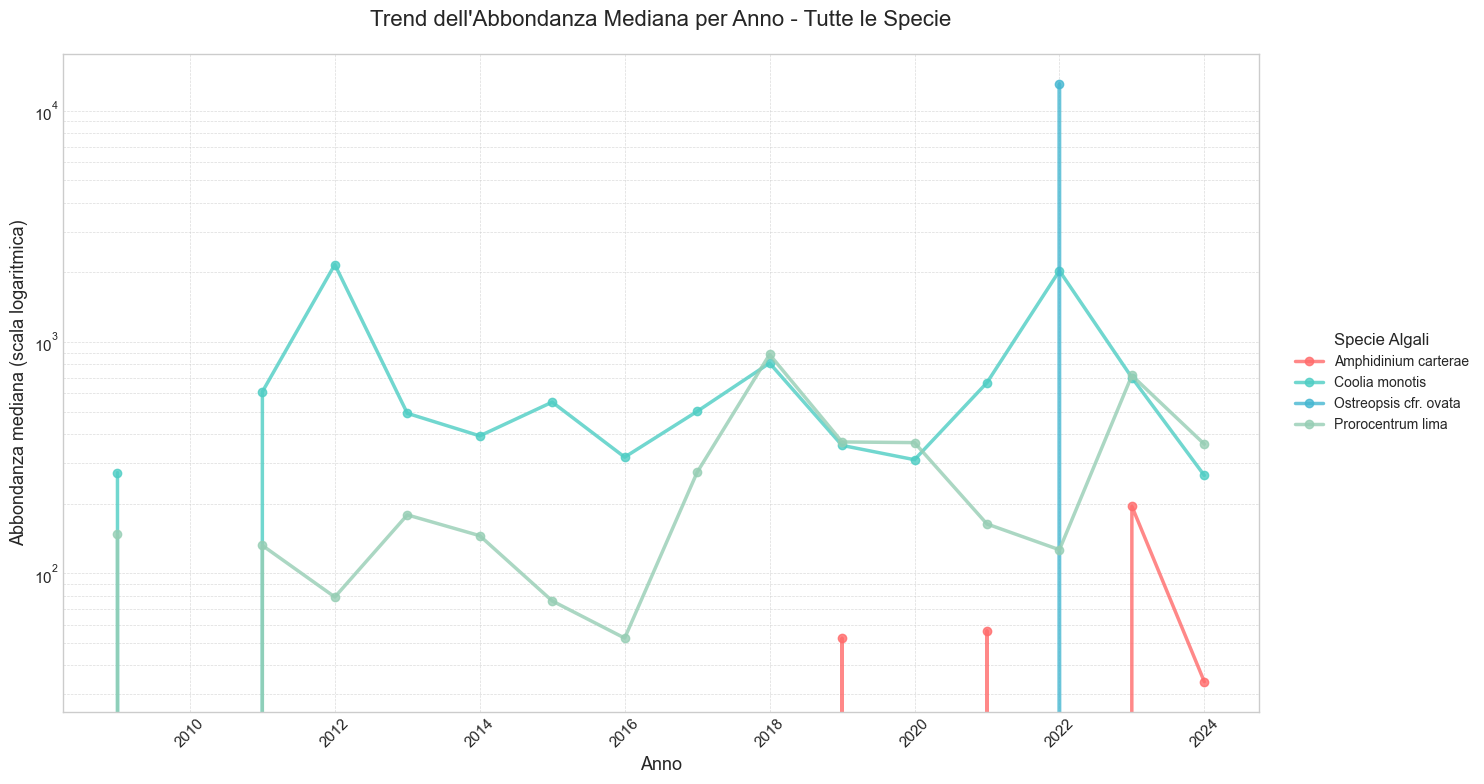

In [245]:
# calcolo l'abbondanza mediana per anno per ogni specie
trend_data = {}
for specie in algae_bentonic:
    trend_annuale = df.groupby("ANNO")[specie].median()
    #  rimuovo NaN
    trend_annuale = trend_annuale.dropna()
    trend_data[specie] = trend_annuale


plt.figure(figsize=(15, 8))

for i, specie in enumerate(algae_bentonic):
    if specie in trend_data and len(trend_data[specie]) > 0:
        color = custom_colors[i % len(custom_colors)]

        plt.plot(
            trend_data[specie].index,
            trend_data[specie].values,
            marker="o",
            label=specie.replace("_cell_gr", ""),
            linestyle="-",
            linewidth=2.5,
            markersize=6,
            color=color,
            alpha=0.8,
        )

plt.yscale("log")
plt.title(
    "Trend dell'Abbondanza Mediana per Anno - Tutte le Specie", fontsize=16, pad=20
)
plt.xlabel("Anno", fontsize=13)
plt.ylabel("Abbondanza mediana (scala logaritmica)", fontsize=13)

plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# legenda
plt.legend(
    title="Specie Algali", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=10
)

plt.tight_layout()
plt.show()

O. ovata fa dei bloom molto importanti in termini di abbondanza, come abbiamo riscontrato nei grafici precedenti. <br> Per quale motivo compare poche volte, seppur considerando la mediana invece che la media?


In [246]:
# verifica per anno
ovata_columns = [
    col for col in df.columns if "ovata" in col.lower()
]  # prendo sia cell_gr che cell_l
yearly_data = df.groupby("ANNO")[ovata_columns].agg(["count", "sum", "median"])

# filtro solo per anni con dati
has_data_mask = (yearly_data.xs("sum", level=1, axis=1) > 0).any(axis=1)
yearly_data_filtered = yearly_data[has_data_mask]

for col in ovata_columns:
    # calcolo l'abbondanza mediana per anno per ogni specie
    col_data = df.groupby("ANNO")[col].agg(["count", "sum", "median"])
    col_data_filtered = col_data[col_data["sum"] > 0]
    print(col_data_filtered)

      count        sum   median
ANNO                           
2009     24     1177.0      0.0
2010     65      485.0      0.0
2011     35  2910706.0      0.0
2012     18  2530711.0      0.0
2013     21  1639369.0      0.0
2014     22   438371.0      0.0
2015     18   316346.0      0.0
2016     20   235790.0      0.0
2017     20    31712.0      0.0
2018     20   183449.0      0.0
2019     28  4424350.0      0.0
2020     32   453264.0      0.0
2021     28    55348.0      0.0
2022     28  1147185.0  13079.5
2023     24   239729.0      0.0
2024     23   405251.0      0.0
      count        sum  median
ANNO                          
2009     11  3081836.0     0.0
2010     65      240.0     0.0
2011     35    45552.0     0.0
2012     18    87480.0     0.0
2013     21     7520.0     0.0
2014     22      900.0     0.0
2015     18     9640.0     0.0
2016     20     7120.0     0.0
2017     20     6640.0     0.0
2018     20    10440.0     0.0
2019     28    17320.0     0.0
2020     32    68880.

Ci sono talmente tanti 0 (dati di <strong>ASSENZA</strong>) che nonostante i bloom di O. ovata siano intensi nel momento in cui avvengono, non vengono rilevati considerando la mediana (o la media). <br> Dobbiamo trovare un modo alternativo di rappresentare i trend annuali di bloom algali.


Primo possibile approccio:<br> Calcoliamo il conteggio dei giorni di presenza per anno (quando l'abbondanza è maggiore di 0)


In [247]:
# nuova palette per grafici con linee - quella precedente non consentiva di distinguere le specie
algae_palette = ["#89CFF0", "#98D8AA", "#F4978E", "#F8D5A9"]

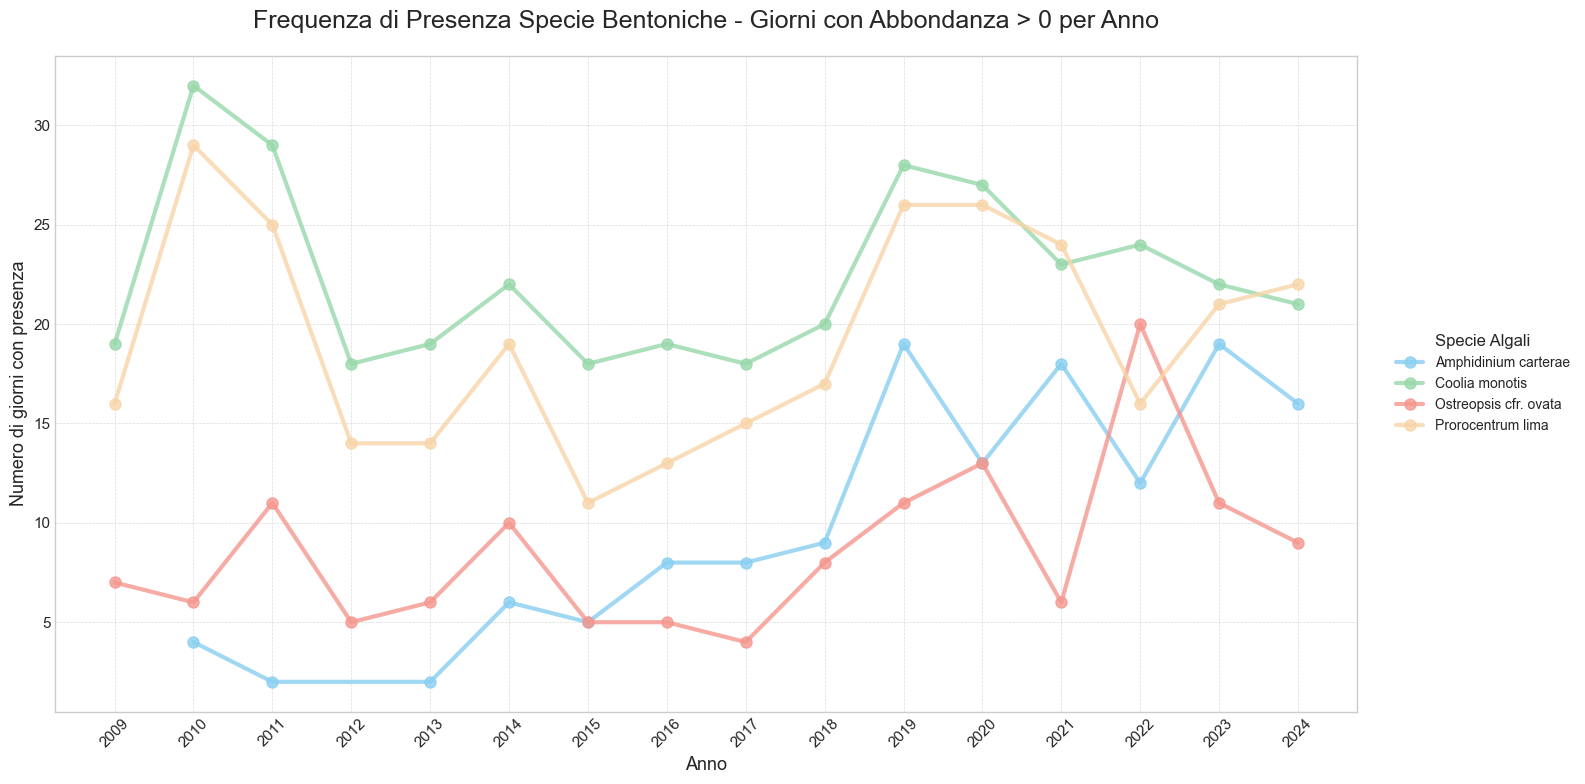

In [248]:
# calcolo i giorni di presenza per ogni specie per anno
presence_data = {}
for specie in algae_bentonic:
    # solo i giorni con abbondanza > 0
    presence_by_year = df[df[specie] > 0].groupby("ANNO").size()
    presence_data[specie] = presence_by_year


plt.figure(figsize=(16, 8))

for i, specie in enumerate(algae_bentonic):
    if specie in presence_data and len(presence_data[specie]) > 0:

        anni = presence_data[specie].index
        giorni_presenza = presence_data[specie].values

        # colore palette
        base_color = algae_palette[i % len(algae_palette)]

        linewidth = 3
        markersize = 8
        alpha = 0.8

        plt.plot(
            anni,
            giorni_presenza,
            marker="o",
            label=specie.replace("_cell_gr", ""),
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=base_color,
            alpha=alpha,
        )

plt.title(
    "Frequenza di Presenza Specie Bentoniche - Giorni con Abbondanza > 0 per Anno",
    fontsize=18,
    pad=20,
)
plt.xlabel("Anno", fontsize=13)
plt.ylabel("Numero di giorni con presenza", fontsize=13)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# per migliorare la visualizzazione degli anni
if "ANNO" in df.columns:
    anni_disponibili = sorted(df["ANNO"].unique())
    plt.xticks(anni_disponibili, rotation=45)

plt.legend(
    title="Specie Algali", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=10
)

plt.tight_layout()
plt.show()

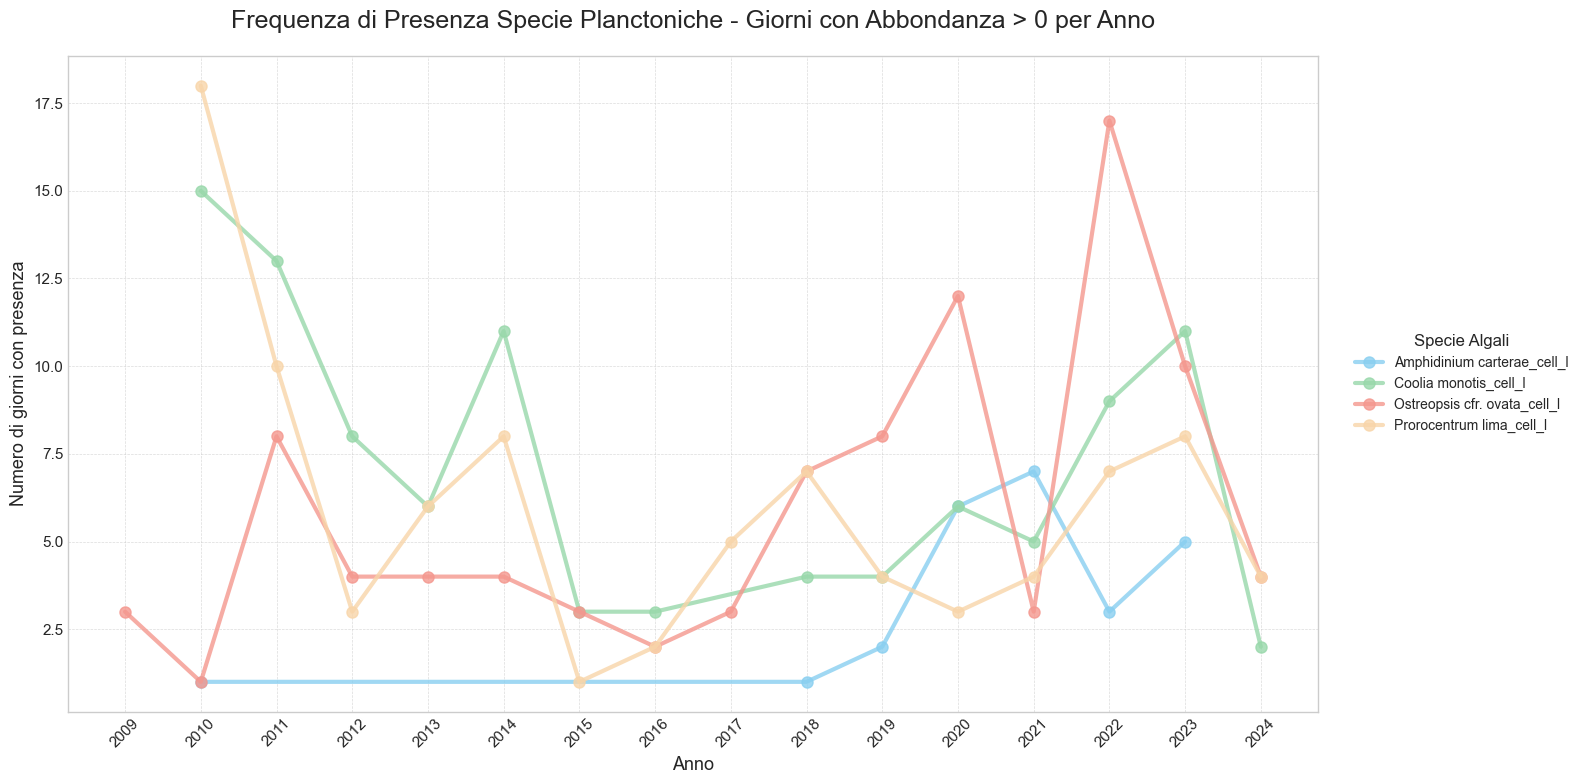

In [249]:
# calcolo i giorni di presenza per ogni specie per anno
presence_data = {}
for specie in algae_planctonic:
    # solo i giorni con abbondanza > 0
    presence_by_year = df[df[specie] > 0].groupby("ANNO").size()
    presence_data[specie] = presence_by_year


plt.figure(figsize=(16, 8))

for i, specie in enumerate(algae_planctonic):
    if specie in presence_data and len(presence_data[specie]) > 0:

        anni = presence_data[specie].index
        giorni_presenza = presence_data[specie].values

        # colore palette
        base_color = algae_palette[i % len(algae_palette)]

        linewidth = 3
        markersize = 8
        alpha = 0.8

        plt.plot(
            anni,
            giorni_presenza,
            marker="o",
            label=specie.replace("_cell_gr", ""),
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=base_color,
            alpha=alpha,
        )

plt.title(
    "Frequenza di Presenza Specie Planctoniche - Giorni con Abbondanza > 0 per Anno",
    fontsize=18,
    pad=20,
)
plt.xlabel("Anno", fontsize=13)
plt.ylabel("Numero di giorni con presenza", fontsize=13)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# per migliorare la visualizzazione degli anni
if "ANNO" in df.columns:
    anni_disponibili = sorted(df["ANNO"].unique())
    plt.xticks(anni_disponibili, rotation=45)

plt.legend(
    title="Specie Algali", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=10
)

plt.tight_layout()
plt.show()

Secondo Approccio: <br> Calcoliamo la media dell'abbondanza per anno, considerando solo i giorni di presenza. In questo modo possiamo capire quali solo le specie più abbondanti (quando presenti) e se i bloom algali sono diventati più intensi nel corso degli anni.


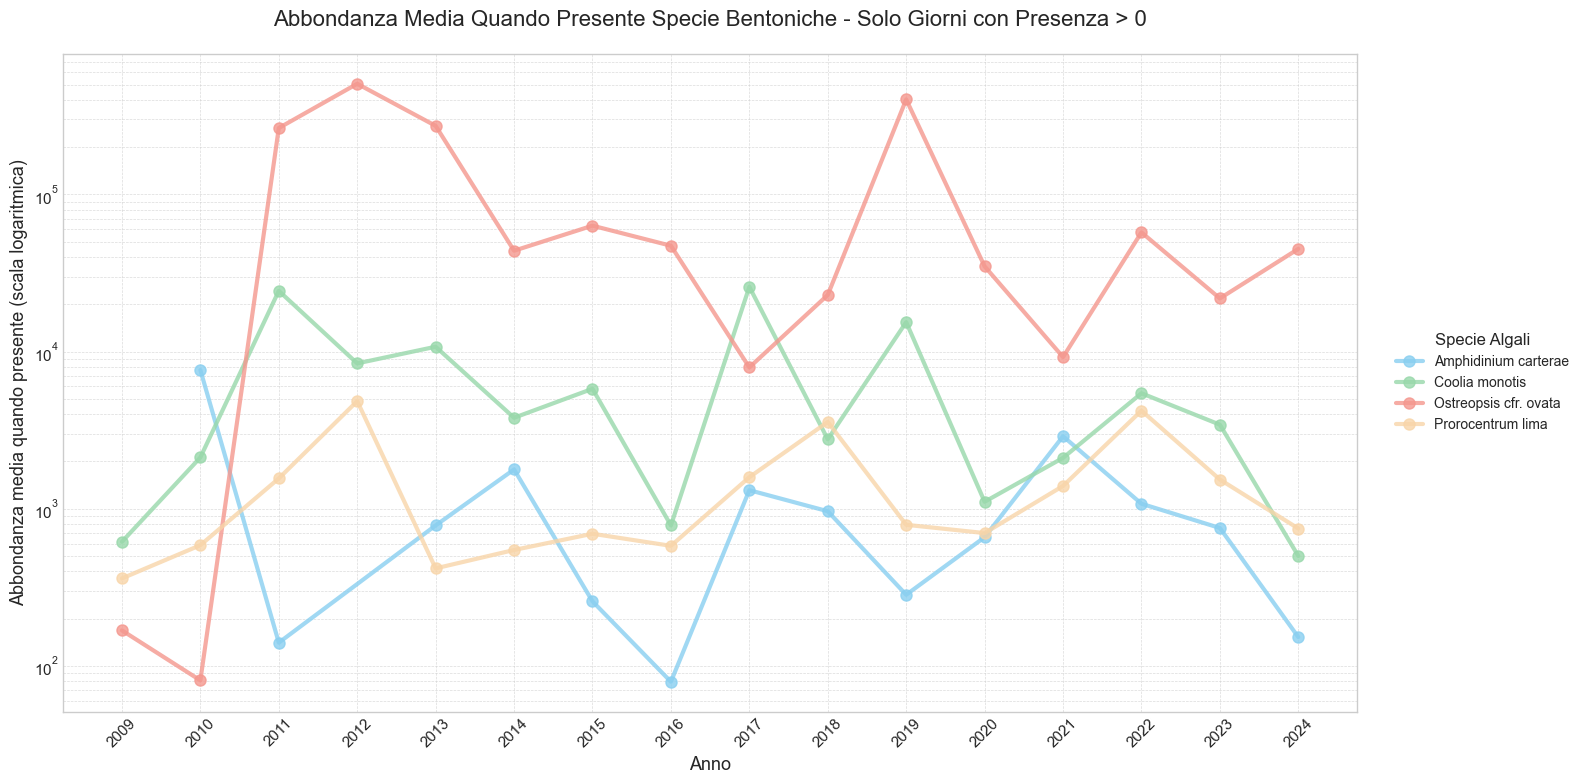

In [250]:
# abbondanza media quando presente
abundance_when_present = {}
for specie in algae_bentonic:
    # solo i giorni con abbondanza > 0
    species_data = df[df[specie] > 0]
    if len(species_data) > 0:
        abundance_by_year = species_data.groupby("ANNO")[specie].mean()
        abundance_when_present[specie] = abundance_by_year

plt.figure(figsize=(16, 8))

for i, specie in enumerate(algae_bentonic):
    if specie in abundance_when_present and len(abundance_when_present[specie]) > 0:

        anni = abundance_when_present[specie].index
        abbondanza_media = abundance_when_present[specie].values

        base_color = algae_palette[i % len(algae_palette)]

        plt.plot(
            anni,
            abbondanza_media,
            marker="o",
            label=specie.replace("_cell_gr", ""),
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=base_color,
            alpha=alpha,
        )

plt.yscale("log")  # scala logaritmica
plt.title(
    "Abbondanza Media Quando Presente Specie Bentoniche - Solo Giorni con Presenza > 0",
    fontsize=16,
    pad=20,
)
plt.xlabel("Anno", fontsize=13)
plt.ylabel("Abbondanza media quando presente (scala logaritmica)", fontsize=13)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


if "ANNO" in df.columns:
    anni_disponibili = sorted(df["ANNO"].unique())
    plt.xticks(anni_disponibili, rotation=45)

plt.legend(
    title="Specie Algali", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=10
)

plt.tight_layout()
plt.show()

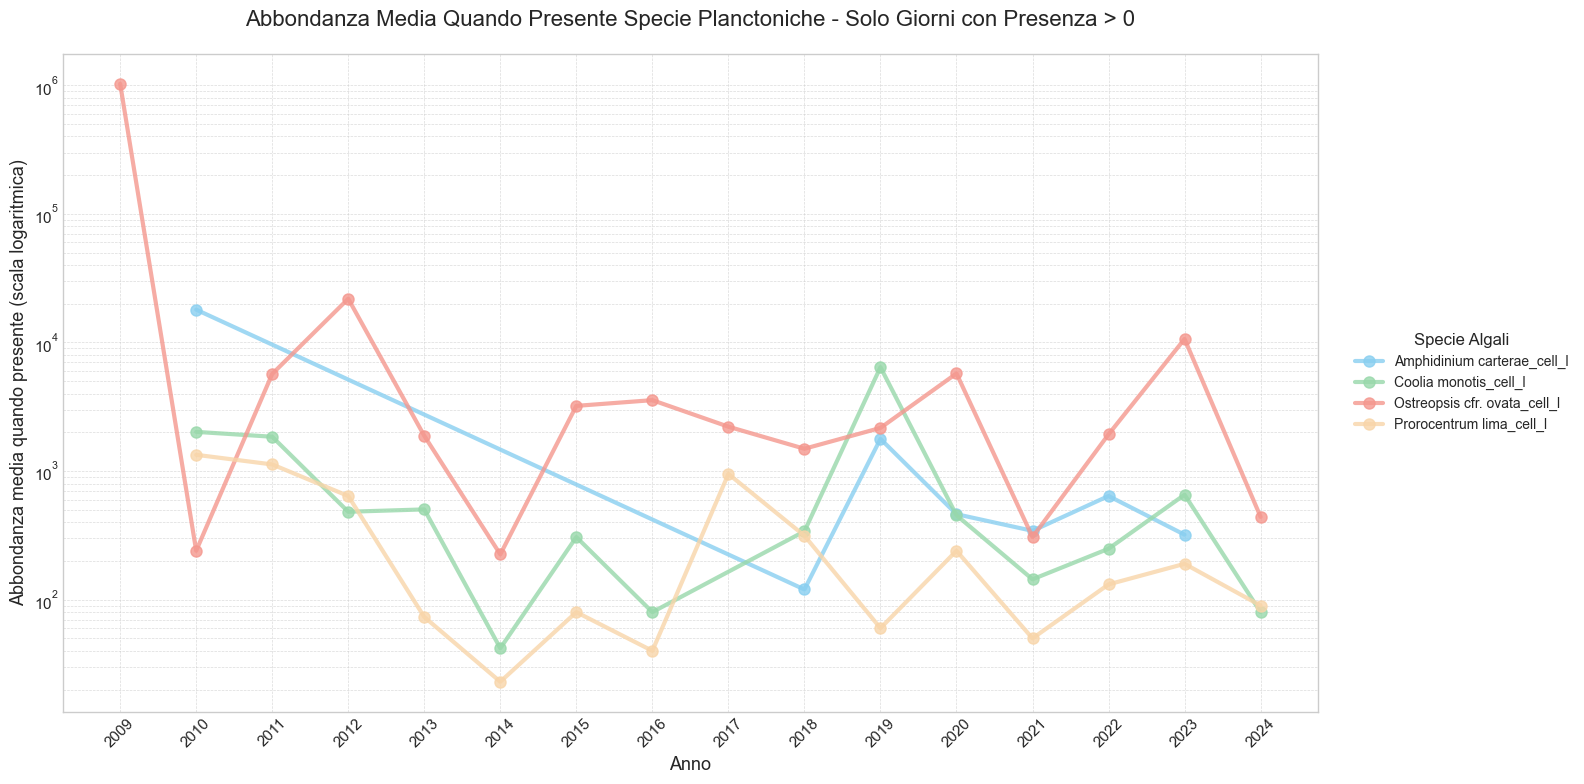

In [251]:
# abbondanza media quando presente
abundance_when_present = {}
for specie in algae_planctonic:
    # solo i giorni con abbondanza > 0
    species_data = df[df[specie] > 0]
    if len(species_data) > 0:
        abundance_by_year = species_data.groupby("ANNO")[specie].mean()
        abundance_when_present[specie] = abundance_by_year

plt.figure(figsize=(16, 8))

for i, specie in enumerate(algae_planctonic):
    if specie in abundance_when_present and len(abundance_when_present[specie]) > 0:

        anni = abundance_when_present[specie].index
        abbondanza_media = abundance_when_present[specie].values

        base_color = algae_palette[i % len(algae_palette)]

        plt.plot(
            anni,
            abbondanza_media,
            marker="o",
            label=specie.replace("_cell_gr", ""),
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=base_color,
            alpha=alpha,
        )

plt.yscale("log")  # scala logaritmica
plt.title(
    "Abbondanza Media Quando Presente Specie Planctoniche - Solo Giorni con Presenza > 0",
    fontsize=16,
    pad=20,
)
plt.xlabel("Anno", fontsize=13)
plt.ylabel("Abbondanza media quando presente (scala logaritmica)", fontsize=13)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

if "ANNO" in df.columns:
    anni_disponibili = sorted(df["ANNO"].unique())
    plt.xticks(anni_disponibili, rotation=45)

plt.legend(
    title="Specie Algali", loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=10
)

plt.tight_layout()
plt.show()

Grafici combinati di frequenza di presenza e abbondanza media per visualizzare meglio i risultati.


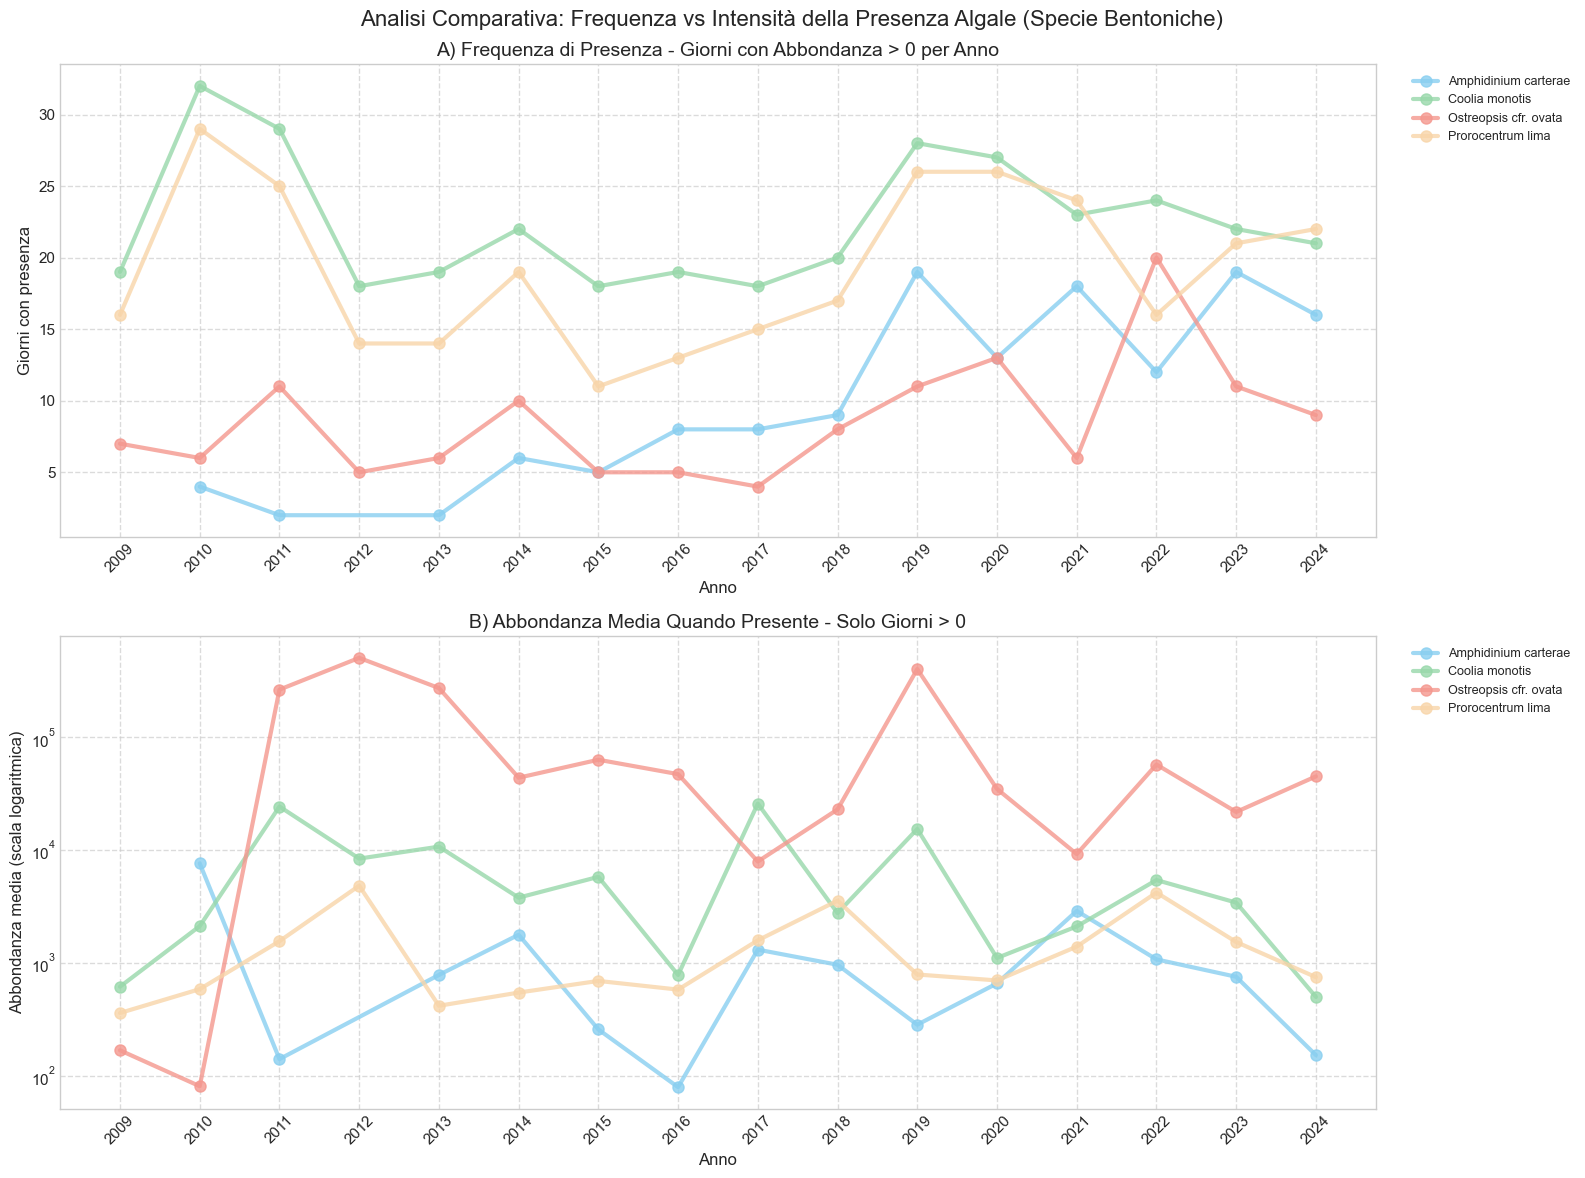

In [252]:
presence_data_bentonic = {}
abundance_when_present_bentonic = {}

for specie in algae_bentonic:
    # calcolo presenza
    presence_by_year = df[df[specie] > 0].groupby("ANNO").size()
    presence_data_bentonic[specie] = presence_by_year

    # calcolo abbondanza quando presente
    species_data = df[df[specie] > 0]
    if len(species_data) > 0:
        abundance_by_year = species_data.groupby("ANNO")[specie].mean()
        abundance_when_present_bentonic[specie] = abundance_by_year

linewidth = 3
markersize = 8
alpha = 0.8

# grafico combinato
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# 1 subplot: frequenza di presenza
for i, specie in enumerate(algae_bentonic):
    if specie in presence_data_bentonic and len(presence_data_bentonic[specie]) > 0:
        base_color = algae_palette[i % len(algae_palette)]

        ax1.plot(
            presence_data_bentonic[specie].index,
            presence_data_bentonic[specie].values,
            marker="o",
            label=specie.replace("_cell_gr", ""),
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=base_color,
            alpha=alpha,
        )

ax1.set_title(
    "A) Frequenza di Presenza - Giorni con Abbondanza > 0 per Anno", fontsize=14
)
ax1.set_xlabel("Anno", fontsize=12)
ax1.set_ylabel("Giorni con presenza", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

# 2 subplot: abbondanza quando presente
for i, specie in enumerate(algae_bentonic):
    if (
        specie in abundance_when_present_bentonic
        and len(abundance_when_present_bentonic[specie]) > 0
    ):
        base_color = algae_palette[i % len(algae_palette)]

        ax2.plot(
            abundance_when_present_bentonic[specie].index,
            abundance_when_present_bentonic[specie].values,
            marker="o",
            label=specie.replace("_cell_gr", ""),
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=base_color,
            alpha=alpha,
        )

ax2.set_yscale("log")
ax2.set_title("B) Abbondanza Media Quando Presente - Solo Giorni > 0", fontsize=14)
ax2.set_xlabel("Anno", fontsize=12)
ax2.set_ylabel("Abbondanza media (scala logaritmica)", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

if "ANNO" in df.columns:
    anni_disponibili = sorted(df["ANNO"].unique())
    ax1.set_xticks(anni_disponibili)
    ax1.tick_params(axis="x", rotation=45)
    ax2.set_xticks(anni_disponibili)
    ax2.tick_params(axis="x", rotation=45)

plt.suptitle(
    "Analisi Comparativa: Frequenza vs Intensità della Presenza Algale (Specie Bentoniche)",
    fontsize=16,
    y=0.98,
)
plt.tight_layout()
plt.show()

<h3>Analisi Temporale delle Specie Bentoniche</h3>
<p>L'analisi dei dati raccolti negli anni suggerisce che la presenza di queste alghe sul fondale si stia consolidando.</p>
<h4>A) Frequenza di Rilevamento (Quante volte vengono trovate)</h4>
<ul>
<li>
<strong>Tendenza generale:</strong> Con il passare degli anni, quasi tutte le specie vengono trovate sempre più spesso. In particolare, <i>Amphidinium carterae</i> e, in misura minore, <i>Prorocentrum lima</i> mostrano una crescita costante nella loro frequenza.
</li>
<li>
<strong>La specie più comune:</strong> <i>Coolia monotis</i> si conferma la specie rilevata più di frequente per quasi tutto il periodo analizzato, sebbene la sua presenza mostri forti oscillazioni da un anno all'altro.
</li>
</ul>
<h4>B) Intensità Media delle Fioriture (Quanto sono abbondanti quando presenti)</h4>
<ul>
<li>
<strong>Nessun andamento chiaro:</strong> A differenza della frequenza, l'intensità media delle fioriture non mostra una crescita costante, ma è caratterizzata da una forte variabilità annuale.
</li>
<li>
<strong>Anni con picchi eccezionali:</strong> Si notano picchi di abbondanza molto alti in anni specifici (come il 2012 e il 2019), spesso per più specie contemporaneamente. Questo suggerisce che in quei periodi le condizioni ambientali fossero particolarmente favorevoli alla loro crescita.
</li>
<li>
<strong>La specie più intensa:</strong> Quando fiorisce, <i>O. ovata</i> tende a raggiungere le concentrazioni medie più elevate.
</li>
</ul>


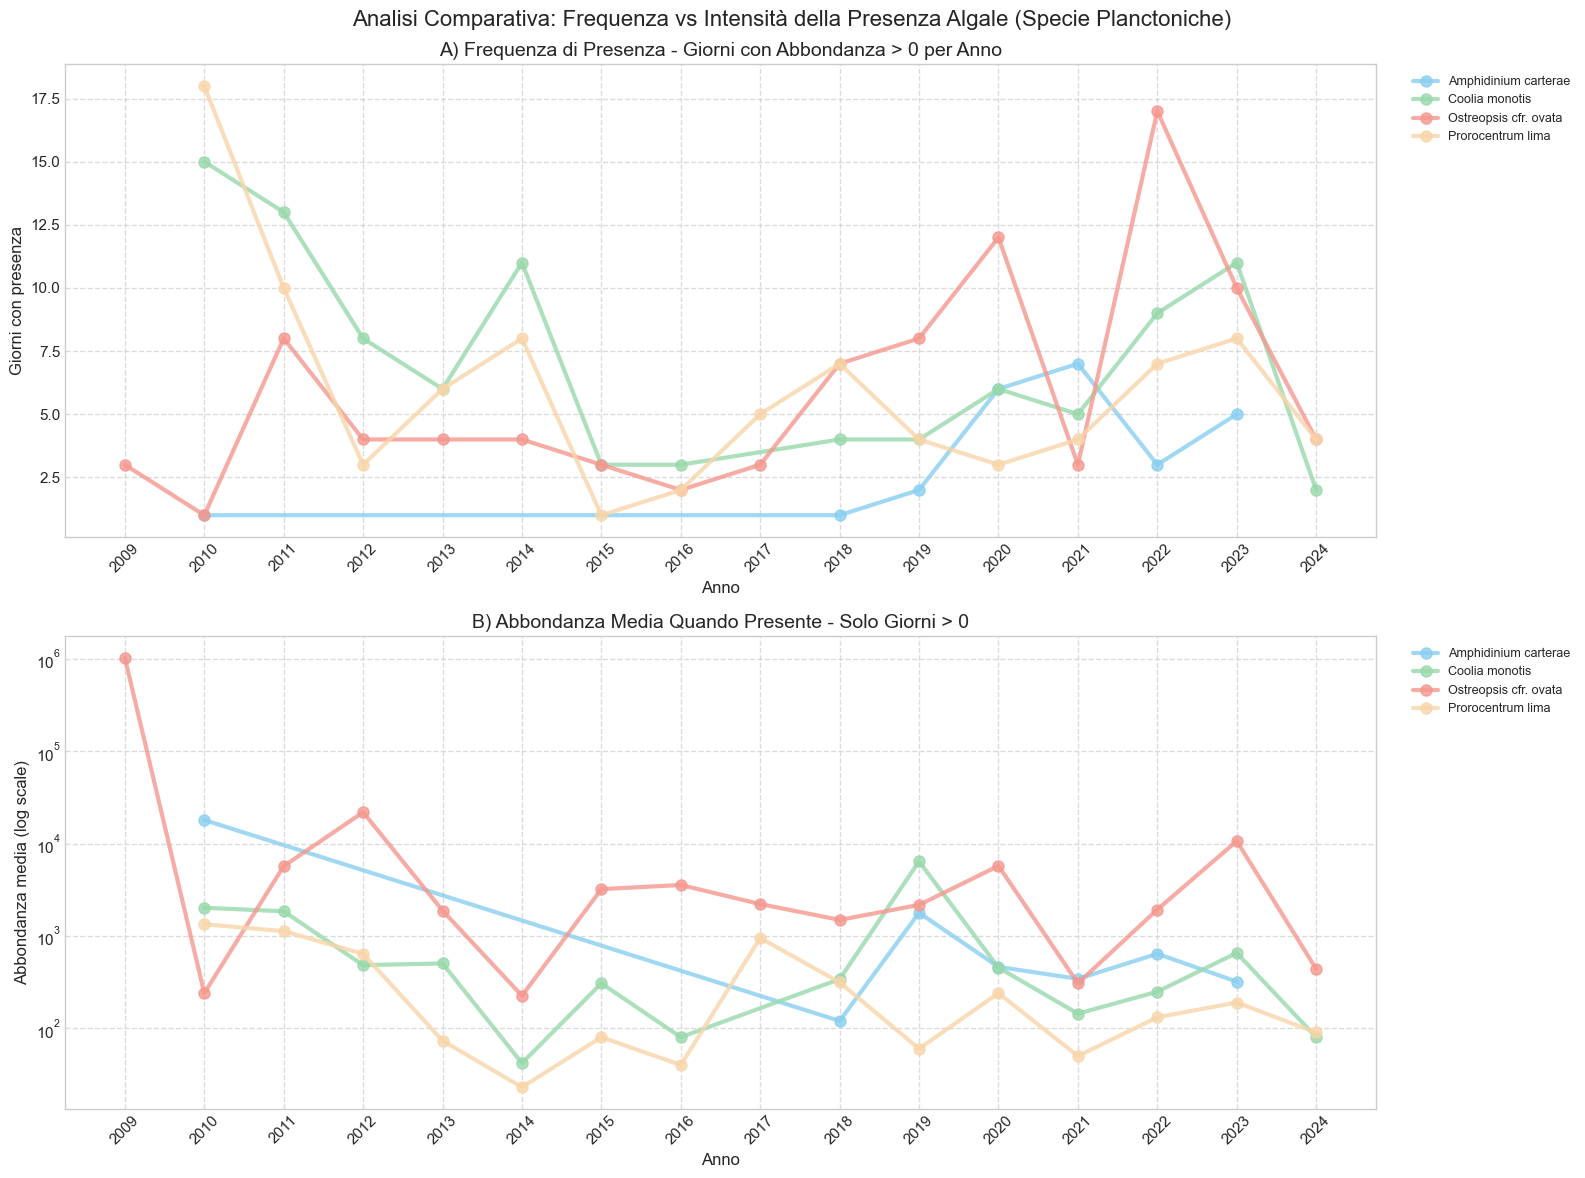

In [253]:
presence_data_planctonic = {}
abundance_when_present_planctonic = {}

for specie in algae_planctonic:
    # calcolo presenza
    presence_by_year = df[df[specie] > 0].groupby("ANNO").size()
    presence_data_planctonic[specie] = presence_by_year

    # calcolo abbondanza quando presente
    species_data = df[df[specie] > 0]
    if len(species_data) > 0:
        abundance_by_year = species_data.groupby("ANNO")[specie].mean()
        abundance_when_present_planctonic[specie] = abundance_by_year

linewidth = 3
markersize = 8
alpha = 0.8

# grafico combinato
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# 1 subplot: frequenza di presenza
for i, specie in enumerate(algae_planctonic):
    if specie in presence_data_planctonic and len(presence_data_planctonic[specie]) > 0:
        base_color = algae_palette[i % len(algae_palette)]

        ax1.plot(
            presence_data_planctonic[specie].index,
            presence_data_planctonic[specie].values,
            marker="o",
            label=specie.replace("_cell_l", ""),
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=base_color,
            alpha=alpha,
        )

ax1.set_title(
    "A) Frequenza di Presenza - Giorni con Abbondanza > 0 per Anno", fontsize=14
)
ax1.set_xlabel("Anno", fontsize=12)
ax1.set_ylabel("Giorni con presenza", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.7)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

# 2 subplot: abbondanza quando presente
for i, specie in enumerate(algae_planctonic):
    if (
        specie in abundance_when_present_planctonic
        and len(abundance_when_present_planctonic[specie]) > 0
    ):
        base_color = algae_palette[i % len(algae_palette)]

        ax2.plot(
            abundance_when_present_planctonic[specie].index,
            abundance_when_present_planctonic[specie].values,
            marker="o",
            label=specie.replace("_cell_l", ""),
            linestyle="-",
            linewidth=linewidth,
            markersize=markersize,
            color=base_color,
            alpha=alpha,
        )

ax2.set_yscale("log")
ax2.set_title("B) Abbondanza Media Quando Presente - Solo Giorni > 0", fontsize=14)
ax2.set_xlabel("Anno", fontsize=12)
ax2.set_ylabel("Abbondanza media (log scale)", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.7)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)

if "ANNO" in df.columns:
    available_years = sorted(df["ANNO"].unique())
    ax1.set_xticks(available_years)
    ax1.tick_params(axis="x", rotation=45)
    ax2.set_xticks(available_years)
    ax2.tick_params(axis="x", rotation=45)

plt.suptitle(
    "Analisi Comparativa: Frequenza vs Intensità della Presenza Algale (Specie Planctoniche)",
    fontsize=16,
    y=0.98,
)
plt.tight_layout()
plt.show()

<h3>Analisi delle Specie Planctoniche (nell'acqua)</h3>
<p>La presenza di alghe libere nell'acqua (planctoniche) è più sporadica e legata a singoli eventi di fioritura (bloom).</p>
<h4>A) Frequenza di Rilevamento (Quante volte vengono trovate)</h4>
<ul>
<li>
In generale, le alghe vengono trovate libere nell'acqua <strong>meno spesso e in modo più irregolare</strong> rispetto a quando sono sul fondale.
</li>
<li>
Non si osserva una crescita costante nel tempo. La loro presenza è caratterizzata da <strong>picchi isolati</strong> in anni particolari (ad esempio nel 2010 e nel 2022).
</li>
<li>
<em>Amphidinium carterae</em> è stata rilevata molto raramente, con un leggero aumento solo negli ultimi anni. Anche <em>Ostreopsis ovata</em> mostra una tendenza a comparire più spesso, ma in modo discontinuo.
</li>
</ul>
<h4>B) Intensità Media delle Fioriture (Quanto sono abbondanti quando presenti)</h4>
<ul>
<li>
L'intensità delle fioriture nell'acqua è <strong>estremamente variabile</strong> e non segue un andamento preciso.
</li>
<li>
Si registrano picchi di abbondanza molto elevati, ma si tratta di <strong>eventi rari e concentrati solo in alcuni anni</strong>.
</li>
</ul>


<h3>Alpha / Beta Diversity</h3>


Calcolo Shannon Diversity Index per capire quanto sono diversi gli ambienti di campionamento. <br>L'indice di Shannon-Wiener, è una misura statistica utilizzata in ecologia per quantificare la diversità di una comunità biologica, tenendo conto sia del numero di specie presenti (ricchezza) che dell'uniformità della loro distribuzione (equità).


C:\Users\39393\AppData\Local\Temp\ipykernel_8964\4251108336.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shannon_clean["MESE"] = df_shannon_clean["MESE"].map(month_map)


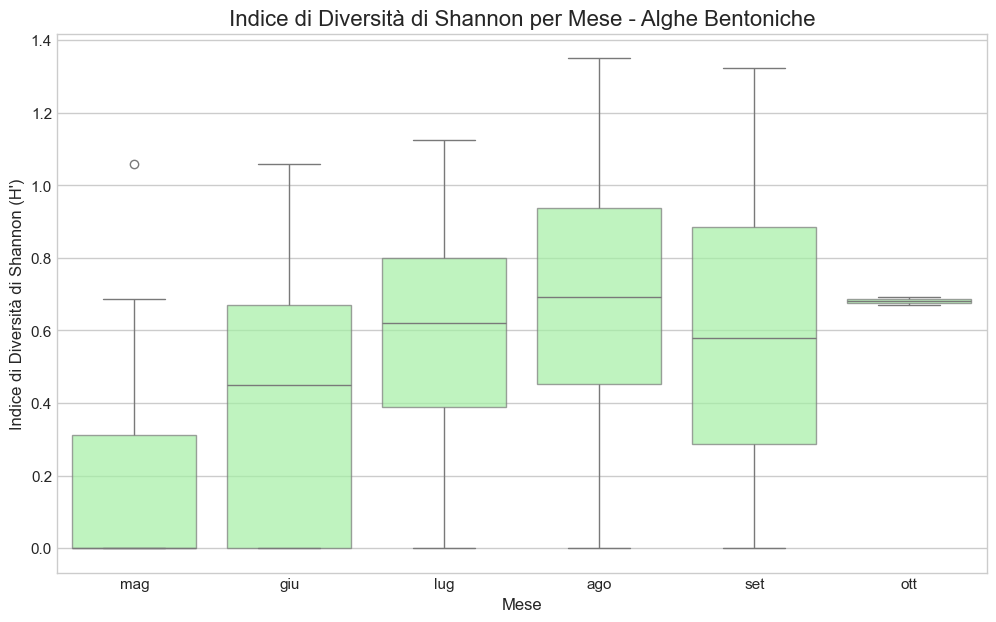

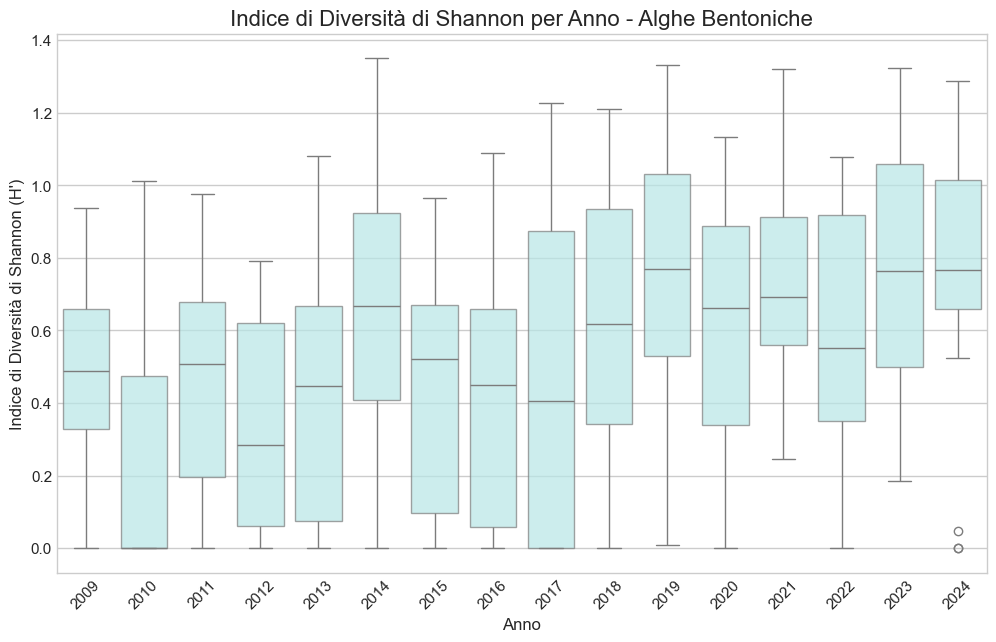

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\4251108336.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shannon_clean["STAZIONE_LOCALITA"] = (
C:\Users\39393\AppData\Local\Temp\ipykernel_8964\4251108336.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Anno", bbox_to_anchor=(1.02, 1), loc="upper left")


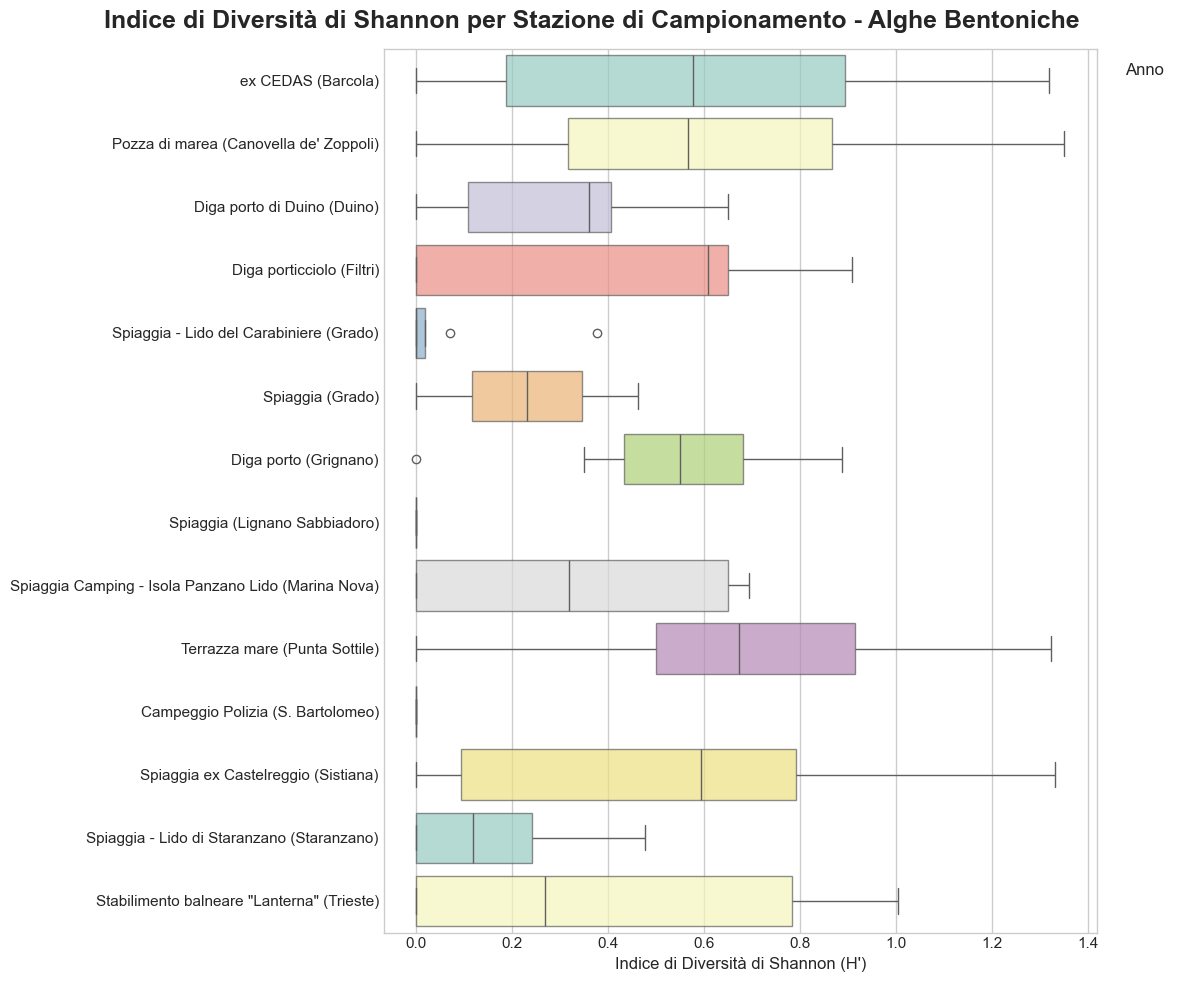

In [254]:
# calcolo shannon diversity index per sp bentoniche
def calculate_shannon(row):
    # calcolo counts colonna alghe bentoniche
    counts = row[algae_bentonic].copy()
    # rimuovo nan e tutti valori = 0
    counts = counts.dropna()
    counts = counts[counts > 0]

    if len(counts) > 0:
        # converto numpy array float altrimenti non fx con entropy
        counts_array = np.array(counts, dtype=float)
        return entropy(counts_array, base=math.e)
    return np.nan


# applico fx a ciascun campione
df["Shannon_Diversity"] = df.apply(calculate_shannon, axis=1)

# plot
# filtro per non avere nan
df_shannon_clean = df.dropna(subset=["Shannon_Diversity"])

df_shannon_clean["MESE"] = df_shannon_clean["MESE"].map(month_map)

sns.set_style("whitegrid")

# 1. Shannon Diversity per mese
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_shannon_clean,
    x="MESE",
    y="Shannon_Diversity",
    color="#98FB98",
    boxprops={"alpha": 0.7},
)
plt.title("Indice di Diversità di Shannon per Mese - Alghe Bentoniche", fontsize=16)
plt.xlabel("Mese", fontsize=12)
plt.ylabel("Indice di Diversità di Shannon (H')", fontsize=12)
plt.show()

# 2. Shannon Diversity per anno
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_shannon_clean,
    x="ANNO",
    y="Shannon_Diversity",
    color="#AFEEEE",
    boxprops={"alpha": 0.7},
)
plt.title("Indice di Diversità di Shannon per Anno - Alghe Bentoniche", fontsize=16)
plt.xlabel("Anno", fontsize=12)
plt.ylabel("Indice di Diversità di Shannon (H')", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# inserisco nome località nel grafico x maggiore chiarezza
localita_name = (
    df_shannon_clean["LOCALITA'"].astype(str).str.split("-").str[0].str.strip()
)

df_shannon_clean["STAZIONE_LOCALITA"] = (
    df_shannon_clean["STAZIONE"].astype(str) + " (" + localita_name + ")"
)

# inverto gli assi per avere una migliore leggibilità
# 3. Shannon Diversity per stazione con assi invertiti
plt.figure(figsize=(12, 10))
sns.boxplot(
    data=df_shannon_clean,
    x="Shannon_Diversity",
    y="STAZIONE_LOCALITA",
    hue="STAZIONE_LOCALITA",
    palette="Set3",
    boxprops={"alpha": 0.7},
)
plt.suptitle(
    "Indice di Diversità di Shannon per Stazione di Campionamento - Alghe Bentoniche",
    fontsize=18,
    fontweight="bold",
)
plt.xlabel("Indice di Diversità di Shannon (H')", fontsize=12)
plt.ylabel("")
plt.legend(title="Anno", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

L'Indice di Shannon misura la biodiversità di un ecosistema. <br> Un valore più alto indica una maggiore diversità, il che significa che ci sono molte specie diverse e che gli individui sono distribuiti più equamente tra le varie specie. Un valore basso, al contrario, indica una bassa diversità (poche specie o la dominanza di una singola specie).


<h3>1. Diversità delle Specie Algali per mese (Indice di Shannon)</h3>
<p>Questo grafico illustra come la varietà delle specie di alghe cambia durante i mesi in cui sono stati effettuati i prelievi.</p>
<ul>
<li>
<strong>Andamento stagionale chiaro:</strong> Si nota un ciclo definito. La diversità è al minimo a maggio, all'inizio della stagione di campionamento.
</li>
<li>
<strong>Picco ad agosto:</strong> La varietà di specie aumenta gradualmente, raggiungendo il suo massimo in agosto. In questo mese, la comunità algale è più ricca ed equilibrata.
</li>
<li>
<strong>Calo successivo:</strong> Nei mesi di settembre e ottobre, la diversità torna a diminuire.
</li>
</ul>
<p>
Questa dinamica è probabilmente legata alle condizioni ambientali estive, che sono più favorevoli e consentono a un maggior numero di specie diverse di crescere contemporaneamente. In sintesi, la comunità algale mostra una forte stagionalità, con un picco di biodiversità nei mesi centrali estivi.
</p>


<h3>2. Diversità delle Specie Algali per Anno (Indice di Shannon)</h3>
<p>Questo grafico mostra come la varietà delle specie algali è cambiata nel corso degli anni.</p>
<ul>
<li>
<strong>Nessun andamento definito:</strong> Non si osserva una tendenza chiara di aumento o diminuzione della diversità nel lungo periodo. Al contrario, si notano <strong>forti variazioni da un anno all'altro</strong>.
</li>
<li>
<strong>Anni specifici:</strong> È possibile identificare anni con una diversità mediamente più alta (come il <strong>2014, 2019, 2023</strong>) e altri con una diversità più bassa (come il <strong>2010 o il 2016</strong>).
</li>
<li>
<strong>Variazioni interne all'anno:</strong> Anche l'escursione dei valori all'interno di un singolo anno può cambiare molto. Ad esempio, il 2017 mostra un'ampia gamma di valori, indicando che la diversità è stata molto variabile durante quella stagione.
</li>
</ul>
<p>
In sintesi, la diversità delle specie algali è soggetta a notevoli fluttuazioni annuali. Questo suggerisce che le condizioni ambientali su larga scala, che cambiano di anno in anno, giocano un ruolo fondamentale nel determinare la composizione della comunità algale.
</p>


<h3>3. Diversità delle Specie Algali per Stazione di Campionamento</h3>
<p>Questo grafico mostra come la diversità cambia a seconda del luogo di campionamento, rivelando la distribuzione spaziale delle specie.</p>
<ul>
<li>
<strong>Differenze evidenti tra le stazioni:</strong> Emerge in modo chiaro che alcuni luoghi sono veri e propri “hotspot” di biodiversità, mentre altri presentano costantemente una bassa varietà di specie.
</li>
<li>
<strong>Stazioni ad alta diversità:</strong> Siti come <strong>"Pozza di marea"</strong>, <strong>"Spiaggia ex Castelreggio"</strong> e <strong>"Campeggio Polizia"</strong> mostrano una ricchezza di specie mediamente molto alta.
</li>
<li>
<strong>Stazioni a bassa diversità:</strong> Al contrario, stazioni come <strong>"Spiaggia"</strong> o <strong>"Diga porto di Duino"</strong> hanno una diversità mediamente molto bassa e più costante. Questa bassa diversità potrebbe essere causata da fattori di stress locale (come inquinamento, forti correnti o tipo di fondale) che impediscono a molte specie di prosperare.
</li>
</ul>
<p>
In conclusione, la posizione è un fattore determinante. Le caratteristiche uniche di ogni sito (morfologia, esposizione al sole, impatto umano) influenzano in modo decisivo la composizione della comunità di alghe.
</p>


C:\Users\39393\AppData\Local\Temp\ipykernel_8964\816197802.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shannon_clean["MESE"] = df_shannon_clean["MESE"].map(month_map)


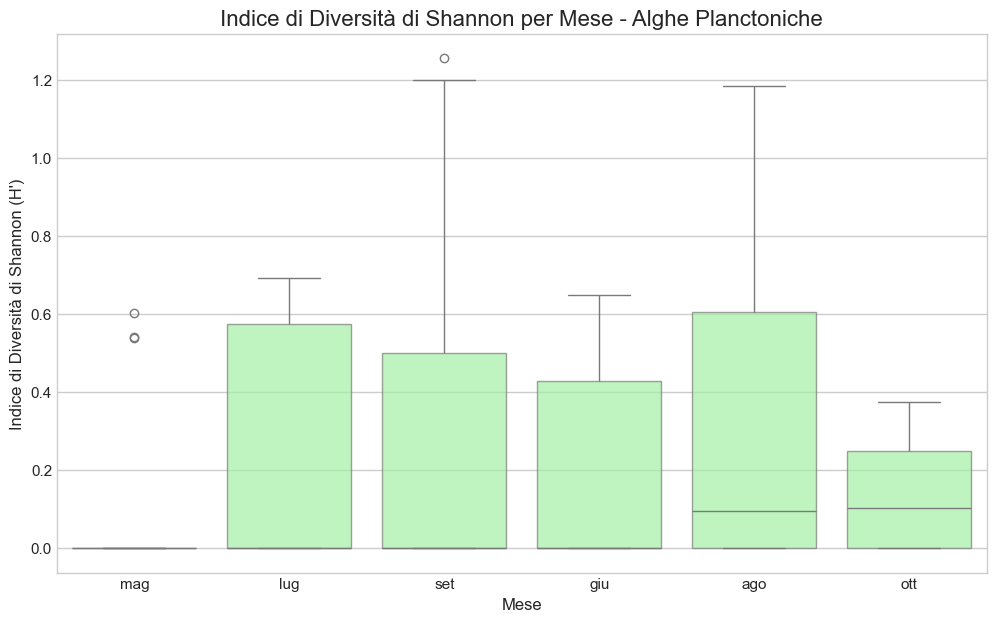

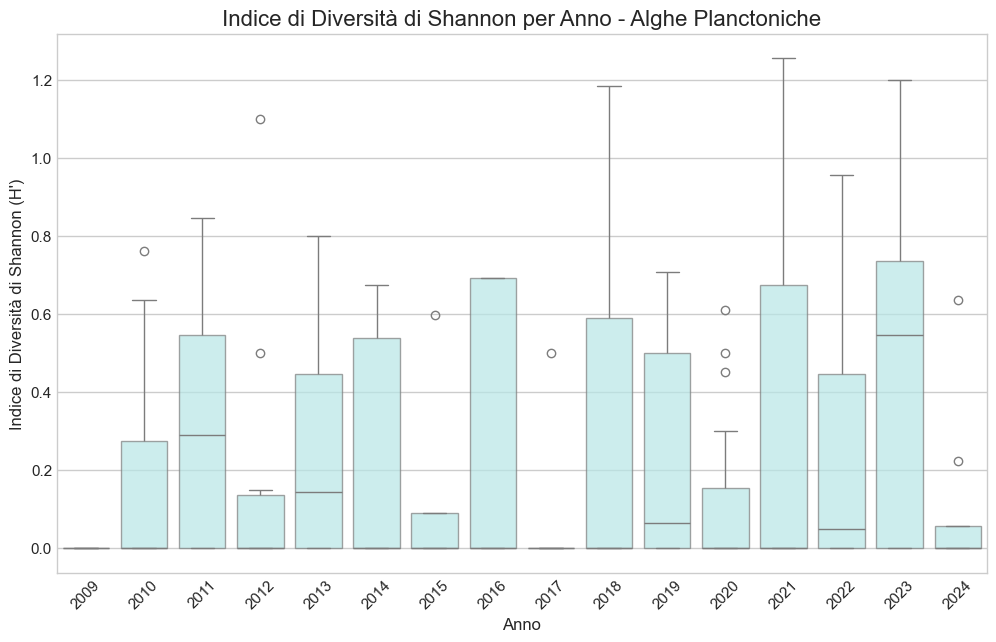

C:\Users\39393\AppData\Local\Temp\ipykernel_8964\816197802.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shannon_clean["STAZIONE_LOCALITA"] = (
C:\Users\39393\AppData\Local\Temp\ipykernel_8964\816197802.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Anno", bbox_to_anchor=(1.02, 1), loc="upper left")


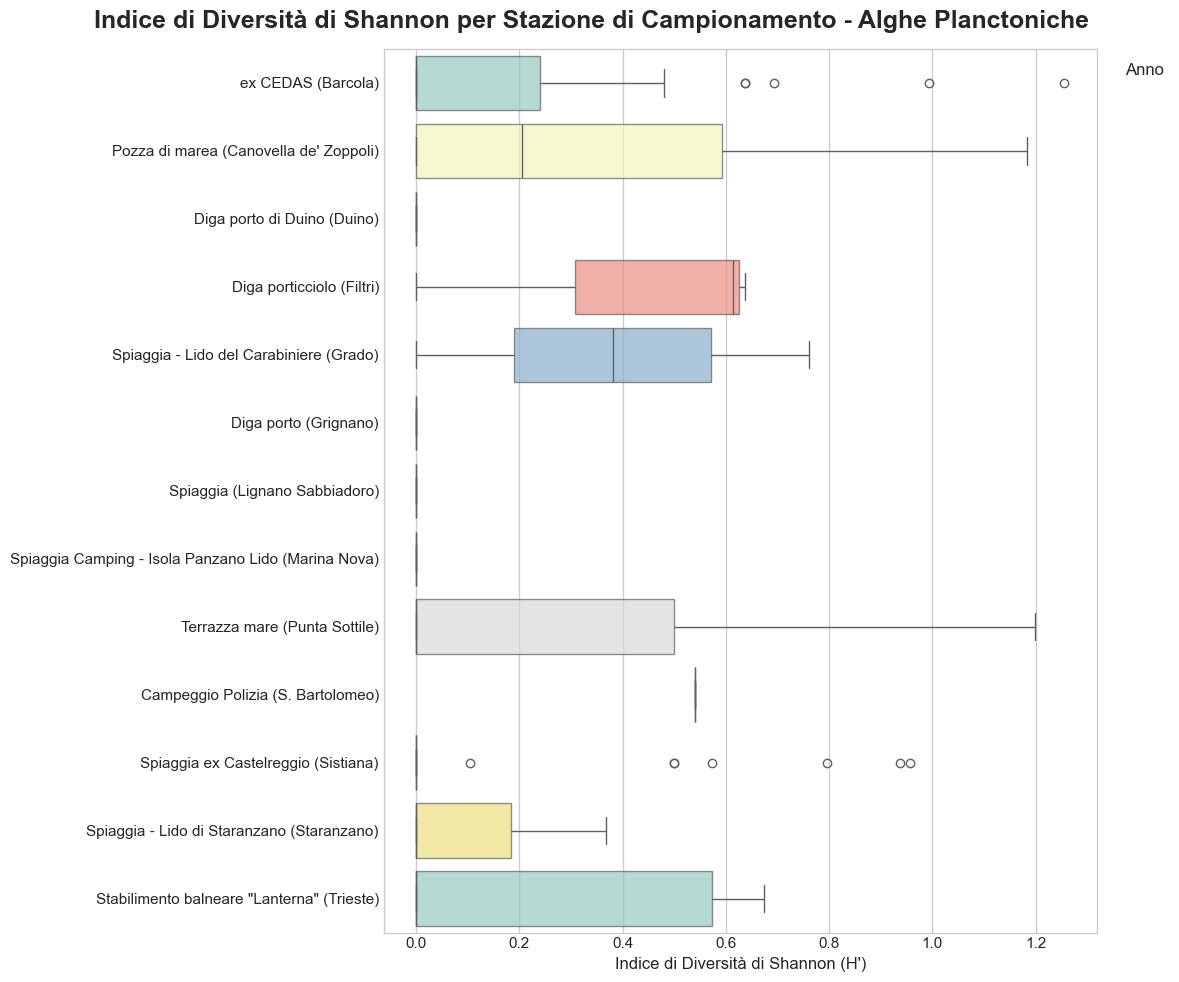

In [255]:
# calcolo shannon diversity index per sp planctoniche
def calculate_shannon(row):
    # calcolo counts colonna alghe planctoniche
    counts = row[algae_planctonic].copy()
    # rimuovo nan e tutti valori = 0
    counts = counts.dropna()
    counts = counts[counts > 0]

    if len(counts) > 0:
        # converto numpy array float altrimenti non fx con entropy
        counts_array = np.array(counts, dtype=float)
        return entropy(counts_array, base=math.e)
    return np.nan


# applico fx a ciascun campione
df["Shannon_Diversity"] = df.apply(calculate_shannon, axis=1)

# plot
# filtro per non avere nan
df_shannon_clean = df.dropna(subset=["Shannon_Diversity"])

df_shannon_clean["MESE"] = df_shannon_clean["MESE"].map(month_map)

sns.set_style("whitegrid")

# 1. Shannon Diversity per mese
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_shannon_clean,
    x="MESE",
    y="Shannon_Diversity",
    color="#98FB98",
    boxprops={"alpha": 0.7},
)
plt.title("Indice di Diversità di Shannon per Mese - Alghe Planctoniche", fontsize=16)
plt.xlabel("Mese", fontsize=12)
plt.ylabel("Indice di Diversità di Shannon (H')", fontsize=12)
plt.show()

# 2. Shannon Diversity per anno
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_shannon_clean,
    x="ANNO",
    y="Shannon_Diversity",
    color="#AFEEEE",
    boxprops={"alpha": 0.7},
)
plt.title("Indice di Diversità di Shannon per Anno - Alghe Planctoniche", fontsize=16)
plt.xlabel("Anno", fontsize=12)
plt.ylabel("Indice di Diversità di Shannon (H')", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# inserisco nome località nel grafico x maggiore chiarezza
localita_name = (
    df_shannon_clean["LOCALITA'"].astype(str).str.split("-").str[0].str.strip()
)

df_shannon_clean["STAZIONE_LOCALITA"] = (
    df_shannon_clean["STAZIONE"].astype(str) + " (" + localita_name + ")"
)

# inverto gli assi per avere una migliore leggibilità
# 3. Shannon Diversity per stazione con assi invertiti
plt.figure(figsize=(12, 10))
sns.boxplot(
    data=df_shannon_clean,
    x="Shannon_Diversity",
    y="STAZIONE_LOCALITA",
    hue="STAZIONE_LOCALITA",
    palette="Set3",
    boxprops={"alpha": 0.7},
)
plt.suptitle(
    "Indice di Diversità di Shannon per Stazione di Campionamento - Alghe Planctoniche",
    fontsize=18,
    fontweight="bold",
)
plt.xlabel("Indice di Diversità di Shannon (H')", fontsize=12)
plt.ylabel("")
plt.legend(title="Anno", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

<h3>Analisi della Diversità delle Specie Planctoniche (nell'acqua)</h3>
<h4>1. Diversità Mese per Mese</h4>
<p>Questo grafico mostra la stagionalità della diversità delle alghe libere nell'acqua.</p>
<ul>
<li>
<strong>Andamento irregolare:</strong> A differenza delle alghe bentoniche, qui non c'è una curva definita. La diversità è alta durante l'estate (luglio, agosto, settembre), ma con forti oscillazioni.
</li>
<li>
<strong>Crollo in autunno:</strong> Si osserva un netto calo della diversità a ottobre. Questo è tipico del fitoplancton, le cui popolazioni dipendono strettamente da luce e temperatura, fattori che diminuiscono rapidamente in autunno.
</li>
<li>
<strong>Grande variabilità:</strong> Il fitoplancton ha cicli di vita molto brevi (giorni). Le comunità possono quindi cambiare drasticamente in poche settimane, portando a un andamento a "picchi" improvvisi.
</li>
</ul>


<h4>2. Diversità Anno per Anno</h4>
<p>Questo grafico mostra le fluttuazioni della diversità del fitoplancton su un periodo di più anni.</p>
<ul>
<li>
<strong>Variabilità estrema:</strong> Se le fluttuazioni annuali delle alghe bentoniche erano evidenti, qui sono ancora più estreme. Si alternano anni di diversità relativamente alta (es. <strong>2016, 2021</strong>) ad anni in cui la diversità è quasi nulla (es. <strong>2015, 2024</strong>).
</li>
<li>
<strong>Forti oscillazioni anche all'interno dello stesso anno:</strong> In molti anni (es. 2012, 2017, 2022) si registrano enormi differenze di diversità tra un mese e l'altro.
</li>
<li>
<strong>Confronto con le comunità bentoniche:</strong> Le popolazioni planctoniche sono soggette instabili. Le comunità bentoniche, essendo fisse e più longeve, sono più stabili e resilienti.
</li>
</ul>


<h4>3. Diversità per Stazione di Campionamento</h4>
<p>Questo grafico mostra come la diversità del fitoplancton varia tra le diverse località.</p>
<ul>
<li>
<strong>Gli "hotspot" di diversità sono diversi:</strong> I luoghi più ricchi di specie planctoniche non coincidono con quelli più ricchi di specie bentoniche.
</li>
<li>
<strong>Fattori ambientali differenti:</strong>
<ul>
<li>La diversità <strong>bentonica</strong> è legata al tipo di fondale (roccia, sabbia), alla profondità e all'esposizione alle onde.</li>
<li>La diversità <strong>planctonica</strong> è invece legata alle caratteristiche dell'acqua: correnti, temperatura e nutrienti.</li>
</ul>
</li>
<li>
Questo spiega perché un'area con un fondale povero possa favorire il plancton, e viceversa.
</li>
</ul>


<h3>Considerazioni Generali:</h3>
<ul>
<li>
Le comunità <strong>bentoniche</strong> (sul fondale) sono <strong>più stabili</strong>, con cicli stagionali prevedibili e fluttuazioni più contenute.
</li>
<li>
Le comunità <strong>planctoniche</strong> (nell'acqua) sono <strong>estremamente dinamiche e instabili</strong>, con cambiamenti rapidi e imprevedibili.
</li>
<li>
Questo dimostra che all'interno dello stesso ecosistema marino convivono nicchie ecologiche molto diverse, regolate da fattori ambientali differenti.
</li>
</ul>


<h3>PCA</h3>


La PCA (Analisi delle Componenti Principali) è una tecnica statistica utilizzata per "vedere" più chiaramente le relazioni nascoste nei dati, mettendo in evidenza i pattern più importanti. <br>La PCA affronta il problema di avere un gran numero di variabili riducendo la dimensionalità dei dati.Trasforma un gran numero di variabili, potenzialmente correlate tra loro, in un numero minore di nuove variabili non correlate chiamate Componenti Principali. La prima componente principale (PC1) cattura la maggior parte della variabilità, la seconda (PC2) la maggior parte della variabilità rimanente.


C:\Users\39393\AppData\Local\Temp\ipykernel_8964\3845735458.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set2', len(unique_species))


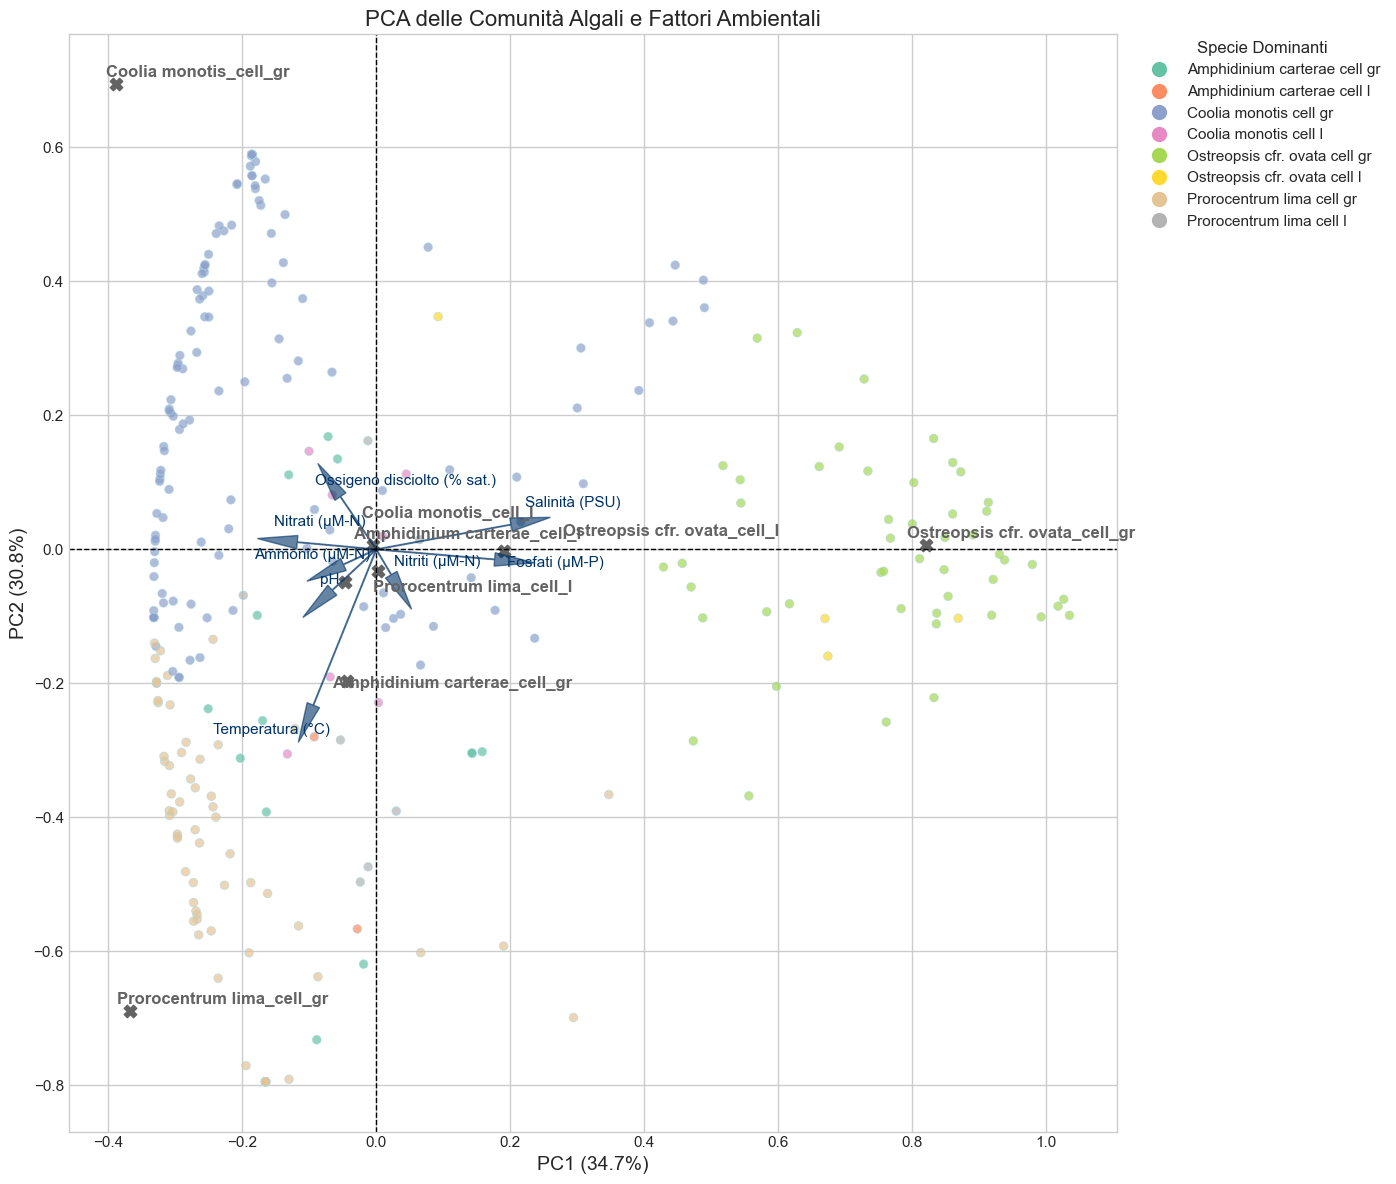

In [256]:
species_columns = [
    'Amphidinium carterae_cell_gr', 'Amphidinium carterae_cell_l',
    'Coolia monotis_cell_gr', 'Coolia monotis_cell_l',
    'Ostreopsis cfr. ovata_cell_gr', 'Ostreopsis cfr. ovata_cell_l',
    'Prorocentrum lima_cell_gr', 'Prorocentrum lima_cell_l'
]

#tengo solo le colonne che possono essere più informative
#in base ai grafici precedenti
environmental_columns = [
    'Ammonio (µM-N)', 'Fosfati (µM-P)', 'Nitrati (µM-N)',
    'Nitriti (µM-N)', 'Ossigeno disciolto (% sat.)', 'pH',
    'Salinità (PSU)', 'Temperatura (°C)'
]

available_env_columns = [col for col in environmental_columns if col in df.columns]
available_species_columns = [col for col in species_columns if col in df.columns]
columns_to_check = available_species_columns + available_env_columns
#copio il df e rimuovo nan
df_clean = df.dropna(subset=columns_to_check).copy()

#separo nuovamente in species e env e converto in numeri nel caso non lo fossero
species = df_clean[available_species_columns].apply(pd.to_numeric, errors='coerce')
env_vars = df_clean[available_env_columns].apply(pd.to_numeric, errors='coerce')

#scaler per standardizzare le variabili
scaler = StandardScaler()
#creo un nuovo df per preservare l'indice e i nomi delle colonne
#fit_transform calc media e std dev e applica la trasformazione
env_vars_scaled = pd.DataFrame(scaler.fit_transform(env_vars), 
                               index=env_vars.index, 
                               columns=env_vars.columns)

#calcolo somma abbondanza di tutte le sp per ogni riga
row_sums = species.sum(axis=1)
#tengo solo le righe con somma abbondanza > 0 - altrimenti quando faccio la pca 0/0 = nan
zero_sum_mask = row_sums > 0 
species = species[zero_sum_mask]

#allinea df delle var ambientali a quello delle specie
env_vars_scaled = env_vars_scaled.loc[species.index]

#trasformazione di hellinger e PCA
#trasformo in proporzioni e poi sqrt per avere una distribuzione più normale
proportions = species.div(species.sum(axis=1), axis=0)
algae_hellinger = np.sqrt(proportions)
algae_hellinger = algae_hellinger.replace([np.inf, -np.inf], np.nan).fillna(0) #rimuovo inf e nan

#PCA con 2 componenti principali
pca = PCA(n_components=2)
site_scores = pca.fit_transform(algae_hellinger)
species_scores = pca.components_.T

# correlazione tra var ambientali e componenti principali
env_corr = []
#itero attraverso df delle var ambientali
#calc coeff pearson tra componenti principali e var ambientali
for col in env_vars_scaled.columns:
    corr1 = np.corrcoef(site_scores[:, 0], env_vars_scaled[col])[0, 1]
    corr2 = np.corrcoef(site_scores[:, 1], env_vars_scaled[col])[0, 1]
    env_corr.append((corr1, corr2))

env_corr = np.array(env_corr)


#trova sp dominante per ogni riga
dominant_species = species.idxmax(axis=1)

#creo un dizionario per mappare ogni sp a un colore
unique_species = available_species_columns
colors = plt.cm.get_cmap('Set2', len(unique_species))
color_map = {species_name: colors(i) for i, species_name in enumerate(unique_species)}

#mappo ogni riga al colore della sp dominante
sample_colors = dominant_species.map(color_map)


#biplot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))
ax.scatter(site_scores[:, 0], site_scores[:, 1], c=sample_colors, s=40, alpha=0.7, edgecolor='lightblue', linewidth=0.5) #punti per ogni riga
species_color = '#636363'
ax.scatter(species_scores[:, 0], species_scores[:, 1], 
           c=species_color, s=80, marker='X', label='Species Loadings')

#creo una lista di testi per le sp
species_texts = []
for i, var_name in enumerate(available_species_columns):
    species_texts.append(plt.text(species_scores[i, 0], species_scores[i, 1], var_name, 
                                  color=species_color, fontsize=12, weight='bold'))


env_color = '#003366' 
arrow_scale_factor = 1.0 
#var ambientali
env_texts = []
for i, var_name in enumerate(available_env_columns):
    # disegna frecce
    ax.arrow(0, 0, 
             env_corr[i, 0] * arrow_scale_factor, 
             env_corr[i, 1] * arrow_scale_factor,
             head_width=0.02, head_length=0.06, fc=env_color, ec=env_color, alpha=0.6)
    # testo
    env_texts.append(plt.text(env_corr[i, 0] * arrow_scale_factor * 1.1, 
                              env_corr[i, 1] * arrow_scale_factor * 1.1,
                              var_name, color=env_color, ha='center', va='center', fontsize=11))


# previene overlap tra testi
adjust_text(species_texts + env_texts, ax=ax)


# elementi legenda
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=species_name.replace('_', ' '), 
                          markerfacecolor=color, markersize=12)
                   for species_name, color in color_map.items()]

ax.legend(handles=legend_elements, title="Specie Dominanti", 
          bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)


explained_variance = pca.explained_variance_ratio_
ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%})', fontsize=14)
ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%})', fontsize=14)
ax.set_title('PCA delle Comunità Algali e Fattori Ambientali', fontsize=16)
ax.axhline(0, color='black', linestyle='--', linewidth=1.0)
ax.axvline(0, color='black', linestyle='--', linewidth=1.0)

ax.set_aspect('equal', adjustable='box')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

<h3>Riassunto dei Punti Chiave dello studio</h3>

<p>
    L'analisi di 14 anni di dati raccolti lungo la costa del Friuli-Venezia Giulia, da maggio a ottobre, rivela pattern complessi nelle dinamiche delle fioriture algali tossiche.
</p>

<h4>Condizioni Ambientali e Fioriture</h4>
<p>
    Il fattore principale che guida le fioriture è la <strong>stagionalità</strong>, legata all'aumento della <strong>temperatura</strong> dell'acqua (con range ottimali tra 20°C e 30°C). Le proliferazioni sono favorite da condizioni di <strong>mare calmo</strong> (bassa intensità di vento e onde) e <strong>alta salinità</strong>. Durante i bloom, si osserva un consumo di <strong>nutrienti</strong> (che risultano bassi) e un conseguente aumento di <strong>ossigeno disciolto</strong> e del <strong>pH</strong>, a causa dell'intensa attività fotosintetica.
</p>

<h4>Distinzione tra Comunità Bentonica e Planctonica</h4>
<p>Una distinzione fondamentale emerge tra le comunità algali:</p>
<ul>
    <li>
        <strong>Bentoniche (misurate in <code>cell/g</code>):</strong> Vivono ancorate al fondale. Sono la "sorgente" delle fioriture e la loro <strong>frequenza di presenza è in aumento</strong> nel corso degli anni, indicando un consolidamento. La loro intensità è variabile, con picchi in anni specifici.
    </li>
    <li>
        <strong>Planctoniche (misurate in <code>cell/L</code>):</strong> Sono le alghe libere nell'acqua, responsabili del rischio immediato per la balneazione. La loro presenza è molto più <strong>instabile ed episodica</strong>, caratterizzata da bloom rari ma estremamente intensi e non mostra un trend di crescita costante.
    </li>
</ul>

<h4>Pattern Temporali e Spaziali</h4>
<p>
    Tutte le specie mostrano un picco tra l'estate e l'inizio dell'autunno, ma con <strong>tempistiche leggermente sfasate</strong>: <em>Coolia monotis</em> e <em>Amphidinium carterae</em> raggiungono il picco a fine estate, mentre <em>Ostreopsis ovata</em> e <em>Prorocentrum lima</em> lo raggiungono più tardi, tra settembre e ottobre.
</p>
<p>L'analisi della diversità ha rivelato tre punti cruciali:</p>
<ul>
    <li><strong>Stagionale:</strong> La diversità algale (sia bentonica che planctonica) ha un picco a metà estate (agosto).</li>
    <li><strong>Interannuale:</strong> La diversità fluttua notevolmente di anno in anno, senza un trend definito, probabilmente in risposta a condizioni climatiche su larga scala.</li>
    <li><strong>Spaziale:</strong> La <strong>localizzazione è il fattore più determinante</strong>. Esistono veri e propri <strong>"hotspot" di biodiversità</strong> (es. "Pozza di marea") e stazioni a bassissima diversità (es. "Diga porto di Duino"), governati da caratteristiche locali del sito.</li>
</ul>

<h4>Conclusioni Principali</h4>
<p>
    Le comunità bentoniche e planctoniche, pur essendo collegate, rappresentano due nicchie ecologiche distinte con dinamiche diverse. Le prime sono più stabili e in crescita come frequenza, mentre le seconde sono estremamente volatili. Comprendere i loro pattern spaziali (gli hotspot) e temporali (la stagionalità sfasata) è fondamentale per un monitoraggio efficace e per la previsione del rischio.
</p>


<h3>Bibliografia</h3>


Kai He, Yingying Lin, Jizhou Cao, Xinrui Lin, Bingjun Liu, Qidong Yin, Xinfeng Zhao, Aimin Hao, Yun Zhang, Bing Yang,
Assessing the Spatiotemporal Dynamics of Algal Communities in Urban Reservoirs: Influence of Reservoir Characteristics and River-reservoir Connectivity,
Water Cycle,
2025,
,
ISSN 2666-4453,
https://doi.org/10.1016/j.watcyc.2025.08.002.
<br>
Leonilde Roselli, Carmela Caroppo, Stanislao Bevilacqua, Pierangelo Cosimo Ciciriello, Nicola Ungaro, Maria Rosaria Vadrucci,
Harmful algae and pressure-impact relationship: Noxious blooms and toxic microalgae occurrence from coastal waters of the Apulia region (Adriatic and Ionian Seas, Mediterranean),
Marine Environmental Research,
Volume 183,
2023,
105791,
ISSN 0141-1136,
https://doi.org/10.1016/j.marenvres.2022.105791.
<br>
Penot-Raquin M, Sivia M, Fafoumi KM, Larson R, Dorrell RG, Dacks JB. Prevalence and environmental abundance of the TSET complex in cosmopolitan algal groups. iScience. 2025 May 15;28(6):112679. doi: 10.1016/j.isci.2025.112679. PMID: 40524958; PMCID: PMC12167817.
<br>
Zheng-Xi Zhou, Ren-Cheng Yu, Ming-Jiang Zhou,
Resolving the complex relationship between harmful algal blooms and environmental factors in the coastal waters adjacent to the Changjiang River estuary,
Harmful Algae,
Volume 62,
2017,
Pages 60-72,
ISSN 1568-9883,
https://doi.org/10.1016/j.hal.2016.12.006.
(https://www.sciencedirect.com/science/article/pii/S1568988316302694)